## Adaptive Filter for Advanced Acoustic Signal Segmentation
In the realm of monitoring of industrial applications, especially with acoustic signals, delineating different phases or regimes is crucial for understanding and optimizing various processes. Building on our previous work, we now venture into a more nuanced and challenging task: segmenting the acoustic signal into three predominant melting regimes:

- Conduction
- Stable Keyhole
- Unstable Keyhole

These regimes offer deeper insights into the acoustic behavior, enabling better control and optimization in applications such as welding, metal 3D printing, and other material processing techniques.

### Initialization of Filter Taps Using Trained Binary Filters
A distinctive feature of our approach in this notebook is the initialization of our adaptive filter. Instead of starting from scratch or using traditional methods, we utilize the filter taps from our previously trained binary filters. By doing so, we leverage the knowledge and patterns captured during the binary segmentation process to give our ternary segmentation filter a head start.

Specifically, the filter taps of the adaptive filter are initialized using the weights from the trained binary filters. This method not only speeds up the convergence but also enhances the robustness of the filter in handling complex acoustic signals, ensuring precise segmentation into the three melting regimes.

Incorporating a gradient-based optimization algorithm into this adaptive filter framework allows the filter to learn and adapt its weights based on the incoming data dynamically. Such adaptability is paramount in scenarios where signal characteristics can vary, ensuring the filter remains accurate throughout different conditions.

In the ensuing sections, we will detail the implementation, training methodologies, and visualize the results to demonstrate the efficacy of our approach in ternary acoustic signal segmentation.

In [1]:
# Import necessary libraries and packages
import os
import copy
import torch
import random
import numpy as np
import pandas as pd
import scipy.signal
import seaborn as sns
from torch import nn, optim
import matplotlib.pyplot as plt
from torchmetrics import F1Score
from torch.nn import functional as F
from Architectures import AdaptiveFilter
from torchmetrics import Precision, Recall
from sklearn.metrics import confusion_matrix

# Set deterministic seed for reproducibility
seed = 1995
random.seed(seed)     # python's random generator
np.random.seed(seed)  # numpy's random generator
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define essential parameters
n_iters = 50   # Number of iterations
Fs = 2000000   # Sampling frequency
size = 2501    # Size for the FIR filter

# Initialize plotting in Jupyter
get_ipython().run_line_magic('matplotlib', 'notebook')

### Adaptive Filter Class Definition
The core of our approach lies in the 'AdaptiveFilter_Ter' class, our adaptive filter. This class is designed to process the input acoustic signals and produce ternary segmentation. The filter is initialized with weights derived from the previously trained binary models, ensuring a more informed start for the learning process.

The class comprises one filter and two moving averages, each followed by activation functions. The design ensures sequential processing of input data, effectively capturing and emphasizing the signal features that differentiate between the three melting regimes.

In [2]:
class AdaptiveFilter_Ter(nn.Module):
    def __init__(self, weigths_init, size):
        super(AdaptiveFilter_Ter, self).__init__()
        self.size = size*3
        rep = 1
        
        # Convert and reshape weights for initialization
        weights_init_torch = torch.tensor(weigths_init).view(1,1,-1).float().repeat(rep,1,1)
        
        # First filter with initialized weights
        self.smooth_filtKH = torch.nn.Conv1d(in_channels=1, out_channels=rep, kernel_size=size, padding='same')
        self.smooth_filtKH.weight = torch.nn.Parameter(weights_init_torch)
        
        # Activation layer after first filter
        self.prelu1 = torch.nn.PReLU()
        
        # Moving average 
        self.smooth_filt1 = torch.nn.Conv1d(in_channels=rep, out_channels=1, kernel_size=self.size, padding='same')
        self.smooth_filt1.weight = torch.nn.Parameter(torch.ones_like(self.smooth_filt1.weight)/self.size*rep)
        self.smooth_filt1.weight.requires_grad = False 
        
        # Activation layer after moving average
        self.prelu2 = torch.nn.PReLU()
        
        # Second moving average 
        self.smooth_filt2 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.size, padding='same')
        self.smooth_filt2.weight = torch.nn.Parameter(torch.ones_like(self.smooth_filt2.weight)/self.size)
        self.smooth_filt2.weight.requires_grad = False   

    def forward(self, x):
        # Normalization of the input tensor using quantiles
        myMax = torch.quantile(x, 0.99)
        myMin = torch.quantile(x, 0.01)
        x_norm = (x - myMin) / (myMax - myMin)
        
        # Sequential processing through filter, activation layers, and moving averages
        smoothed_x = self.smooth_filtKH(x_norm.view(1,1,-1))
        smoothed_x_energ = self.prelu1(smoothed_x)
        smoothed_x_energ_smooth = self.prelu2(self.smooth_filt1(smoothed_x_energ))
        smoothed_x_energ_smooth = self.smooth_filt2(smoothed_x_energ_smooth).view(-1,1)

        return smoothed_x_energ_smooth


### Pre-trained Binary Models Loading
To build upon the knowledge acquired in the binary segmentation phase, we load the pre-trained binary models. The weights from the Keyhole model will serve as an initialization for our ternary segmentation filter. By leveraging these pre-trained models, our filter gains a foundational understanding, allowing for faster convergence and improved accuracy.

In [3]:
models_Cond_old = torch.load('./Models/models_Cond')
models_KH_old = torch.load('./Models/models_KH')

In [4]:
weigths_init = models_KH_old[0].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

### Visualizing Initialized Weights
Before moving forward, it's insightful to visualize the weights that we've initialized. This visualization provides a glimpse into the characteristics of the filter taps and aids in understanding the transformation they'll impose on the input signals.

<IPython.core.display.Javascript object>


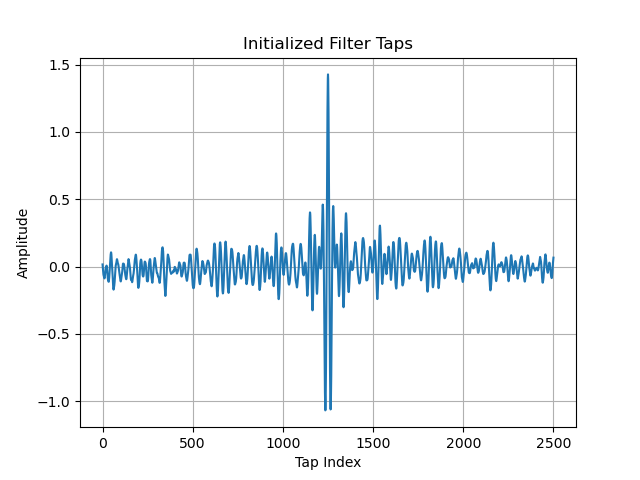

In [5]:
# Plot the initialized filter taps
plt.figure()
plt.plot(weigths_init[:])
plt.title("Initialized Filter Taps")
plt.xlabel("Tap Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Frequency Response Analysis of Initialized Filter
Every filter has an associated frequency response that dictates how different frequency components of a signal are amplified or attenuated. By analyzing this response, we can discern the filter's behavior and its potential impact on the input signals.

<IPython.core.display.Javascript object>


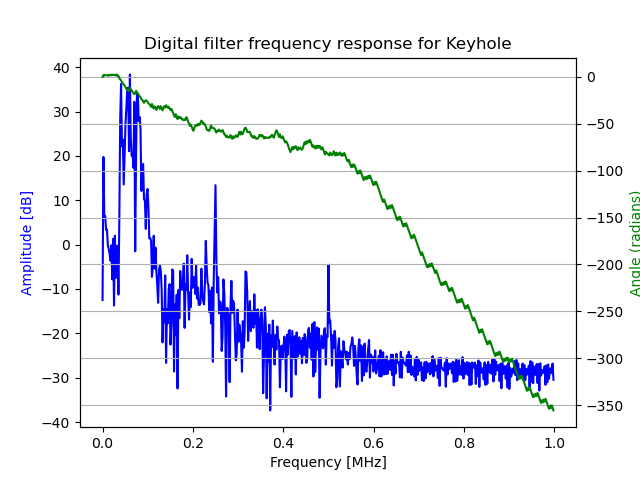

In [6]:
w, h = scipy.signal.freqz(weigths_init[:], fs=Fs)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response for Keyhole')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [7]:
weigths_init_cond = models_Cond_old[0].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

<IPython.core.display.Javascript object>


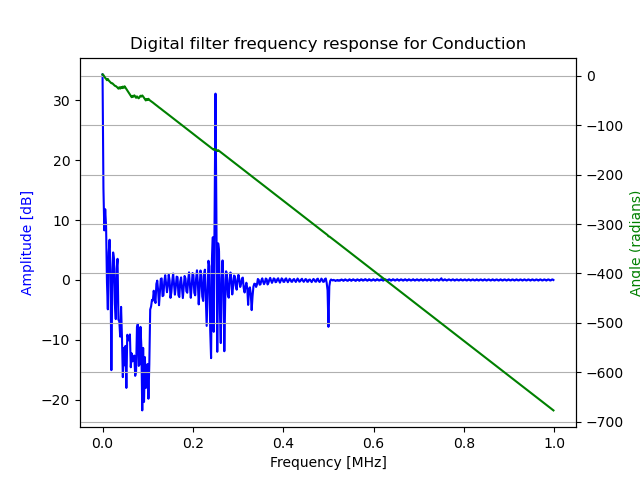

In [8]:
w, h = scipy.signal.freqz(weigths_init_cond[:], fs=Fs)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response for Conduction')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

### Database Loading
With the filter defined and weights initialized, the next step is to load our dataset. This dataset comprises acoustic signals corresponding to different melting regimes. We'll be using this data to train our filter and evaluate its performance.

In [9]:
xs = torch.load('./Database/Data')
GTs = torch.load('./Database/GTsTer')
names = torch.load('./Database/names')

In [10]:
names

['RM1', 'RM2', 'RM3', 'RM4', 'RM5', 'RM6', 'RM7_1', 'RM7_2', 'RM7_3']

### Sample Data Visualization
Before proceeding with the training and optimization processes, it's essential to visualize a sample from our dataset. This visualization provides insights into the signal characteristics and the corresponding ground truth labels, aiding in understanding the nature of the segmentation task ahead.

<IPython.core.display.Javascript object>


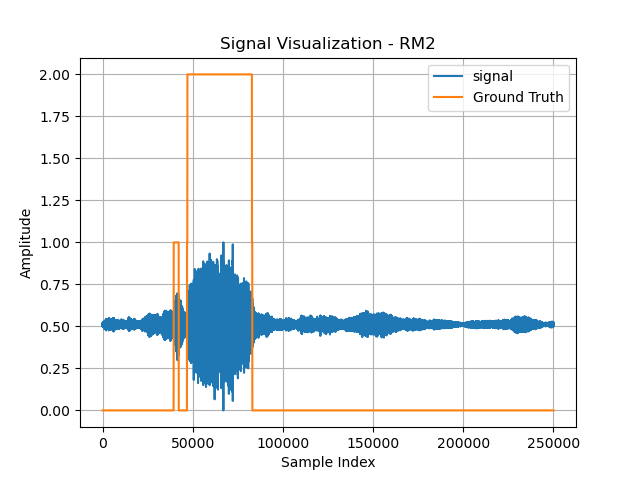

In [11]:
index = torch.randint(low=0, high=len(xs), size=(1,))
plt.figure()
signal = xs[index].view(-1).numpy()
plt.plot((signal-min(signal))/(max(signal)-min(signal)), label='signal')
plt.plot(GTs[index], label='Ground Truth')
plt.legend()
plt.title(f"Signal Visualization - {names[index]}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### GPU Device Configuration
To expedite computations, especially in deep learning tasks, it's common to utilize GPU (Graphics Processing Unit) devices. This segment checks if a GPU is available and sets the computation device accordingly. If no GPU is available, computations will default to the CPU (Central Processing Unit).

In [12]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

### Closure Function for Optimization
The closure function calculates the loss (or risk) across the dataset for the given predictions. This function excludes the data sample at the index outer to ensure that we're evaluating the model's performance on unseen data. This approach adopt leave-one-out cross-validation method, a popular technique for model validation.

In [13]:
def closure():
    total_risk = 0
    num_samples = 0

    for i, (name, current_GT, current_signal) in enumerate(zip(names, GTs, xs)):
        if i != outer:
            current_GT, current_signal = current_GT.to(device), current_signal.to(device)

            x_Cond = prediction(current_signal)
            x_KH = predictionKH(current_signal)
            x_Unst = predictionUnst(current_signal)

            predictions_combined = torch.cat([x_Cond, x_KH, x_Unst], dim=1)
            _, predicted_class = torch.max(predictions_combined, 1)

            current_loss = loss(predictions_combined, current_GT.view(-1).long())

            total_risk += current_loss
            num_samples += predictions_combined.shape[0]

    average_risk = total_risk / (len(xs) - 1)
    return average_risk


### Training Procedure for Multi-Regime Acoustic Signal Segmentation

The subsequent code block represents the central training loop for optimizing our models to segment the acoustic signal into three primary melting regimes:

1. **Conduction**
2. **Stable Keyhole**
3. **Unstable Keyhole**

The process can be broken down into the following steps:

- **Initialization**: 
  - Various parameters are set, pre-trained models are loaded, and new models are initialized.

- **Training Loop**: For each data sample:
  - The current data sample is excluded, following the leave-one-out cross-validation (LOOCV) methodology.
  - Models are initialized with weights from earlier trained binary models, which were also trained using the LOOCV strategy.
  - Regime weights are computed to address the issue of regime imbalance.
  - The L-BFGS optimization algorithm is then employed to fine-tune the models.
  - The model's performance is periodically assessed on the excluded sample, and the best models are saved, ensuring compliance with the LOOCV strategy.

- **Evaluation**: 
  - After the training phase, the performance of the models is evaluated on unseen signals.

This iterative procedure ensures that our models are robust and able to generalize well across the entire dataset.


In [14]:
# Enable anomaly detection to track operations that produce NaNs
torch.autograd.set_detect_anomaly(True)

# Parameter initialization
lr_init = 1.0
gamma = 0.00001
n_classes = 3
num_dec = 5

# Setting up metrics and placeholders
F1 = F1Score(task='multiclass', num_classes=n_classes, average='none').to(device)
F1_scores = []
test_names = []
models_Cond = []
models_KH = []
models_Unst = []

# Main loop across all data samples
for outer in range(len(xs)):
    print(f'Starting training without: {names[outer]}')

    # Parameter reset for each iteration
    old_risk = 0    
    min_risk = 1e12
    best_f1 = 0
    weights = np.zeros(n_classes)
    total = 0
    counter_flat = 0

    # Initialize models using weights from old models
    weights_init_cond = models_Cond_old[outer].smooth_filtKH.weight.detach().cpu().view(-1).numpy()
    weights_init_kh = models_KH_old[outer].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

    prediction = AdaptiveFilter_Ter(weights_init_cond, size).to(device)
    predictionKH = AdaptiveFilter_Ter(weights_init_kh, size).to(device)
    predictionUnst = AdaptiveFilter_Ter(weights_init_kh, size).to(device)  # Initialized with KH weights as starting guess

    # Compute regime weights for CrossEntropyLoss to handle regime imbalances
    for i in range(len(xs)):
        if i != outer:
            GT = GTs[i]
            total += GT.shape[0]
            for c in range(n_classes):
                weights[c] += torch.sum(GT == c)
                
    weights = total / (n_classes * weights)
    loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))

    # Training loop
    done = False
    n = 0
    while not done:
        print(f'Starting epoch: {n}')
        
        # Learning rate adjustments
        if n == 0 or time_is_now:
            print('-------------- Reinitialized optim --------------')
            lr = abs(lr_init + torch.randn(1) * lr_init).item()
            print(f'LR: {lr}')
            
            params = list(prediction.parameters()) + list(predictionKH.parameters()) + list(predictionUnst.parameters())
            optimizer = optim.LBFGS(params, lr=lr, line_search_fn="strong_wolfe")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
            
            time_is_now = False

        risk = 0
        scores = []
        predictions = []
        groundis = []
        optimizer.zero_grad()

        # Iterate through data samples
        for i in range(len(xs)):
            if i != outer:
                name = names[i]
                GT = GTs[i].to(device)
                signal = xs[i].to(device)

                # Adding noise if the risk is not decreasing
                if counter_flat >= 50:
                    signal += torch.randn(signal.shape).to(device) * (torch.max(signal) - torch.min(signal))
                    print("Adding noise")

                # Predictions
                x_Cond = prediction(signal)
                x_KH = predictionKH(signal)
                x_Unst = predictionUnst(signal)
                myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
                
                # Loss computation
                _, ind = torch.max(myPreds, 1)
                loss_value = loss(myPreds, GT.view(-1).long())
                
                risk += loss_value
                predictions.append(ind.long())
                groundis.append(GT.view(-1).long())
                
                # Score computation
                score = F1(ind.long(), GT.view(-1).long())
                scores.append(score.view(1, -1))
                print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')

        risk /= (len(xs) - 1)

        # Update best models if current risk is the lowest
        if risk.item() < min_risk:
            min_risk = risk.item()
            torch.save(prediction, f'./PocketModels/predictionCicca_{outer}')
            torch.save(predictionKH, f'./PocketModels/predictionKHCicca_{outer}')
            torch.save(predictionUnst, f'./PocketModels/predictionUNSTCicca_{outer}')

        # Print metrics
        f1_score_total = F1(torch.cat(predictions), torch.cat(groundis))
        print(f'Risk: {round(risk.item(), num_dec)}, min Risk: {round(min_risk, num_dec)}')
        print(f'Total F1-score Cond: {f1_score_total[0].item()}')
        print(f'Total F1-score KHSt: {f1_score_total[1].item()}')
        print(f'Total F1-score KHUnst: {f1_score_total[2].item()}')
        print('---' * 19)

        # Evaluate the model on the test sample after certain epochs
        if n % 2 == 0:
            with torch.no_grad():
                name = names[outer]
                GT = GTs[outer].to(device)
                signal = xs[outer].to(device)

                x_Cond = prediction(signal)
                x_KH = predictionKH(signal)
                x_Unst = predictionUnst(signal)
                
                myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
                _, ind = torch.max(myPreds, 1)
                score = F1(ind.long(), GT.view(-1).long())
                
                # Track the best score
                if torch.mean(score) > best_f1:
                    best_f1 = torch.mean(score)
                    myN = n
                    myF1 = score.to('cpu').detach()

                print(f'Testing on: {name}')
                print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')
                print(f'Best F1: {myF1}, iter: {myN}')
                print('----' * 50)

        n += 1
        
        # Termination conditions for the training loop
        if (n >= n_iters and min_risk < 0.2) or n >= 10000 or (counter_flat == 100 and min_risk < 0.50):
            done = True

        scheduler.step(risk)
        risk.backward()
        optimizer.step(closure)  
        new_risk = risk.clone().item()

        # Track if risk is not decreasing
        if abs(new_risk - old_risk) < 0.00001:
            time_is_now = True
            counter_flat += 1
        else:
            counter_flat = 0

        old_risk = new_risk

    # Load the best models and evaluate their performance
    prediction_test = torch.load(f'./PocketModels/predictionCicca_{outer}')
    predictionKH_test = torch.load(f'./PocketModels/predictionKHCicca_{outer}')
    predictionUnst_test = torch.load(f'./PocketModels/predictionUNSTCicca_{outer}')

    with torch.no_grad():
        name = names[outer]
        GT = GTs[outer].to(device)
        signal = xs[outer].to(device)

        x_Cond = prediction_test(signal)
        x_KH = predictionKH_test(signal)
        x_Unst = predictionUnst_test(signal)
        
        myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
        _, ind = torch.max(myPreds, 1)
        score = F1(ind.long(), GT.view(-1).long())

        print(f'Testing on: {name}')
        print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')
        print('----' * 50)

        # Storing the results
        F1_scores.append(score.view(1, -1))
        test_names.append(name)
        models_Cond.append(prediction_test)
        models_KH.append(predictionKH_test)
        models_Unst.append(predictionUnst_test)


Starting training without: RM1
Starting epoch: 0
-------------- Reinitialized optim --------------
LR: 0.0564611554145813
F1-score: tensor([0.0000, 0.0253, 0.0000]), Name: RM2
F1-score: tensor([0.0000, 0.0084, 0.0000]), Name: RM3
F1-score: tensor([0.0000, 0.8890, 0.0000]), Name: RM4
F1-score: tensor([0.0000, 0.8427, 0.0000]), Name: RM5
F1-score: tensor([0.0000, 0.1230, 0.0000]), Name: RM6
F1-score: tensor([0.0000, 0.1530, 0.0000]), Name: RM7_1
F1-score: tensor([0.0000, 0.2088, 0.0000]), Name: RM7_2
F1-score: tensor([0.0000, 0.2551, 0.0000]), Name: RM7_3
Risk: 1.35292, min Risk: 1.35292
Total F1-score Cond: 0.0
Total F1-score KHSt: 0.23382897675037384
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.0000, 0.5638, 0.0000]), Name: RM1
Best F1: tensor([0.0000, 0.5638, 0.0000]), iter: 0
---------------------------------------------------------------------------------------------------------------------------------------

Starting epoch: 10
F1-score: tensor([0.8479, 0.0905, 0.8623]), Name: RM2
F1-score: tensor([0.7256, 0.0095, 0.4748]), Name: RM3
F1-score: tensor([0.5083, 0.9498, 0.8149]), Name: RM4
F1-score: tensor([0.4469, 0.8625, 0.0000]), Name: RM5
F1-score: tensor([0.8981, 0.2690, 0.6493]), Name: RM6
F1-score: tensor([0.9154, 0.2690, 0.5877]), Name: RM7_1
F1-score: tensor([0.8578, 0.3888, 0.6865]), Name: RM7_2
F1-score: tensor([0.8791, 0.3864, 0.5357]), Name: RM7_3
Risk: 0.87413, min Risk: 0.87413
Total F1-score Cond: 0.8520135283470154
Total F1-score KHSt: 0.39253419637680054
Total F1-score KHUnst: 0.59544438123703
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.7893, 0.7340, 0.5844]), Name: RM1
Best F1: tensor([0.7893, 0.7340, 0.5844]), iter: 10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting

F1-score: tensor([0.8858, 0.3769, 0.5011]), Name: RM7_3
Risk: 0.85136, min Risk: 0.85136
Total F1-score Cond: 0.8400610089302063
Total F1-score KHSt: 0.37724244594573975
Total F1-score KHUnst: 0.5568561553955078
---------------------------------------------------------
Starting epoch: 20
F1-score: tensor([0.7940, 0.0732, 0.8564]), Name: RM2
F1-score: tensor([0.7288, 0.0092, 0.4434]), Name: RM3
F1-score: tensor([0.5272, 0.9467, 0.7797]), Name: RM4
F1-score: tensor([0.4682, 0.8638, 0.0000]), Name: RM5
F1-score: tensor([0.9024, 0.2464, 0.5655]), Name: RM6
F1-score: tensor([0.9199, 0.2563, 0.5420]), Name: RM7_1
F1-score: tensor([0.8593, 0.3772, 0.6604]), Name: RM7_2
F1-score: tensor([0.8858, 0.3769, 0.5011]), Name: RM7_3
Risk: 0.85136, min Risk: 0.85136
Total F1-score Cond: 0.8400610089302063
Total F1-score KHSt: 0.3772435188293457
Total F1-score KHUnst: 0.5568596720695496
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.7722, 0.7246, 0.5615]), 

F1-score: tensor([0.9785, 0.5961, 0.9590]), Name: RM6
F1-score: tensor([0.9663, 0.7857, 0.9818]), Name: RM7_1
F1-score: tensor([0.9570, 0.6315, 0.9360]), Name: RM7_2
F1-score: tensor([0.9681, 0.6720, 0.9370]), Name: RM7_3
Risk: 0.73392, min Risk: 0.73392
Total F1-score Cond: 0.9662705659866333
Total F1-score KHSt: 0.6884008646011353
Total F1-score KHUnst: 0.932567298412323
---------------------------------------------------------
Starting epoch: 30
F1-score: tensor([0.9735, 0.0511, 0.9433]), Name: RM2
F1-score: tensor([0.9432, 0.0000, 0.7800]), Name: RM3
F1-score: tensor([0.8436, 0.9034, 0.6933]), Name: RM4
F1-score: tensor([0.9021, 0.9247, 0.6691]), Name: RM5
F1-score: tensor([0.9781, 0.6069, 0.9460]), Name: RM6
F1-score: tensor([0.9648, 0.7358, 0.9708]), Name: RM7_1
F1-score: tensor([0.9603, 0.6529, 0.9236]), Name: RM7_2
F1-score: tensor([0.9671, 0.7783, 0.9495]), Name: RM7_3
Risk: 0.73199, min Risk: 0.73199
Total F1-score Cond: 0.964159369468689
Total F1-score KHSt: 0.68401861190795

Starting epoch: 39
F1-score: tensor([0.9831, 0.0730, 0.9552]), Name: RM2
F1-score: tensor([0.9487, 0.0000, 0.9366]), Name: RM3
F1-score: tensor([0.7940, 0.8603, 0.6055]), Name: RM4
F1-score: tensor([0.8147, 0.8423, 0.5750]), Name: RM5
F1-score: tensor([0.9741, 0.6367, 0.9752]), Name: RM6
F1-score: tensor([0.9620, 0.8483, 0.9932]), Name: RM7_1
F1-score: tensor([0.9538, 0.6483, 0.9510]), Name: RM7_2
F1-score: tensor([0.9640, 0.5480, 0.9283]), Name: RM7_3
Risk: 0.71272, min Risk: 0.71272
Total F1-score Cond: 0.9630831480026245
Total F1-score KHSt: 0.6946350932121277
Total F1-score KHUnst: 0.9468735456466675
---------------------------------------------------------
Starting epoch: 40
F1-score: tensor([0.9765, 0.0575, 0.9511]), Name: RM2
F1-score: tensor([0.9422, 0.0000, 0.9072]), Name: RM3
F1-score: tensor([0.8251, 0.8769, 0.6284]), Name: RM4
F1-score: tensor([0.8728, 0.8792, 0.6030]), Name: RM5
F1-score: tensor([0.9733, 0.6428, 0.9689]), Name: RM6
F1-score: tensor([0.9605, 0.8389, 0.9911]

Starting epoch: 49
F1-score: tensor([0.9864, 0.0859, 0.9594]), Name: RM2
F1-score: tensor([0.9504, 0.0000, 0.9595]), Name: RM3
F1-score: tensor([0.7786, 0.8463, 0.5870]), Name: RM4
F1-score: tensor([0.7585, 0.8025, 0.5518]), Name: RM5
F1-score: tensor([0.9746, 0.6087, 0.9773]), Name: RM6
F1-score: tensor([0.9630, 0.8262, 0.9919]), Name: RM7_1
F1-score: tensor([0.9485, 0.6282, 0.9569]), Name: RM7_2
F1-score: tensor([0.9645, 0.4428, 0.9206]), Name: RM7_3
Risk: 0.70846, min Risk: 0.70846
Total F1-score Cond: 0.962270975112915
Total F1-score KHSt: 0.6742092967033386
Total F1-score KHUnst: 0.9489850401878357
---------------------------------------------------------
Starting epoch: 50
F1-score: tensor([0.9864, 0.1135, 0.9925]), Name: RM2
F1-score: tensor([0.9651, 0.0000, 0.9822]), Name: RM3
F1-score: tensor([0.8109, 0.6315, 0.4009]), Name: RM4
F1-score: tensor([0.8548, 0.7128, 0.4222]), Name: RM5
F1-score: tensor([0.9879, 0.4337, 0.9666]), Name: RM6
F1-score: tensor([0.9751, 0.5245, 0.9704])

Starting epoch: 59
F1-score: tensor([0.9898, 0.1165, 0.9747]), Name: RM2
F1-score: tensor([0.9582, 0.0000, 0.9783]), Name: RM3
F1-score: tensor([0.7797, 0.7826, 0.5164]), Name: RM4
F1-score: tensor([0.7598, 0.7401, 0.4806]), Name: RM5
F1-score: tensor([0.9801, 0.3998, 0.9704]), Name: RM6
F1-score: tensor([0.9686, 0.5401, 0.9726]), Name: RM7_1
F1-score: tensor([0.9497, 0.5205, 0.9625]), Name: RM7_2
F1-score: tensor([0.9706, 0.3209, 0.9203]), Name: RM7_3
Risk: 0.59472, min Risk: 0.59472
Total F1-score Cond: 0.9666993618011475
Total F1-score KHSt: 0.5849045515060425
Total F1-score KHUnst: 0.9449067115783691
---------------------------------------------------------
Starting epoch: 60
F1-score: tensor([0.9867, 0.0733, 0.9327]), Name: RM2
F1-score: tensor([0.9613, 0.0000, 0.7167]), Name: RM3
F1-score: tensor([0.8225, 0.9657, 0.8742]), Name: RM4
F1-score: tensor([0.8399, 0.8865, 0.0000]), Name: RM5
F1-score: tensor([0.9861, 0.6646, 0.9758]), Name: RM6
F1-score: tensor([0.9740, 0.7632, 0.9831]

Starting epoch: 69
F1-score: tensor([0.9761, 0.2657, 0.8770]), Name: RM2
F1-score: tensor([0.9630, 0.0000, 0.1612]), Name: RM3
F1-score: tensor([0.9006, 0.9141, 0.0000]), Name: RM4
F1-score: tensor([0.9201, 0.9036, 0.0000]), Name: RM5
F1-score: tensor([0.9916, 0.6915, 0.9783]), Name: RM6
F1-score: tensor([0.9777, 0.6499, 0.9748]), Name: RM7_1
F1-score: tensor([0.9600, 0.7254, 0.9735]), Name: RM7_2
F1-score: tensor([0.9821, 0.5209, 0.9182]), Name: RM7_3
Risk: 0.32488, min Risk: 0.32488
Total F1-score Cond: 0.9735864400863647
Total F1-score KHSt: 0.5514851212501526
Total F1-score KHUnst: 0.8681217432022095
---------------------------------------------------------
Starting epoch: 70
F1-score: tensor([0.9765, 0.2794, 0.8945]), Name: RM2
F1-score: tensor([0.9628, 0.0000, 0.4012]), Name: RM3
F1-score: tensor([0.8966, 0.9138, 0.0000]), Name: RM4
F1-score: tensor([0.9172, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9910, 0.6195, 0.9741]), Name: RM6
F1-score: tensor([0.9771, 0.6148, 0.9734]

Starting epoch: 79
F1-score: tensor([0.9700, 0.2472, 0.8884]), Name: RM2
F1-score: tensor([0.9642, 0.0000, 0.4149]), Name: RM3
F1-score: tensor([0.9199, 0.9158, 0.0000]), Name: RM4
F1-score: tensor([0.9227, 0.9045, 0.0000]), Name: RM5
F1-score: tensor([0.9960, 0.7243, 0.9612]), Name: RM6
F1-score: tensor([0.9803, 0.7470, 0.9740]), Name: RM7_1
F1-score: tensor([0.9565, 0.6406, 0.9251]), Name: RM7_2
F1-score: tensor([0.9836, 0.6380, 0.9088]), Name: RM7_3
Risk: 0.28384, min Risk: 0.28384
Total F1-score Cond: 0.9728008508682251
Total F1-score KHSt: 0.606071412563324
Total F1-score KHUnst: 0.867386519908905
---------------------------------------------------------
Starting epoch: 80
F1-score: tensor([0.9804, 0.3082, 0.9045]), Name: RM2
F1-score: tensor([0.9568, 0.0000, 0.6826]), Name: RM3
F1-score: tensor([0.8429, 0.9086, 0.0000]), Name: RM4
F1-score: tensor([0.8717, 0.8937, 0.0000]), Name: RM5
F1-score: tensor([0.9820, 0.6319, 0.9595]), Name: RM6
F1-score: tensor([0.9679, 0.7034, 0.9721]),

Starting epoch: 89
F1-score: tensor([0.9742, 0.3036, 0.9397]), Name: RM2
F1-score: tensor([0.9620, 0.0000, 0.9503]), Name: RM3
F1-score: tensor([0.8867, 0.9557, 0.7259]), Name: RM4
F1-score: tensor([0.9082, 0.9013, 0.0000]), Name: RM5
F1-score: tensor([0.9914, 0.7782, 0.9776]), Name: RM6
F1-score: tensor([0.9757, 0.8162, 0.9864]), Name: RM7_1
F1-score: tensor([0.9577, 0.6678, 0.9344]), Name: RM7_2
F1-score: tensor([0.9792, 0.6832, 0.9321]), Name: RM7_3
Risk: 0.22294, min Risk: 0.22294
Total F1-score Cond: 0.9715569615364075
Total F1-score KHSt: 0.7674170732498169
Total F1-score KHUnst: 0.9490001201629639
---------------------------------------------------------
Starting epoch: 90
F1-score: tensor([0.9712, 0.2868, 0.9390]), Name: RM2
F1-score: tensor([0.9633, 0.0000, 0.9471]), Name: RM3
F1-score: tensor([0.9142, 0.9592, 0.7371]), Name: RM4
F1-score: tensor([0.9279, 0.9051, 0.0000]), Name: RM5
F1-score: tensor([0.9959, 0.7873, 0.9730]), Name: RM6
F1-score: tensor([0.9795, 0.8237, 0.9852]

Starting epoch: 99
F1-score: tensor([0.9729, 0.3001, 0.9437]), Name: RM2
F1-score: tensor([0.9624, 0.0000, 0.9724]), Name: RM3
F1-score: tensor([0.8964, 0.9613, 0.7724]), Name: RM4
F1-score: tensor([0.9144, 0.9025, 0.0000]), Name: RM5
F1-score: tensor([0.9931, 0.7722, 0.9735]), Name: RM6
F1-score: tensor([0.9769, 0.8231, 0.9862]), Name: RM7_1
F1-score: tensor([0.9574, 0.6170, 0.9112]), Name: RM7_2
F1-score: tensor([0.9809, 0.7026, 0.9323]), Name: RM7_3
Risk: 0.21953, min Risk: 0.21953
Total F1-score Cond: 0.9720017910003662
Total F1-score KHSt: 0.7697373628616333
Total F1-score KHUnst: 0.948058545589447
---------------------------------------------------------
Starting epoch: 100
F1-score: tensor([0.9725, 0.3026, 0.9494]), Name: RM2
F1-score: tensor([0.9623, 0.0000, 0.9798]), Name: RM3
F1-score: tensor([0.9001, 0.9663, 0.8151]), Name: RM4
F1-score: tensor([0.9157, 0.9028, 0.0000]), Name: RM5
F1-score: tensor([0.9939, 0.7679, 0.9711]), Name: RM6
F1-score: tensor([0.9773, 0.8176, 0.9846]

Starting epoch: 109
-------------- Reinitialized optim --------------
LR: 2.1323561668395996
F1-score: tensor([0.9732, 0.3082, 0.9508]), Name: RM2
F1-score: tensor([0.9620, 0.0000, 0.9814]), Name: RM3
F1-score: tensor([0.8946, 0.9682, 0.8361]), Name: RM4
F1-score: tensor([0.9120, 0.9021, 0.0000]), Name: RM5
F1-score: tensor([0.9930, 0.7773, 0.9746]), Name: RM6
F1-score: tensor([0.9765, 0.8265, 0.9867]), Name: RM7_1
F1-score: tensor([0.9573, 0.6161, 0.9114]), Name: RM7_2
F1-score: tensor([0.9805, 0.7131, 0.9352]), Name: RM7_3
Risk: 0.21726, min Risk: 0.21726
Total F1-score Cond: 0.9718419909477234
Total F1-score KHSt: 0.7787274122238159
Total F1-score KHUnst: 0.9512358903884888
---------------------------------------------------------
Starting epoch: 110
F1-score: tensor([0.9726, 0.3025, 0.9482]), Name: RM2
F1-score: tensor([0.9623, 0.0000, 0.9791]), Name: RM3
F1-score: tensor([0.8997, 0.9666, 0.8184]), Name: RM4
F1-score: tensor([0.9160, 0.9028, 0.0000]), Name: RM5
F1-score: tensor([0.

Starting epoch: 119
F1-score: tensor([0.9733, 0.3075, 0.9495]), Name: RM2
F1-score: tensor([0.9621, 0.0000, 0.9811]), Name: RM3
F1-score: tensor([0.8955, 0.9682, 0.8352]), Name: RM4
F1-score: tensor([0.9130, 0.9023, 0.0000]), Name: RM5
F1-score: tensor([0.9931, 0.7769, 0.9741]), Name: RM6
F1-score: tensor([0.9767, 0.8289, 0.9868]), Name: RM7_1
F1-score: tensor([0.9575, 0.6115, 0.9086]), Name: RM7_2
F1-score: tensor([0.9808, 0.7174, 0.9352]), Name: RM7_3
Risk: 0.21637, min Risk: 0.21637
Total F1-score Cond: 0.9720001816749573
Total F1-score KHSt: 0.7781619429588318
Total F1-score KHUnst: 0.9505661129951477
---------------------------------------------------------
Starting epoch: 120
F1-score: tensor([0.9730, 0.3049, 0.9484]), Name: RM2
F1-score: tensor([0.9622, 0.0000, 0.9808]), Name: RM3
F1-score: tensor([0.8980, 0.9675, 0.8278]), Name: RM4
F1-score: tensor([0.9150, 0.9027, 0.0000]), Name: RM5
F1-score: tensor([0.9935, 0.7733, 0.9727]), Name: RM6
F1-score: tensor([0.9770, 0.8259, 0.985

Starting epoch: 129
-------------- Reinitialized optim --------------
LR: 0.3855031728744507
F1-score: tensor([0.9735, 0.3082, 0.9492]), Name: RM2
F1-score: tensor([0.9621, 0.0000, 0.9810]), Name: RM3
F1-score: tensor([0.8953, 0.9684, 0.8371]), Name: RM4
F1-score: tensor([0.9131, 0.9023, 0.0000]), Name: RM5
F1-score: tensor([0.9931, 0.7784, 0.9745]), Name: RM6
F1-score: tensor([0.9767, 0.8291, 0.9868]), Name: RM7_1
F1-score: tensor([0.9576, 0.6122, 0.9089]), Name: RM7_2
F1-score: tensor([0.9809, 0.7176, 0.9353]), Name: RM7_3
Risk: 0.21588, min Risk: 0.21588
Total F1-score Cond: 0.9720611572265625
Total F1-score KHSt: 0.778571605682373
Total F1-score KHUnst: 0.9506767392158508
---------------------------------------------------------
Starting epoch: 130
-------------- Reinitialized optim --------------
LR: 1.3009953498840332
F1-score: tensor([0.9732, 0.3059, 0.9482]), Name: RM2
F1-score: tensor([0.9622, 0.0000, 0.9808]), Name: RM3
F1-score: tensor([0.8976, 0.9678, 0.8304]), Name: RM4
F1

Starting epoch: 139
F1-score: tensor([0.9741, 0.3132, 0.9503]), Name: RM2
F1-score: tensor([0.9618, 0.0000, 0.9814]), Name: RM3
F1-score: tensor([0.8916, 0.9695, 0.8493]), Name: RM4
F1-score: tensor([0.9103, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9924, 0.7873, 0.9772]), Name: RM6
F1-score: tensor([0.9761, 0.8252, 0.9868]), Name: RM7_1
F1-score: tensor([0.9578, 0.6286, 0.9176]), Name: RM7_2
F1-score: tensor([0.9803, 0.7121, 0.9362]), Name: RM7_3
Risk: 0.21528, min Risk: 0.21528
Total F1-score Cond: 0.9719331860542297
Total F1-score KHSt: 0.7831321954727173
Total F1-score KHUnst: 0.9530737400054932
---------------------------------------------------------
Starting epoch: 140
F1-score: tensor([0.9735, 0.3041, 0.9448]), Name: RM2
F1-score: tensor([0.9624, 0.0000, 0.9803]), Name: RM3
F1-score: tensor([0.9044, 0.9679, 0.8255]), Name: RM4
F1-score: tensor([0.9201, 0.9036, 0.0000]), Name: RM5
F1-score: tensor([0.9945, 0.7833, 0.9730]), Name: RM6
F1-score: tensor([0.9780, 0.8253, 0.985

Starting epoch: 149
F1-score: tensor([0.9740, 0.3097, 0.9471]), Name: RM2
F1-score: tensor([0.9619, 0.0000, 0.9810]), Name: RM3
F1-score: tensor([0.8955, 0.9678, 0.8323]), Name: RM4
F1-score: tensor([0.9135, 0.9024, 0.0000]), Name: RM5
F1-score: tensor([0.9932, 0.7844, 0.9753]), Name: RM6
F1-score: tensor([0.9768, 0.8321, 0.9869]), Name: RM7_1
F1-score: tensor([0.9581, 0.6097, 0.9071]), Name: RM7_2
F1-score: tensor([0.9813, 0.7287, 0.9365]), Name: RM7_3
Risk: 0.21231, min Risk: 0.21231
Total F1-score Cond: 0.9723891615867615
Total F1-score KHSt: 0.780643105506897
Total F1-score KHUnst: 0.9506333470344543
---------------------------------------------------------
Starting epoch: 150
F1-score: tensor([0.9734, 0.3058, 0.9472]), Name: RM2
F1-score: tensor([0.9623, 0.0000, 0.9811]), Name: RM3
F1-score: tensor([0.9015, 0.9685, 0.8332]), Name: RM4
F1-score: tensor([0.9179, 0.9032, 0.0000]), Name: RM5
F1-score: tensor([0.9941, 0.7918, 0.9755]), Name: RM6
F1-score: tensor([0.9777, 0.8344, 0.9869

Starting epoch: 159
F1-score: tensor([0.9735, 0.3084, 0.9493]), Name: RM2
F1-score: tensor([0.9622, 0.0000, 0.9819]), Name: RM3
F1-score: tensor([0.8991, 0.9694, 0.8424]), Name: RM4
F1-score: tensor([0.9162, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9939, 0.8043, 0.9784]), Name: RM6
F1-score: tensor([0.9775, 0.8291, 0.9867]), Name: RM7_1
F1-score: tensor([0.9580, 0.6265, 0.9149]), Name: RM7_2
F1-score: tensor([0.9819, 0.7183, 0.9366]), Name: RM7_3
Risk: 0.21055, min Risk: 0.21055
Total F1-score Cond: 0.9726040363311768
Total F1-score KHSt: 0.7844879031181335
Total F1-score KHUnst: 0.9527428150177002
---------------------------------------------------------
Starting epoch: 160
F1-score: tensor([0.9746, 0.3129, 0.9471]), Name: RM2
F1-score: tensor([0.9616, 0.0000, 0.9815]), Name: RM3
F1-score: tensor([0.8895, 0.9661, 0.8219]), Name: RM4
F1-score: tensor([0.9088, 0.9014, 0.0000]), Name: RM5
F1-score: tensor([0.9924, 0.7807, 0.9755]), Name: RM6
F1-score: tensor([0.9761, 0.8297, 0.986

F1-score: tensor([0.9662, 0.1705, 0.0000]), Name: RM7_1
F1-score: tensor([0.9650, 0.2522, 0.0000]), Name: RM7_2
F1-score: tensor([0.9618, 0.2952, 0.0000]), Name: RM7_3
Risk: 0.90489, min Risk: 0.90489
Total F1-score Cond: 0.8612803220748901
Total F1-score KHSt: 0.24913913011550903
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Starting epoch: 4
F1-score: tensor([0.7798, 0.5516, 0.0000]), Name: RM1
F1-score: tensor([0.9370, 0.0000, 0.0000]), Name: RM3
F1-score: tensor([0.2383, 0.6320, 0.0000]), Name: RM4
F1-score: tensor([0.5055, 0.7363, 0.0000]), Name: RM5
F1-score: tensor([0.9742, 0.1866, 0.0000]), Name: RM6
F1-score: tensor([0.9664, 0.1771, 0.0000]), Name: RM7_1
F1-score: tensor([0.9562, 0.2575, 0.0000]), Name: RM7_2
F1-score: tensor([0.9500, 0.2956, 0.0000]), Name: RM7_3
Risk: 0.9011, min Risk: 0.9011
Total F1-score Cond: 0.8893763422966003
Total F1-score KHSt: 0.29322054982185364
Total F1-score KHUnst: 0.0
--------------------------------------

F1-score: tensor([0.9684, 0.4830, 0.7925]), Name: RM7_2
F1-score: tensor([0.9648, 0.5201, 0.7663]), Name: RM7_3
Risk: 0.84608, min Risk: 0.84608
Total F1-score Cond: 0.891497015953064
Total F1-score KHSt: 0.45036372542381287
Total F1-score KHUnst: 0.7243314385414124
---------------------------------------------------------
Starting epoch: 14
F1-score: tensor([0.7959, 0.6149, 0.3873]), Name: RM1
F1-score: tensor([0.9058, 0.0000, 0.1833]), Name: RM3
F1-score: tensor([0.6295, 0.8783, 0.0000]), Name: RM4
F1-score: tensor([0.8520, 0.8957, 0.0000]), Name: RM5
F1-score: tensor([0.9601, 0.3876, 0.8070]), Name: RM6
F1-score: tensor([0.9686, 0.3654, 0.7660]), Name: RM7_1
F1-score: tensor([0.9338, 0.4390, 0.7439]), Name: RM7_2
F1-score: tensor([0.9411, 0.4561, 0.6760]), Name: RM7_3
Risk: 0.84265, min Risk: 0.84265
Total F1-score Cond: 0.9152387976646423
Total F1-score KHSt: 0.47146907448768616
Total F1-score KHUnst: 0.6481642723083496
---------------------------------------------------------
Test

F1-score: tensor([0.9741, 0.2927, 0.9583]), Name: RM6
F1-score: tensor([0.9579, 0.1734, 0.9554]), Name: RM7_1
F1-score: tensor([0.9424, 0.3426, 0.9422]), Name: RM7_2
F1-score: tensor([0.9538, 0.1861, 0.9107]), Name: RM7_3
Risk: 0.70968, min Risk: 0.70968
Total F1-score Cond: 0.9341942667961121
Total F1-score KHSt: 0.5802577137947083
Total F1-score KHUnst: 0.9326111674308777
---------------------------------------------------------
Starting epoch: 24
F1-score: tensor([0.8327, 0.7117, 0.8748]), Name: RM1
F1-score: tensor([0.9333, 0.0000, 0.9833]), Name: RM3
F1-score: tensor([0.8374, 0.8425, 0.5687]), Name: RM4
F1-score: tensor([0.9111, 0.8517, 0.5892]), Name: RM5
F1-score: tensor([0.9741, 0.2927, 0.9583]), Name: RM6
F1-score: tensor([0.9579, 0.1734, 0.9554]), Name: RM7_1
F1-score: tensor([0.9424, 0.3426, 0.9422]), Name: RM7_2
F1-score: tensor([0.9538, 0.1861, 0.9107]), Name: RM7_3
Risk: 0.70968, min Risk: 0.70968
Total F1-score Cond: 0.9341950416564941
Total F1-score KHSt: 0.580259859561

F1-score: tensor([0.9160, 0.0000, 0.7096]), Name: RM3
F1-score: tensor([0.8699, 0.9740, 0.9176]), Name: RM4
F1-score: tensor([0.8599, 0.8966, 0.0000]), Name: RM5
F1-score: tensor([0.9575, 0.5714, 0.9765]), Name: RM6
F1-score: tensor([0.9593, 0.7206, 0.9805]), Name: RM7_1
F1-score: tensor([0.9284, 0.7067, 0.9705]), Name: RM7_2
F1-score: tensor([0.9342, 0.4956, 0.9276]), Name: RM7_3
Risk: 0.68081, min Risk: 0.68081
Total F1-score Cond: 0.9338664412498474
Total F1-score KHSt: 0.6973802447319031
Total F1-score KHUnst: 0.9236048460006714
---------------------------------------------------------
Starting epoch: 34
F1-score: tensor([0.9099, 0.9011, 0.9448]), Name: RM1
F1-score: tensor([0.9161, 0.0000, 0.7096]), Name: RM3
F1-score: tensor([0.8699, 0.9740, 0.9175]), Name: RM4
F1-score: tensor([0.8599, 0.8966, 0.0000]), Name: RM5
F1-score: tensor([0.9575, 0.5715, 0.9765]), Name: RM6
F1-score: tensor([0.9593, 0.7205, 0.9805]), Name: RM7_1
F1-score: tensor([0.9284, 0.7067, 0.9705]), Name: RM7_2
F1

Starting epoch: 43
F1-score: tensor([0.9085, 0.9007, 0.9459]), Name: RM1
F1-score: tensor([0.9118, 0.0000, 0.7228]), Name: RM3
F1-score: tensor([0.8714, 0.9740, 0.9175]), Name: RM4
F1-score: tensor([0.8587, 0.8965, 0.0000]), Name: RM5
F1-score: tensor([0.9576, 0.5661, 0.9760]), Name: RM6
F1-score: tensor([0.9596, 0.7177, 0.9803]), Name: RM7_1
F1-score: tensor([0.9276, 0.7066, 0.9714]), Name: RM7_2
F1-score: tensor([0.9345, 0.4888, 0.9274]), Name: RM7_3
Risk: 0.67822, min Risk: 0.67822
Total F1-score Cond: 0.9330959916114807
Total F1-score KHSt: 0.6986269950866699
Total F1-score KHUnst: 0.9252239465713501
---------------------------------------------------------
Starting epoch: 44
F1-score: tensor([0.9185, 0.9075, 0.9491]), Name: RM1
F1-score: tensor([0.9237, 0.0000, 0.7617]), Name: RM3
F1-score: tensor([0.8592, 0.9726, 0.9088]), Name: RM4
F1-score: tensor([0.8828, 0.8994, 0.0000]), Name: RM5
F1-score: tensor([0.9649, 0.5680, 0.9748]), Name: RM6
F1-score: tensor([0.9582, 0.6987, 0.9800]

Starting epoch: 53
F1-score: tensor([0.9083, 0.9007, 0.9464]), Name: RM1
F1-score: tensor([0.9141, 0.0000, 0.7276]), Name: RM3
F1-score: tensor([0.8718, 0.9741, 0.9197]), Name: RM4
F1-score: tensor([0.8595, 0.8966, 0.0000]), Name: RM5
F1-score: tensor([0.9584, 0.5652, 0.9757]), Name: RM6
F1-score: tensor([0.9598, 0.7151, 0.9802]), Name: RM7_1
F1-score: tensor([0.9280, 0.7058, 0.9716]), Name: RM7_2
F1-score: tensor([0.9354, 0.4856, 0.9273]), Name: RM7_3
Risk: 0.6751, min Risk: 0.6751
Total F1-score Cond: 0.9337697625160217
Total F1-score KHSt: 0.6995124220848083
Total F1-score KHUnst: 0.9258022308349609
---------------------------------------------------------
Starting epoch: 54
F1-score: tensor([0.9185, 0.9081, 0.9501]), Name: RM1
F1-score: tensor([0.9244, 0.0000, 0.7783]), Name: RM3
F1-score: tensor([0.8589, 0.9726, 0.9107]), Name: RM4
F1-score: tensor([0.8856, 0.8997, 0.0000]), Name: RM5
F1-score: tensor([0.9659, 0.5667, 0.9745]), Name: RM6
F1-score: tensor([0.9583, 0.6946, 0.9798]),

Starting epoch: 63
F1-score: tensor([0.1705, 0.7061, 0.9043]), Name: RM1
F1-score: tensor([0.1649, 0.0134, 0.6409]), Name: RM3
F1-score: tensor([0.9012, 0.9788, 0.9068]), Name: RM4
F1-score: tensor([0.7442, 0.8845, 0.0000]), Name: RM5
F1-score: tensor([0.1133, 0.1903, 0.9740]), Name: RM6
F1-score: tensor([0.1123, 0.3752, 0.9810]), Name: RM7_1
F1-score: tensor([0.0966, 0.4156, 0.9652]), Name: RM7_2
F1-score: tensor([0.1166, 0.3638, 0.9269]), Name: RM7_3
Risk: 0.63346, min Risk: 0.63346
Total F1-score Cond: 0.15638989210128784
Total F1-score KHSt: 0.48516830801963806
Total F1-score KHUnst: 0.9123377799987793
---------------------------------------------------------
Starting epoch: 64
F1-score: tensor([0.3411, 0.7297, 0.9085]), Name: RM1
F1-score: tensor([0.5950, 0.0161, 0.6695]), Name: RM3
F1-score: tensor([0.8843, 0.9225, 0.1980]), Name: RM4
F1-score: tensor([0.8126, 0.8913, 0.0000]), Name: RM5
F1-score: tensor([0.7864, 0.3497, 0.9600]), Name: RM6
F1-score: tensor([0.8521, 0.5436, 0.970

Starting epoch: 73
F1-score: tensor([0.8892, 0.8771, 0.9201]), Name: RM1
F1-score: tensor([0.9026, 0.0245, 0.8175]), Name: RM3
F1-score: tensor([0.9067, 0.9147, 0.0000]), Name: RM4
F1-score: tensor([0.9271, 0.9050, 0.0000]), Name: RM5
F1-score: tensor([0.9845, 0.5203, 0.9570]), Name: RM6
F1-score: tensor([0.9352, 0.3626, 0.9669]), Name: RM7_1
F1-score: tensor([0.7009, 0.3362, 0.9582]), Name: RM7_2
F1-score: tensor([0.9592, 0.5658, 0.9374]), Name: RM7_3
Risk: 0.43023, min Risk: 0.43023
Total F1-score Cond: 0.8931142687797546
Total F1-score KHSt: 0.6538931131362915
Total F1-score KHUnst: 0.925221860408783
---------------------------------------------------------
Starting epoch: 74
F1-score: tensor([0.8742, 0.8736, 0.9405]), Name: RM1
F1-score: tensor([0.9047, 0.0308, 0.8668]), Name: RM3
F1-score: tensor([0.9093, 0.9445, 0.5711]), Name: RM4
F1-score: tensor([0.9276, 0.9051, 0.0000]), Name: RM5
F1-score: tensor([0.9850, 0.4282, 0.9623]), Name: RM6
F1-score: tensor([0.9427, 0.2461, 0.9655])

Starting epoch: 83
F1-score: tensor([0.8640, 0.8761, 0.9570]), Name: RM1
F1-score: tensor([0.8996, 0.0349, 0.8844]), Name: RM3
F1-score: tensor([0.9132, 0.9453, 0.5766]), Name: RM4
F1-score: tensor([0.9208, 0.9038, 0.0000]), Name: RM5
F1-score: tensor([0.9799, 0.3673, 0.9606]), Name: RM6
F1-score: tensor([0.9275, 0.2270, 0.9704]), Name: RM7_1
F1-score: tensor([0.6643, 0.1756, 0.9597]), Name: RM7_2
F1-score: tensor([0.9309, 0.2239, 0.9243]), Name: RM7_3
Risk: 0.3892, min Risk: 0.3892
Total F1-score Cond: 0.8760998249053955
Total F1-score KHSt: 0.6186833381652832
Total F1-score KHUnst: 0.936922013759613
---------------------------------------------------------
Starting epoch: 84
F1-score: tensor([0.8746, 0.8729, 0.9487]), Name: RM1
F1-score: tensor([0.9091, 0.0432, 0.9101]), Name: RM3
F1-score: tensor([0.9108, 0.9722, 0.8566]), Name: RM4
F1-score: tensor([0.9225, 0.9041, 0.0000]), Name: RM5
F1-score: tensor([0.9801, 0.3270, 0.9673]), Name: RM6
F1-score: tensor([0.9317, 0.2318, 0.9710]), 

Starting epoch: 93
F1-score: tensor([0.8775, 0.8841, 0.9572]), Name: RM1
F1-score: tensor([0.9219, 0.2865, 0.9847]), Name: RM3
F1-score: tensor([0.9197, 0.9719, 0.8575]), Name: RM4
F1-score: tensor([0.8778, 0.8987, 0.0000]), Name: RM5
F1-score: tensor([0.9792, 0.6548, 0.9722]), Name: RM6
F1-score: tensor([0.8910, 0.3829, 0.9860]), Name: RM7_1
F1-score: tensor([0.6673, 0.2066, 0.9417]), Name: RM7_2
F1-score: tensor([0.8801, 0.5447, 0.9216]), Name: RM7_3
Risk: 0.3246, min Risk: 0.3246
Total F1-score Cond: 0.8614919185638428
Total F1-score KHSt: 0.6967800855636597
Total F1-score KHUnst: 0.9547671675682068
---------------------------------------------------------
Starting epoch: 94
F1-score: tensor([0.8732, 0.8775, 0.9594]), Name: RM1
F1-score: tensor([0.9230, 0.0582, 0.9840]), Name: RM3
F1-score: tensor([0.9362, 0.9735, 0.8629]), Name: RM4
F1-score: tensor([0.8877, 0.9000, 0.0000]), Name: RM5
F1-score: tensor([0.9771, 0.6555, 0.9773]), Name: RM6
F1-score: tensor([0.8888, 0.3210, 0.9845]),

Starting epoch: 103
-------------- Reinitialized optim --------------
LR: 3.010793447494507
F1-score: tensor([0.8706, 0.8733, 0.9641]), Name: RM1
F1-score: tensor([0.9411, 0.0000, 0.9830]), Name: RM3
F1-score: tensor([0.9327, 0.9752, 0.8778]), Name: RM4
F1-score: tensor([0.8845, 0.8996, 0.0000]), Name: RM5
F1-score: tensor([0.9772, 0.6770, 0.9802]), Name: RM6
F1-score: tensor([0.8856, 0.3332, 0.9856]), Name: RM7_1
F1-score: tensor([0.6788, 0.2209, 0.9477]), Name: RM7_2
F1-score: tensor([0.8648, 0.5335, 0.9338]), Name: RM7_3
Risk: 0.31456, min Risk: 0.31456
Total F1-score Cond: 0.8616421818733215
Total F1-score KHSt: 0.7014936208724976
Total F1-score KHUnst: 0.9595651626586914
---------------------------------------------------------
Starting epoch: 104
-------------- Reinitialized optim --------------
LR: 0.8463950157165527
F1-score: tensor([0.8920, 0.8738, 0.9391]), Name: RM1
F1-score: tensor([0.9251, 0.2002, 0.9851]), Name: RM3
F1-score: tensor([0.9339, 0.9816, 0.8836]), Name: RM4
F1

Starting epoch: 113
F1-score: tensor([0.8807, 0.8809, 0.9575]), Name: RM1
F1-score: tensor([0.9234, 0.2013, 0.9845]), Name: RM3
F1-score: tensor([0.9344, 0.9766, 0.8777]), Name: RM4
F1-score: tensor([0.8863, 0.8998, 0.0000]), Name: RM5
F1-score: tensor([0.9787, 0.6751, 0.9809]), Name: RM6
F1-score: tensor([0.8934, 0.3128, 0.9836]), Name: RM7_1
F1-score: tensor([0.6831, 0.2262, 0.9549]), Name: RM7_2
F1-score: tensor([0.8887, 0.5529, 0.9355]), Name: RM7_3
Risk: 0.30939, min Risk: 0.30939
Total F1-score Cond: 0.8678361177444458
Total F1-score KHSt: 0.7063096761703491
Total F1-score KHUnst: 0.9608744382858276
---------------------------------------------------------
Starting epoch: 114
F1-score: tensor([0.8748, 0.8741, 0.9589]), Name: RM1
F1-score: tensor([0.9250, 0.0000, 0.9842]), Name: RM3
F1-score: tensor([0.9440, 0.9775, 0.8781]), Name: RM4
F1-score: tensor([0.8943, 0.9008, 0.0000]), Name: RM5
F1-score: tensor([0.9763, 0.6497, 0.9810]), Name: RM6
F1-score: tensor([0.8882, 0.2734, 0.983

Starting epoch: 123
-------------- Reinitialized optim --------------
LR: 0.019598960876464844
F1-score: tensor([0.9072, 0.8932, 0.9473]), Name: RM1
F1-score: tensor([0.9205, 0.2463, 0.9855]), Name: RM3
F1-score: tensor([0.9450, 0.9817, 0.9127]), Name: RM4
F1-score: tensor([0.8927, 0.9006, 0.0000]), Name: RM5
F1-score: tensor([0.9844, 0.7349, 0.9776]), Name: RM6
F1-score: tensor([0.9248, 0.6380, 0.9885]), Name: RM7_1
F1-score: tensor([0.7142, 0.3050, 0.9389]), Name: RM7_2
F1-score: tensor([0.9146, 0.6321, 0.9327]), Name: RM7_3
Risk: 0.27447, min Risk: 0.27447
Total F1-score Cond: 0.8891593813896179
Total F1-score KHSt: 0.7383554577827454
Total F1-score KHUnst: 0.9579353332519531
---------------------------------------------------------
Starting epoch: 124
F1-score: tensor([0.9008, 0.8822, 0.9438]), Name: RM1
F1-score: tensor([0.9271, 0.1855, 0.9856]), Name: RM3
F1-score: tensor([0.9515, 0.9824, 0.9151]), Name: RM4
F1-score: tensor([0.9010, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([

Starting epoch: 133
F1-score: tensor([0.9053, 0.8888, 0.9455]), Name: RM1
F1-score: tensor([0.9261, 0.2398, 0.9857]), Name: RM3
F1-score: tensor([0.9503, 0.9826, 0.9165]), Name: RM4
F1-score: tensor([0.8964, 0.9010, 0.0000]), Name: RM5
F1-score: tensor([0.9838, 0.7468, 0.9811]), Name: RM6
F1-score: tensor([0.9236, 0.6258, 0.9886]), Name: RM7_1
F1-score: tensor([0.7184, 0.3045, 0.9419]), Name: RM7_2
F1-score: tensor([0.9132, 0.6305, 0.9365]), Name: RM7_3
Risk: 0.2725, min Risk: 0.2725
Total F1-score Cond: 0.8899967670440674
Total F1-score KHSt: 0.7397356033325195
Total F1-score KHUnst: 0.9596524238586426
---------------------------------------------------------
Starting epoch: 134
F1-score: tensor([0.9017, 0.8848, 0.9462]), Name: RM1
F1-score: tensor([0.9272, 0.1434, 0.9855]), Name: RM3
F1-score: tensor([0.9502, 0.9825, 0.9161]), Name: RM4
F1-score: tensor([0.9015, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9824, 0.7324, 0.9802]), Name: RM6
F1-score: tensor([0.9196, 0.6093, 0.9887]

Starting epoch: 143
F1-score: tensor([0.9062, 0.8897, 0.9459]), Name: RM1
F1-score: tensor([0.9266, 0.2207, 0.9857]), Name: RM3
F1-score: tensor([0.9532, 0.9832, 0.9187]), Name: RM4
F1-score: tensor([0.8983, 0.9013, 0.0000]), Name: RM5
F1-score: tensor([0.9839, 0.7520, 0.9817]), Name: RM6
F1-score: tensor([0.9253, 0.6360, 0.9887]), Name: RM7_1
F1-score: tensor([0.7212, 0.3092, 0.9414]), Name: RM7_2
F1-score: tensor([0.9285, 0.6215, 0.9369]), Name: RM7_3
Risk: 0.27025, min Risk: 0.27025
Total F1-score Cond: 0.8936151266098022
Total F1-score KHSt: 0.7396469116210938
Total F1-score KHUnst: 0.9597852826118469
---------------------------------------------------------
Starting epoch: 144
F1-score: tensor([0.9019, 0.8850, 0.9467]), Name: RM1
F1-score: tensor([0.9276, 0.0873, 0.9855]), Name: RM3
F1-score: tensor([0.9461, 0.9826, 0.9183]), Name: RM4
F1-score: tensor([0.9045, 0.9021, 0.0000]), Name: RM5
F1-score: tensor([0.9824, 0.7346, 0.9806]), Name: RM6
F1-score: tensor([0.9208, 0.6188, 0.988

Starting epoch: 153
F1-score: tensor([0.9065, 0.8900, 0.9462]), Name: RM1
F1-score: tensor([0.9271, 0.1957, 0.9858]), Name: RM3
F1-score: tensor([0.9509, 0.9832, 0.9202]), Name: RM4
F1-score: tensor([0.8999, 0.9015, 0.0000]), Name: RM5
F1-score: tensor([0.9839, 0.7549, 0.9822]), Name: RM6
F1-score: tensor([0.9262, 0.6420, 0.9888]), Name: RM7_1
F1-score: tensor([0.7234, 0.3123, 0.9409]), Name: RM7_2
F1-score: tensor([0.9291, 0.6243, 0.9371]), Name: RM7_3
Risk: 0.26867, min Risk: 0.26867
Total F1-score Cond: 0.8944212198257446
Total F1-score KHSt: 0.7410008907318115
Total F1-score KHUnst: 0.9598408937454224
---------------------------------------------------------
Starting epoch: 154
F1-score: tensor([0.8941, 0.8859, 0.9626]), Name: RM1
F1-score: tensor([0.9472, 0.0000, 0.9850]), Name: RM3
F1-score: tensor([0.8998, 0.9788, 0.9148]), Name: RM4
F1-score: tensor([0.9179, 0.9032, 0.0000]), Name: RM5
F1-score: tensor([0.9798, 0.6964, 0.9745]), Name: RM6
F1-score: tensor([0.9247, 0.6045, 0.979

Starting epoch: 163
F1-score: tensor([0.9319, 0.9153, 0.9521]), Name: RM1
F1-score: tensor([0.9399, 0.0000, 0.9865]), Name: RM3
F1-score: tensor([0.9311, 0.9862, 0.9478]), Name: RM4
F1-score: tensor([0.9112, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9877, 0.8397, 0.9907]), Name: RM6
F1-score: tensor([0.9592, 0.7825, 0.9888]), Name: RM7_1
F1-score: tensor([0.7708, 0.4224, 0.9332]), Name: RM7_2
F1-score: tensor([0.9630, 0.6972, 0.9415]), Name: RM7_3
Risk: 0.24507, min Risk: 0.24507
Total F1-score Cond: 0.9209909439086914
Total F1-score KHSt: 0.7861286997795105
Total F1-score KHUnst: 0.960779070854187
---------------------------------------------------------
Starting epoch: 164
F1-score: tensor([0.9211, 0.9078, 0.9550]), Name: RM1
F1-score: tensor([0.9486, 0.0000, 0.9863]), Name: RM3
F1-score: tensor([0.9271, 0.9858, 0.9468]), Name: RM4
F1-score: tensor([0.9149, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9868, 0.8337, 0.9905]), Name: RM6
F1-score: tensor([0.9536, 0.7606, 0.9883

Starting epoch: 173
F1-score: tensor([0.9322, 0.9152, 0.9521]), Name: RM1
F1-score: tensor([0.9403, 0.0000, 0.9865]), Name: RM3
F1-score: tensor([0.9279, 0.9860, 0.9478]), Name: RM4
F1-score: tensor([0.9144, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9873, 0.8364, 0.9907]), Name: RM6
F1-score: tensor([0.9590, 0.7815, 0.9888]), Name: RM7_1
F1-score: tensor([0.7706, 0.4187, 0.9330]), Name: RM7_2
F1-score: tensor([0.9627, 0.6957, 0.9414]), Name: RM7_3
Risk: 0.2439, min Risk: 0.2439
Total F1-score Cond: 0.9208983778953552
Total F1-score KHSt: 0.7853593826293945
Total F1-score KHUnst: 0.9607106447219849
---------------------------------------------------------
Starting epoch: 174
F1-score: tensor([0.9234, 0.9102, 0.9554]), Name: RM1
F1-score: tensor([0.9445, 0.0000, 0.9863]), Name: RM3
F1-score: tensor([0.9255, 0.9857, 0.9470]), Name: RM4
F1-score: tensor([0.9166, 0.9036, 0.0000]), Name: RM5
F1-score: tensor([0.9868, 0.8332, 0.9904]), Name: RM6
F1-score: tensor([0.9554, 0.7667, 0.9882]

Starting epoch: 183
F1-score: tensor([0.9326, 0.9163, 0.9531]), Name: RM1
F1-score: tensor([0.9423, 0.0000, 0.9865]), Name: RM3
F1-score: tensor([0.9266, 0.9860, 0.9482]), Name: RM4
F1-score: tensor([0.9154, 0.9035, 0.0000]), Name: RM5
F1-score: tensor([0.9873, 0.8360, 0.9906]), Name: RM6
F1-score: tensor([0.9602, 0.7850, 0.9887]), Name: RM7_1
F1-score: tensor([0.7721, 0.4292, 0.9333]), Name: RM7_2
F1-score: tensor([0.9628, 0.6978, 0.9414]), Name: RM7_3
Risk: 0.24291, min Risk: 0.24291
Total F1-score Cond: 0.9217656850814819
Total F1-score KHSt: 0.7875713109970093
Total F1-score KHUnst: 0.9608035683631897
---------------------------------------------------------
Starting epoch: 184
F1-score: tensor([0.9243, 0.9113, 0.9560]), Name: RM1
F1-score: tensor([0.9460, 0.0000, 0.9863]), Name: RM3
F1-score: tensor([0.9249, 0.9856, 0.9465]), Name: RM4
F1-score: tensor([0.9169, 0.9037, 0.0000]), Name: RM5
F1-score: tensor([0.9870, 0.8341, 0.9904]), Name: RM6
F1-score: tensor([0.9573, 0.7733, 0.988

Starting epoch: 193
F1-score: tensor([0.9294, 0.9142, 0.9541]), Name: RM1
F1-score: tensor([0.9444, 0.0000, 0.9864]), Name: RM3
F1-score: tensor([0.9256, 0.9860, 0.9486]), Name: RM4
F1-score: tensor([0.9162, 0.9036, 0.0000]), Name: RM5
F1-score: tensor([0.9873, 0.8358, 0.9905]), Name: RM6
F1-score: tensor([0.9613, 0.7882, 0.9885]), Name: RM7_1
F1-score: tensor([0.7734, 0.4409, 0.9345]), Name: RM7_2
F1-score: tensor([0.9629, 0.7013, 0.9416]), Name: RM7_3
Risk: 0.24215, min Risk: 0.24215
Total F1-score Cond: 0.922095000743866
Total F1-score KHSt: 0.7896407246589661
Total F1-score KHUnst: 0.96112060546875
---------------------------------------------------------
Starting epoch: 194
F1-score: tensor([0.9245, 0.9122, 0.9569]), Name: RM1
F1-score: tensor([0.9488, 0.0000, 0.9863]), Name: RM3
F1-score: tensor([0.9240, 0.9851, 0.9435]), Name: RM4
F1-score: tensor([0.9176, 0.9038, 0.0000]), Name: RM5
F1-score: tensor([0.9870, 0.8343, 0.9904]), Name: RM6
F1-score: tensor([0.9586, 0.7687, 0.9869])

Starting epoch: 203
F1-score: tensor([0.9307, 0.9158, 0.9549]), Name: RM1
F1-score: tensor([0.9461, 0.0000, 0.9864]), Name: RM3
F1-score: tensor([0.9249, 0.9859, 0.9488]), Name: RM4
F1-score: tensor([0.9167, 0.9037, 0.0000]), Name: RM5
F1-score: tensor([0.9874, 0.8363, 0.9905]), Name: RM6
F1-score: tensor([0.9672, 0.8074, 0.9885]), Name: RM7_1
F1-score: tensor([0.7748, 0.4466, 0.9349]), Name: RM7_2
F1-score: tensor([0.9631, 0.7022, 0.9416]), Name: RM7_3
Risk: 0.24131, min Risk: 0.24131
Total F1-score Cond: 0.92384934425354
Total F1-score KHSt: 0.7928621172904968
Total F1-score KHUnst: 0.9612398147583008
---------------------------------------------------------
Starting epoch: 204
F1-score: tensor([0.9307, 0.9158, 0.9549]), Name: RM1
F1-score: tensor([0.9461, 0.0000, 0.9864]), Name: RM3
F1-score: tensor([0.9249, 0.9859, 0.9488]), Name: RM4
F1-score: tensor([0.9167, 0.9037, 0.0000]), Name: RM5
F1-score: tensor([0.9874, 0.8363, 0.9905]), Name: RM6
F1-score: tensor([0.9672, 0.8074, 0.9885]

Starting epoch: 213
F1-score: tensor([0.9370, 0.9307, 0.9691]), Name: RM1
F1-score: tensor([0.9554, 0.0000, 0.9859]), Name: RM3
F1-score: tensor([0.9107, 0.9751, 0.8798]), Name: RM4
F1-score: tensor([0.9266, 0.9050, 0.0000]), Name: RM5
F1-score: tensor([0.9890, 0.8506, 0.9898]), Name: RM6
F1-score: tensor([0.9695, 0.7694, 0.9807]), Name: RM7_1
F1-score: tensor([0.7959, 0.4802, 0.9228]), Name: RM7_2
F1-score: tensor([0.9678, 0.7407, 0.9374]), Name: RM7_3
Risk: 0.2288, min Risk: 0.2288
Total F1-score Cond: 0.9317687153816223
Total F1-score KHSt: 0.7987358570098877
Total F1-score KHUnst: 0.9561024904251099
---------------------------------------------------------
Starting epoch: 214
F1-score: tensor([0.9373, 0.9228, 0.9591]), Name: RM1
F1-score: tensor([0.9570, 0.0000, 0.9866]), Name: RM3
F1-score: tensor([0.9116, 0.9833, 0.9384]), Name: RM4
F1-score: tensor([0.9252, 0.9048, 0.0000]), Name: RM5
F1-score: tensor([0.9894, 0.8487, 0.9908]), Name: RM6
F1-score: tensor([0.9698, 0.8174, 0.9889]

Starting epoch: 223
F1-score: tensor([0.9468, 0.9285, 0.9614]), Name: RM1
F1-score: tensor([0.9584, 0.0000, 0.9871]), Name: RM3
F1-score: tensor([0.8927, 0.9844, 0.9575]), Name: RM4
F1-score: tensor([0.9227, 0.9243, 0.4151]), Name: RM5
F1-score: tensor([0.9939, 0.8604, 0.9898]), Name: RM6
F1-score: tensor([0.9755, 0.8075, 0.9873]), Name: RM7_1
F1-score: tensor([0.8635, 0.6109, 0.9612]), Name: RM7_2
F1-score: tensor([0.9762, 0.6430, 0.9352]), Name: RM7_3
Risk: 0.21062, min Risk: 0.21062
Total F1-score Cond: 0.9492148756980896
Total F1-score KHSt: 0.8272119164466858
Total F1-score KHUnst: 0.9661359786987305
---------------------------------------------------------
Starting epoch: 224
F1-score: tensor([0.9436, 0.9272, 0.9633]), Name: RM1
F1-score: tensor([0.9581, 0.0000, 0.9873]), Name: RM3
F1-score: tensor([0.9039, 0.9854, 0.9572]), Name: RM4
F1-score: tensor([0.9235, 0.9365, 0.5816]), Name: RM5
F1-score: tensor([0.9970, 0.8730, 0.9888]), Name: RM6
F1-score: tensor([0.9789, 0.8143, 0.986

Starting epoch: 233
F1-score: tensor([0.9569, 0.9552, 0.9848]), Name: RM1
F1-score: tensor([0.9615, 0.0000, 0.9852]), Name: RM3
F1-score: tensor([0.9079, 0.9680, 0.8238]), Name: RM4
F1-score: tensor([0.9047, 0.9358, 0.6053]), Name: RM5
F1-score: tensor([0.9973, 0.9109, 0.9912]), Name: RM6
F1-score: tensor([0.9854, 0.8454, 0.9860]), Name: RM7_1
F1-score: tensor([0.9580, 0.6719, 0.9289]), Name: RM7_2
F1-score: tensor([0.9829, 0.7041, 0.9328]), Name: RM7_3
Risk: 0.19436, min Risk: 0.19436
Total F1-score Cond: 0.9722849726676941
Total F1-score KHSt: 0.8464897871017456
Total F1-score KHUnst: 0.9594282507896423
---------------------------------------------------------
Testing on: RM2
F1-score: tensor([0.9701, 0.2805, 0.9378]), Name: RM2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting training without: RM3
Starting epoch: 0
---------

Testing on: RM3
F1-score: tensor([0.8792, 0.0000, 0.0000]), Name: RM3
Best F1: tensor([0.8922, 0.0000, 0.0000]), iter: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 9
F1-score: tensor([0.7643, 0.4709, 0.0000]), Name: RM1
F1-score: tensor([0.9881, 0.0193, 0.0000]), Name: RM2
F1-score: tensor([0.8318, 0.9074, 0.0000]), Name: RM4
F1-score: tensor([0.8014, 0.8768, 0.0000]), Name: RM5
F1-score: tensor([0.9867, 0.1753, 0.0000]), Name: RM6
F1-score: tensor([0.9651, 0.1982, 0.3526]), Name: RM7_1
F1-score: tensor([0.9619, 0.3025, 0.4008]), Name: RM7_2
F1-score: tensor([0.9722, 0.3296, 0.2605]), Name: RM7_3
Risk: 0.799, min Risk: 0.799
Total F1-score Cond: 0.9450694918632507
Total F1-score KHSt: 0.38488516211509705
Total F1-score KHUnst: 0.2769577205181122
---------------------------------------------------------
Starting epo

Testing on: RM3
F1-score: tensor([0.1526, 0.0090, 0.1273]), Name: RM3
Best F1: tensor([0.8928, 0.0000, 0.0000]), iter: 14
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 19
F1-score: tensor([0.8899, 0.7350, 0.5038]), Name: RM1
F1-score: tensor([0.9566, 0.2061, 0.8895]), Name: RM2
F1-score: tensor([0.9180, 0.9637, 0.8553]), Name: RM4
F1-score: tensor([0.8219, 0.9177, 0.5041]), Name: RM5
F1-score: tensor([0.9363, 0.5212, 0.9582]), Name: RM6
F1-score: tensor([0.9505, 0.7382, 0.9777]), Name: RM7_1
F1-score: tensor([0.8986, 0.6401, 0.9548]), Name: RM7_2
F1-score: tensor([0.9223, 0.4902, 0.9148]), Name: RM7_3
Risk: 0.70289, min Risk: 0.70289
Total F1-score Cond: 0.9298096299171448
Total F1-score KHSt: 0.7202958464622498
Total F1-score KHUnst: 0.9273162484169006
---------------------------------------------------------
Startin

Testing on: RM3
F1-score: tensor([0.1802, 0.0092, 0.1622]), Name: RM3
Best F1: tensor([0.9094, 0.0000, 0.1746]), iter: 26
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 29
-------------- Reinitialized optim --------------
LR: 1.847288966178894
F1-score: tensor([0.1886, 0.6139, 0.4233]), Name: RM1
F1-score: tensor([0.0714, 0.0295, 0.8777]), Name: RM2
F1-score: tensor([0.9092, 0.9760, 0.9120]), Name: RM4
F1-score: tensor([0.8221, 0.8924, 0.0000]), Name: RM5
F1-score: tensor([0.1273, 0.2001, 0.9496]), Name: RM6
F1-score: tensor([0.1243, 0.4260, 0.9770]), Name: RM7_1
F1-score: tensor([0.1114, 0.3943, 0.9492]), Name: RM7_2
F1-score: tensor([0.1306, 0.3652, 0.9177]), Name: RM7_3
Risk: 0.67192, min Risk: 0.67192
Total F1-score Cond: 0.1450105905532837
Total F1-score KHSt: 0.47044801712036133
Total F1-score KHUnst: 0.922063291

F1-score: tensor([0.9569, 0.5611, 0.9565]), Name: RM6
F1-score: tensor([0.9540, 0.7640, 0.9800]), Name: RM7_1
F1-score: tensor([0.9291, 0.6612, 0.9530]), Name: RM7_2
F1-score: tensor([0.9334, 0.5094, 0.9156]), Name: RM7_3
Risk: 0.666, min Risk: 0.666
Total F1-score Cond: 0.9286419153213501
Total F1-score KHSt: 0.7018261551856995
Total F1-score KHUnst: 0.9255484938621521
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9098, 0.0000, 0.1828]), Name: RM3
Best F1: tensor([0.9098, 0.0000, 0.1828]), iter: 38
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 39
F1-score: tensor([0.8371, 0.7214, 0.4520]), Name: RM1
F1-score: tensor([0.9407, 0.1702, 0.8810]), Name: RM2
F1-score: tensor([0.8986, 0.9724, 0.9002]), Name: RM4
F1-score: tensor([0.8356, 0.8938, 0.0000]), Name: RM5
F1-score: t

F1-score: tensor([0.9623, 0.0340, 0.8874]), Name: RM2
F1-score: tensor([0.8759, 0.9663, 0.8827]), Name: RM4
F1-score: tensor([0.8784, 0.9150, 0.3520]), Name: RM5
F1-score: tensor([0.9547, 0.5609, 0.9588]), Name: RM6
F1-score: tensor([0.9549, 0.7356, 0.9777]), Name: RM7_1
F1-score: tensor([0.9279, 0.6647, 0.9550]), Name: RM7_2
F1-score: tensor([0.9320, 0.4920, 0.9150]), Name: RM7_3
Risk: 0.66187, min Risk: 0.66187
Total F1-score Cond: 0.9280091524124146
Total F1-score KHSt: 0.70000159740448
Total F1-score KHUnst: 0.9269656538963318
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9109, 0.0000, 0.2142]), Name: RM3
Best F1: tensor([0.9109, 0.0000, 0.2142]), iter: 48
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 49
F1-score: tensor([0.8802, 0.7293, 0.4739]), Name: RM1
F1-score:

Starting epoch: 58
F1-score: tensor([0.7932, 0.6298, 0.4971]), Name: RM1
F1-score: tensor([0.9593, 0.0324, 0.8879]), Name: RM2
F1-score: tensor([0.8814, 0.9659, 0.8787]), Name: RM4
F1-score: tensor([0.8651, 0.9230, 0.5057]), Name: RM5
F1-score: tensor([0.9504, 0.5504, 0.9592]), Name: RM6
F1-score: tensor([0.9564, 0.7415, 0.9783]), Name: RM7_1
F1-score: tensor([0.9254, 0.6662, 0.9557]), Name: RM7_2
F1-score: tensor([0.9291, 0.4870, 0.9150]), Name: RM7_3
Risk: 0.65882, min Risk: 0.65882
Total F1-score Cond: 0.9265976548194885
Total F1-score KHSt: 0.701228678226471
Total F1-score KHUnst: 0.9280213713645935
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9117, 0.0000, 0.2160]), Name: RM3
Best F1: tensor([0.9119, 0.0000, 0.2204]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting

Starting epoch: 68
F1-score: tensor([0.8064, 0.6436, 0.4852]), Name: RM1
F1-score: tensor([0.9549, 0.0467, 0.8873]), Name: RM2
F1-score: tensor([0.8938, 0.9711, 0.8962]), Name: RM4
F1-score: tensor([0.8491, 0.8954, 0.0000]), Name: RM5
F1-score: tensor([0.9438, 0.5350, 0.9593]), Name: RM6
F1-score: tensor([0.9539, 0.7383, 0.9786]), Name: RM7_1
F1-score: tensor([0.9145, 0.6581, 0.9561]), Name: RM7_2
F1-score: tensor([0.9257, 0.4879, 0.9151]), Name: RM7_3
Risk: 0.65036, min Risk: 0.65036
Total F1-score Cond: 0.9235301613807678
Total F1-score KHSt: 0.6990189552307129
Total F1-score KHUnst: 0.9267023801803589
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9109, 0.0000, 0.2103]), Name: RM3
Best F1: tensor([0.9119, 0.0000, 0.2204]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Startin

Starting epoch: 78
F1-score: tensor([0.8003, 0.6356, 0.4807]), Name: RM1
F1-score: tensor([0.9569, 0.0311, 0.8863]), Name: RM2
F1-score: tensor([0.8919, 0.9713, 0.8981]), Name: RM4
F1-score: tensor([0.8542, 0.8959, 0.0000]), Name: RM5
F1-score: tensor([0.9474, 0.5420, 0.9593]), Name: RM6
F1-score: tensor([0.9566, 0.7421, 0.9788]), Name: RM7_1
F1-score: tensor([0.9221, 0.6665, 0.9562]), Name: RM7_2
F1-score: tensor([0.9286, 0.4901, 0.9151]), Name: RM7_3
Risk: 0.64557, min Risk: 0.64557
Total F1-score Cond: 0.9258310794830322
Total F1-score KHSt: 0.7000551223754883
Total F1-score KHUnst: 0.9266817569732666
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9141, 0.0000, 0.1931]), Name: RM3
Best F1: tensor([0.9119, 0.0000, 0.2204]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Startin

Starting epoch: 88
F1-score: tensor([0.7961, 0.6307, 0.4821]), Name: RM1
F1-score: tensor([0.9594, 0.0324, 0.8869]), Name: RM2
F1-score: tensor([0.8905, 0.9718, 0.9010]), Name: RM4
F1-score: tensor([0.8596, 0.8966, 0.0000]), Name: RM5
F1-score: tensor([0.9508, 0.5462, 0.9594]), Name: RM6
F1-score: tensor([0.9584, 0.7482, 0.9800]), Name: RM7_1
F1-score: tensor([0.9262, 0.6712, 0.9570]), Name: RM7_2
F1-score: tensor([0.9315, 0.4881, 0.9152]), Name: RM7_3
Risk: 0.64105, min Risk: 0.64105
Total F1-score Cond: 0.9278310537338257
Total F1-score KHSt: 0.701458215713501
Total F1-score KHUnst: 0.927405595779419
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9147, 0.0000, 0.1967]), Name: RM3
Best F1: tensor([0.9119, 0.0000, 0.2204]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting 

Starting epoch: 98
F1-score: tensor([0.9335, 0.6897, 0.0000]), Name: RM1
F1-score: tensor([0.9649, 0.1133, 0.0000]), Name: RM2
F1-score: tensor([0.9497, 0.9183, 0.0000]), Name: RM4
F1-score: tensor([0.8605, 0.8967, 0.0000]), Name: RM5
F1-score: tensor([0.9893, 0.7143, 0.9593]), Name: RM6
F1-score: tensor([0.9862, 0.7100, 0.9621]), Name: RM7_1
F1-score: tensor([0.9431, 0.5646, 0.8822]), Name: RM7_2
F1-score: tensor([0.9793, 0.6428, 0.8945]), Name: RM7_3
Risk: 0.39265, min Risk: 0.39265
Total F1-score Cond: 0.9649256467819214
Total F1-score KHSt: 0.694614589214325
Total F1-score KHUnst: 0.8671669960021973
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.9609, 0.0000, 0.0000]), Name: RM3
Best F1: tensor([0.9119, 0.0000, 0.2204]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting

F1-score: tensor([0.9870, 0.5846, 0.9103]), Name: RM7_3
Risk: 0.34923, min Risk: 0.34923
Total F1-score Cond: 0.9708857536315918
Total F1-score KHSt: 0.7090820074081421
Total F1-score KHUnst: 0.8940812945365906
---------------------------------------------------------
Starting epoch: 108
F1-score: tensor([0.9301, 0.6700, 0.0000]), Name: RM1
F1-score: tensor([0.9790, 0.1258, 0.0000]), Name: RM2
F1-score: tensor([0.8805, 0.9123, 0.0000]), Name: RM4
F1-score: tensor([0.8853, 0.8966, 0.0000]), Name: RM5
F1-score: tensor([0.9920, 0.7138, 0.9649]), Name: RM6
F1-score: tensor([0.9693, 0.6580, 0.9666]), Name: RM7_1
F1-score: tensor([0.9506, 0.5607, 0.9033]), Name: RM7_2
F1-score: tensor([0.9763, 0.6142, 0.9004]), Name: RM7_3
Risk: 0.34661, min Risk: 0.34661
Total F1-score Cond: 0.9666439294815063
Total F1-score KHSt: 0.6864610314369202
Total F1-score KHUnst: 0.8768767714500427
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.8560, 0.0000, 0.0000]), 

F1-score: tensor([0.9789, 0.6872, 0.9731]), Name: RM7_1
F1-score: tensor([0.9514, 0.6654, 0.9433]), Name: RM7_2
F1-score: tensor([0.9843, 0.5923, 0.9138]), Name: RM7_3
Risk: 0.32214, min Risk: 0.32214
Total F1-score Cond: 0.9705649614334106
Total F1-score KHSt: 0.7268564105033875
Total F1-score KHUnst: 0.9047063589096069
---------------------------------------------------------
Starting epoch: 118
F1-score: tensor([0.9662, 0.7055, 0.0419]), Name: RM1
F1-score: tensor([0.9726, 0.2240, 0.8202]), Name: RM2
F1-score: tensor([0.9039, 0.9144, 0.0000]), Name: RM4
F1-score: tensor([0.9152, 0.9027, 0.0000]), Name: RM5
F1-score: tensor([0.9962, 0.6718, 0.9630]), Name: RM6
F1-score: tensor([0.9746, 0.6770, 0.9753]), Name: RM7_1
F1-score: tensor([0.9529, 0.6717, 0.9504]), Name: RM7_2
F1-score: tensor([0.9806, 0.5797, 0.9153]), Name: RM7_3
Risk: 0.32009, min Risk: 0.32009
Total F1-score Cond: 0.9717774391174316
Total F1-score KHSt: 0.7293248772621155
Total F1-score KHUnst: 0.9087088108062744
------

F1-score: tensor([0.9716, 0.2432, 0.8691]), Name: RM2
F1-score: tensor([0.9023, 0.9143, 0.0000]), Name: RM4
F1-score: tensor([0.9126, 0.9022, 0.0000]), Name: RM5
F1-score: tensor([0.9956, 0.6493, 0.9640]), Name: RM6
F1-score: tensor([0.9732, 0.6595, 0.9752]), Name: RM7_1
F1-score: tensor([0.9506, 0.6792, 0.9582]), Name: RM7_2
F1-score: tensor([0.9793, 0.5643, 0.9187]), Name: RM7_3
Risk: 0.3049, min Risk: 0.3049
Total F1-score Cond: 0.9704837203025818
Total F1-score KHSt: 0.7389044761657715
Total F1-score KHUnst: 0.9181903600692749
---------------------------------------------------------
Starting epoch: 128
F1-score: tensor([0.9600, 0.7365, 0.3089]), Name: RM1
F1-score: tensor([0.9701, 0.2384, 0.8705]), Name: RM2
F1-score: tensor([0.9098, 0.9149, 0.0000]), Name: RM4
F1-score: tensor([0.9213, 0.9039, 0.0000]), Name: RM5
F1-score: tensor([0.9966, 0.6584, 0.9641]), Name: RM6
F1-score: tensor([0.9750, 0.6647, 0.9751]), Name: RM7_1
F1-score: tensor([0.9501, 0.6804, 0.9584]), Name: RM7_2
F1-

Starting epoch: 137
F1-score: tensor([0.9646, 0.7414, 0.3278]), Name: RM1
F1-score: tensor([0.9715, 0.2450, 0.8734]), Name: RM2
F1-score: tensor([0.9019, 0.9142, 0.0000]), Name: RM4
F1-score: tensor([0.9116, 0.9020, 0.0000]), Name: RM5
F1-score: tensor([0.9953, 0.6500, 0.9645]), Name: RM6
F1-score: tensor([0.9729, 0.6574, 0.9752]), Name: RM7_1
F1-score: tensor([0.9501, 0.6770, 0.9582]), Name: RM7_2
F1-score: tensor([0.9789, 0.5644, 0.9190]), Name: RM7_3
Risk: 0.30267, min Risk: 0.30267
Total F1-score Cond: 0.9701836705207825
Total F1-score KHSt: 0.7397936582565308
Total F1-score KHUnst: 0.9190531969070435
---------------------------------------------------------
Starting epoch: 138
F1-score: tensor([0.9620, 0.7402, 0.3271]), Name: RM1
F1-score: tensor([0.9706, 0.2413, 0.8730]), Name: RM2
F1-score: tensor([0.9066, 0.9147, 0.0000]), Name: RM4
F1-score: tensor([0.9171, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9963, 0.6590, 0.9644]), Name: RM6
F1-score: tensor([0.9740, 0.6634, 0.975

Starting epoch: 147
F1-score: tensor([0.9502, 0.9172, 0.9367]), Name: RM1
F1-score: tensor([0.9651, 0.2625, 0.9444]), Name: RM2
F1-score: tensor([0.9075, 0.9369, 0.4632]), Name: RM4
F1-score: tensor([0.9078, 0.9012, 0.0000]), Name: RM5
F1-score: tensor([0.9899, 0.7970, 0.9872]), Name: RM6
F1-score: tensor([0.9657, 0.6531, 0.9768]), Name: RM7_1
F1-score: tensor([0.8335, 0.5051, 0.9529]), Name: RM7_2
F1-score: tensor([0.9706, 0.6524, 0.9347]), Name: RM7_3
Risk: 0.24981, min Risk: 0.24981
Total F1-score Cond: 0.9452951550483704
Total F1-score KHSt: 0.7737294435501099
Total F1-score KHUnst: 0.9501872062683105
---------------------------------------------------------
Starting epoch: 148
F1-score: tensor([0.9488, 0.9153, 0.9346]), Name: RM1
F1-score: tensor([0.9644, 0.2583, 0.9425]), Name: RM2
F1-score: tensor([0.9108, 0.9324, 0.3835]), Name: RM4
F1-score: tensor([0.9109, 0.9018, 0.0000]), Name: RM5
F1-score: tensor([0.9906, 0.8248, 0.9890]), Name: RM6
F1-score: tensor([0.9664, 0.6685, 0.977

Starting epoch: 157
F1-score: tensor([0.9510, 0.9177, 0.9367]), Name: RM1
F1-score: tensor([0.9654, 0.2636, 0.9443]), Name: RM2
F1-score: tensor([0.9073, 0.9384, 0.4872]), Name: RM4
F1-score: tensor([0.9082, 0.9013, 0.0000]), Name: RM5
F1-score: tensor([0.9902, 0.8006, 0.9873]), Name: RM6
F1-score: tensor([0.9660, 0.6577, 0.9770]), Name: RM7_1
F1-score: tensor([0.8415, 0.5093, 0.9504]), Name: RM7_2
F1-score: tensor([0.9711, 0.6541, 0.9346]), Name: RM7_3
Risk: 0.24834, min Risk: 0.24834
Total F1-score Cond: 0.9468267560005188
Total F1-score KHSt: 0.7751817107200623
Total F1-score KHUnst: 0.9497083425521851
---------------------------------------------------------
Starting epoch: 158
F1-score: tensor([0.9495, 0.9157, 0.9346]), Name: RM1
F1-score: tensor([0.9647, 0.2592, 0.9424]), Name: RM2
F1-score: tensor([0.9108, 0.9351, 0.4300]), Name: RM4
F1-score: tensor([0.9116, 0.9020, 0.0000]), Name: RM5
F1-score: tensor([0.9910, 0.8287, 0.9891]), Name: RM6
F1-score: tensor([0.9668, 0.6738, 0.977

Starting epoch: 167
F1-score: tensor([0.9518, 0.9183, 0.9368]), Name: RM1
F1-score: tensor([0.9657, 0.2648, 0.9443]), Name: RM2
F1-score: tensor([0.9071, 0.9398, 0.5082]), Name: RM4
F1-score: tensor([0.9085, 0.9014, 0.0000]), Name: RM5
F1-score: tensor([0.9904, 0.8028, 0.9873]), Name: RM6
F1-score: tensor([0.9662, 0.6615, 0.9772]), Name: RM7_1
F1-score: tensor([0.8478, 0.5158, 0.9497]), Name: RM7_2
F1-score: tensor([0.9714, 0.6551, 0.9345]), Name: RM7_3
Risk: 0.24705, min Risk: 0.24705
Total F1-score Cond: 0.9480895400047302
Total F1-score KHSt: 0.7770920991897583
Total F1-score KHUnst: 0.9496734738349915
---------------------------------------------------------
Starting epoch: 168
F1-score: tensor([0.9500, 0.9160, 0.9345]), Name: RM1
F1-score: tensor([0.9648, 0.2598, 0.9423]), Name: RM2
F1-score: tensor([0.9111, 0.9367, 0.4549]), Name: RM4
F1-score: tensor([0.9124, 0.9021, 0.0000]), Name: RM5
F1-score: tensor([0.9913, 0.8337, 0.9893]), Name: RM6
F1-score: tensor([0.9672, 0.6792, 0.977

Starting epoch: 177
F1-score: tensor([0.9526, 0.9187, 0.9363]), Name: RM1
F1-score: tensor([0.9660, 0.2657, 0.9438]), Name: RM2
F1-score: tensor([0.9079, 0.9415, 0.5311]), Name: RM4
F1-score: tensor([0.9103, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9912, 0.8180, 0.9880]), Name: RM6
F1-score: tensor([0.9671, 0.6753, 0.9778]), Name: RM7_1
F1-score: tensor([0.8585, 0.5291, 0.9464]), Name: RM7_2
F1-score: tensor([0.9726, 0.6617, 0.9343]), Name: RM7_3
Risk: 0.24432, min Risk: 0.24432
Total F1-score Cond: 0.9504159092903137
Total F1-score KHSt: 0.7810195684432983
Total F1-score KHUnst: 0.9491266012191772
---------------------------------------------------------
Starting epoch: 178
F1-score: tensor([0.9514, 0.9171, 0.9348]), Name: RM1
F1-score: tensor([0.9654, 0.2623, 0.9424]), Name: RM2
F1-score: tensor([0.9109, 0.9398, 0.5030]), Name: RM4
F1-score: tensor([0.9132, 0.9023, 0.0000]), Name: RM5
F1-score: tensor([0.9918, 0.8391, 0.9894]), Name: RM6
F1-score: tensor([0.9678, 0.6875, 0.978

Starting epoch: 187
F1-score: tensor([0.9531, 0.9190, 0.9363]), Name: RM1
F1-score: tensor([0.9662, 0.2665, 0.9437]), Name: RM2
F1-score: tensor([0.9081, 0.9423, 0.5427]), Name: RM4
F1-score: tensor([0.9107, 0.9018, 0.0000]), Name: RM5
F1-score: tensor([0.9915, 0.8228, 0.9882]), Name: RM6
F1-score: tensor([0.9674, 0.6802, 0.9780]), Name: RM7_1
F1-score: tensor([0.8627, 0.5339, 0.9456]), Name: RM7_2
F1-score: tensor([0.9731, 0.6636, 0.9342]), Name: RM7_3
Risk: 0.24314, min Risk: 0.24314
Total F1-score Cond: 0.9513399004936218
Total F1-score KHSt: 0.782641589641571
Total F1-score KHUnst: 0.949051022529602
---------------------------------------------------------
Starting epoch: 188
F1-score: tensor([0.9519, 0.9175, 0.9349]), Name: RM1
F1-score: tensor([0.9656, 0.2632, 0.9424]), Name: RM2
F1-score: tensor([0.9110, 0.9409, 0.5185]), Name: RM4
F1-score: tensor([0.9136, 0.9024, 0.0000]), Name: RM5
F1-score: tensor([0.9921, 0.8425, 0.9895]), Name: RM6
F1-score: tensor([0.9681, 0.6918, 0.9784]

Starting epoch: 197
F1-score: tensor([0.9701, 0.9352, 0.9441]), Name: RM1
F1-score: tensor([0.9740, 0.3129, 0.9504]), Name: RM2
F1-score: tensor([0.9052, 0.9620, 0.7725]), Name: RM4
F1-score: tensor([0.9149, 0.9026, 0.0000]), Name: RM5
F1-score: tensor([0.9962, 0.8651, 0.9886]), Name: RM6
F1-score: tensor([0.9737, 0.7520, 0.9815]), Name: RM7_1
F1-score: tensor([0.9523, 0.6577, 0.9451]), Name: RM7_2
F1-score: tensor([0.9808, 0.6753, 0.9317]), Name: RM7_3
Risk: 0.22834, min Risk: 0.22834
Total F1-score Cond: 0.9724370837211609
Total F1-score KHSt: 0.820641040802002
Total F1-score KHUnst: 0.9514568448066711
---------------------------------------------------------
Starting epoch: 198
F1-score: tensor([0.9664, 0.9307, 0.9405]), Name: RM1
F1-score: tensor([0.9726, 0.3014, 0.9473]), Name: RM2
F1-score: tensor([0.9147, 0.9597, 0.7411]), Name: RM4
F1-score: tensor([0.9266, 0.9049, 0.0000]), Name: RM5
F1-score: tensor([0.9964, 0.9030, 0.9919]), Name: RM6
F1-score: tensor([0.9762, 0.7883, 0.9835

Starting epoch: 207
-------------- Reinitialized optim --------------
LR: 1.2570499181747437
F1-score: tensor([0.9674, 0.9316, 0.9409]), Name: RM1
F1-score: tensor([0.9730, 0.3040, 0.9476]), Name: RM2
F1-score: tensor([0.9120, 0.9598, 0.7447]), Name: RM4
F1-score: tensor([0.9233, 0.9042, 0.0000]), Name: RM5
F1-score: tensor([0.9964, 0.8972, 0.9914]), Name: RM6
F1-score: tensor([0.9754, 0.7833, 0.9833]), Name: RM7_1
F1-score: tensor([0.9526, 0.6456, 0.9353]), Name: RM7_2
F1-score: tensor([0.9824, 0.6937, 0.9318]), Name: RM7_3
Risk: 0.22703, min Risk: 0.22703
Total F1-score Cond: 0.9725713133811951
Total F1-score KHSt: 0.8212394118309021
Total F1-score KHUnst: 0.9494780898094177
---------------------------------------------------------
Starting epoch: 208
F1-score: tensor([0.9658, 0.9298, 0.9397]), Name: RM1
F1-score: tensor([0.9723, 0.2992, 0.9465]), Name: RM2
F1-score: tensor([0.9157, 0.9589, 0.7330]), Name: RM4
F1-score: tensor([0.9276, 0.9051, 0.0000]), Name: RM5
F1-score: tensor([0.

Starting epoch: 217
F1-score: tensor([0.9675, 0.9320, 0.9416]), Name: RM1
F1-score: tensor([0.9730, 0.3044, 0.9482]), Name: RM2
F1-score: tensor([0.9098, 0.9599, 0.7479]), Name: RM4
F1-score: tensor([0.9196, 0.9035, 0.0000]), Name: RM5
F1-score: tensor([0.9963, 0.8869, 0.9905]), Name: RM6
F1-score: tensor([0.9746, 0.7720, 0.9827]), Name: RM7_1
F1-score: tensor([0.9519, 0.6453, 0.9383]), Name: RM7_2
F1-score: tensor([0.9815, 0.6874, 0.9319]), Name: RM7_3
Risk: 0.22557, min Risk: 0.22557
Total F1-score Cond: 0.9721240401268005
Total F1-score KHSt: 0.8199623227119446
Total F1-score KHUnst: 0.9500209093093872
---------------------------------------------------------
Starting epoch: 218
F1-score: tensor([0.9651, 0.9292, 0.9395]), Name: RM1
F1-score: tensor([0.9720, 0.2972, 0.9464]), Name: RM2
F1-score: tensor([0.9153, 0.9584, 0.7283]), Name: RM4
F1-score: tensor([0.9262, 0.9048, 0.0000]), Name: RM5
F1-score: tensor([0.9965, 0.9075, 0.9923]), Name: RM6
F1-score: tensor([0.9759, 0.7885, 0.983

Starting epoch: 227
F1-score: tensor([0.9585, 0.9084, 0.9120]), Name: RM1
F1-score: tensor([0.9688, 0.2745, 0.9383]), Name: RM2
F1-score: tensor([0.9186, 0.9527, 0.6621]), Name: RM4
F1-score: tensor([0.9257, 0.9047, 0.0000]), Name: RM5
F1-score: tensor([0.9967, 0.9226, 0.9938]), Name: RM6
F1-score: tensor([0.9739, 0.7809, 0.9833]), Name: RM7_1
F1-score: tensor([0.9451, 0.6210, 0.9266]), Name: RM7_2
F1-score: tensor([0.9802, 0.7125, 0.9338]), Name: RM7_3
Risk: 0.2141, min Risk: 0.2141
Total F1-score Cond: 0.9688376784324646
Total F1-score KHSt: 0.8114860653877258
Total F1-score KHUnst: 0.9457682371139526
---------------------------------------------------------
Starting epoch: 228
F1-score: tensor([0.9614, 0.9229, 0.9336]), Name: RM1
F1-score: tensor([0.9701, 0.2830, 0.9415]), Name: RM2
F1-score: tensor([0.9114, 0.9551, 0.6967]), Name: RM4
F1-score: tensor([0.9176, 0.9032, 0.0000]), Name: RM5
F1-score: tensor([0.9953, 0.8832, 0.9909]), Name: RM6
F1-score: tensor([0.9723, 0.7558, 0.9820]

Starting epoch: 237
F1-score: tensor([0.9576, 0.9152, 0.9249]), Name: RM1
F1-score: tensor([0.9684, 0.2734, 0.9394]), Name: RM2
F1-score: tensor([0.9212, 0.9551, 0.6868]), Name: RM4
F1-score: tensor([0.9281, 0.9052, 0.0000]), Name: RM5
F1-score: tensor([0.9970, 0.9129, 0.9926]), Name: RM6
F1-score: tensor([0.9745, 0.7788, 0.9831]), Name: RM7_1
F1-score: tensor([0.9449, 0.6312, 0.9332]), Name: RM7_2
F1-score: tensor([0.9808, 0.6966, 0.9317]), Name: RM7_3
Risk: 0.21169, min Risk: 0.21169
Total F1-score Cond: 0.9688552618026733
Total F1-score KHSt: 0.8131412267684937
Total F1-score KHUnst: 0.9475072622299194
---------------------------------------------------------
Starting epoch: 238
F1-score: tensor([0.9610, 0.9227, 0.9340]), Name: RM1
F1-score: tensor([0.9699, 0.2825, 0.9419]), Name: RM2
F1-score: tensor([0.9129, 0.9567, 0.7118]), Name: RM4
F1-score: tensor([0.9188, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9956, 0.8802, 0.9904]), Name: RM6
F1-score: tensor([0.9727, 0.7544, 0.981

Starting epoch: 247
F1-score: tensor([0.9613, 0.9215, 0.9317]), Name: RM1
F1-score: tensor([0.9703, 0.2830, 0.9402]), Name: RM2
F1-score: tensor([0.9171, 0.9615, 0.7570]), Name: RM4
F1-score: tensor([0.9236, 0.9043, 0.0000]), Name: RM5
F1-score: tensor([0.9966, 0.8967, 0.9913]), Name: RM6
F1-score: tensor([0.9741, 0.7808, 0.9836]), Name: RM7_1
F1-score: tensor([0.9473, 0.6382, 0.9372]), Name: RM7_2
F1-score: tensor([0.9805, 0.6848, 0.9303]), Name: RM7_3
Risk: 0.19987, min Risk: 0.19987
Total F1-score Cond: 0.9699232578277588
Total F1-score KHSt: 0.8157826066017151
Total F1-score KHUnst: 0.9489647150039673
---------------------------------------------------------
Testing on: RM3
F1-score: tensor([0.7666, 0.0000, 0.5521]), Name: RM3
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting training without: RM4
Starting epoch: 0
---------

Starting epoch: 9
F1-score: tensor([0.8408, 0.8414, 0.9621]), Name: RM1
F1-score: tensor([0.9720, 0.1434, 0.9863]), Name: RM2
F1-score: tensor([0.8967, 0.0085, 0.7830]), Name: RM3
F1-score: tensor([0.7750, 0.9536, 0.8579]), Name: RM5
F1-score: tensor([0.9766, 0.5040, 0.9669]), Name: RM6
F1-score: tensor([0.9894, 0.6714, 0.9737]), Name: RM7_1
F1-score: tensor([0.9287, 0.5754, 0.9574]), Name: RM7_2
F1-score: tensor([0.9655, 0.3225, 0.9172]), Name: RM7_3
Risk: 0.77364, min Risk: 0.77364
Total F1-score Cond: 0.9443552494049072
Total F1-score KHSt: 0.5811876058578491
Total F1-score KHUnst: 0.9294161796569824
---------------------------------------------------------
Starting epoch: 10
F1-score: tensor([0.8405, 0.5888, 0.8129]), Name: RM1
F1-score: tensor([0.9803, 0.0000, 0.9732]), Name: RM2
F1-score: tensor([0.9657, 0.0000, 0.9409]), Name: RM3
F1-score: tensor([0.9057, 0.8465, 0.5628]), Name: RM5
F1-score: tensor([0.9958, 0.2286, 0.9509]), Name: RM6
F1-score: tensor([0.9892, 0.2155, 0.9535])

Starting epoch: 19
F1-score: tensor([0.7220, 0.5431, 0.9128]), Name: RM1
F1-score: tensor([0.9929, 0.0750, 0.9629]), Name: RM2
F1-score: tensor([0.9296, 0.0000, 0.6708]), Name: RM3
F1-score: tensor([0.3688, 0.5079, 0.8754]), Name: RM5
F1-score: tensor([0.9774, 0.4702, 0.9755]), Name: RM6
F1-score: tensor([0.9627, 0.6522, 0.9797]), Name: RM7_1
F1-score: tensor([0.9417, 0.5621, 0.9687]), Name: RM7_2
F1-score: tensor([0.9513, 0.2658, 0.9080]), Name: RM7_3
Risk: 0.71761, min Risk: 0.71761
Total F1-score Cond: 0.9157007336616516
Total F1-score KHSt: 0.3986772298812866
Total F1-score KHUnst: 0.9166005253791809
---------------------------------------------------------
Starting epoch: 20
F1-score: tensor([0.7237, 0.5505, 0.9135]), Name: RM1
F1-score: tensor([0.9927, 0.1270, 0.9652]), Name: RM2
F1-score: tensor([0.9359, 0.0000, 0.6768]), Name: RM3
F1-score: tensor([0.4369, 0.6561, 0.8826]), Name: RM5
F1-score: tensor([0.9802, 0.4905, 0.9746]), Name: RM6
F1-score: tensor([0.9653, 0.6577, 0.9796]

Starting epoch: 29
F1-score: tensor([0.7295, 0.3075, 0.8511]), Name: RM1
F1-score: tensor([0.9903, 0.1493, 0.9936]), Name: RM2
F1-score: tensor([0.9480, 0.0000, 0.9278]), Name: RM3
F1-score: tensor([0.6597, 0.7386, 0.5886]), Name: RM5
F1-score: tensor([0.9862, 0.2796, 0.9614]), Name: RM6
F1-score: tensor([0.9711, 0.2978, 0.9611]), Name: RM7_1
F1-score: tensor([0.9680, 0.3506, 0.9434]), Name: RM7_2
F1-score: tensor([0.9690, 0.1743, 0.9119]), Name: RM7_3
Risk: 0.69759, min Risk: 0.69759
Total F1-score Cond: 0.9398452043533325
Total F1-score KHSt: 0.35008150339126587
Total F1-score KHUnst: 0.9318256974220276
---------------------------------------------------------
Starting epoch: 30
F1-score: tensor([0.8305, 0.7983, 0.9702]), Name: RM1
F1-score: tensor([0.9864, 0.0925, 0.9696]), Name: RM2
F1-score: tensor([0.9611, 0.0000, 0.7906]), Name: RM3
F1-score: tensor([0.8897, 0.9548, 0.8916]), Name: RM5
F1-score: tensor([0.9948, 0.5897, 0.9699]), Name: RM6
F1-score: tensor([0.9797, 0.6276, 0.9747

Starting epoch: 39
-------------- Reinitialized optim --------------
LR: 1.4791561365127563
F1-score: tensor([0.7337, 0.4985, 0.9233]), Name: RM1
F1-score: tensor([0.9897, 0.1253, 0.9824]), Name: RM2
F1-score: tensor([0.9503, 0.0000, 0.8685]), Name: RM3
F1-score: tensor([0.7755, 0.8497, 0.6732]), Name: RM5
F1-score: tensor([0.9877, 0.3954, 0.9650]), Name: RM6
F1-score: tensor([0.9725, 0.4471, 0.9673]), Name: RM7_1
F1-score: tensor([0.9681, 0.4599, 0.9498]), Name: RM7_2
F1-score: tensor([0.9713, 0.2397, 0.9150]), Name: RM7_3
Risk: 0.68814, min Risk: 0.68814
Total F1-score Cond: 0.9437011480331421
Total F1-score KHSt: 0.45088860392570496
Total F1-score KHUnst: 0.9324360489845276
---------------------------------------------------------
Starting epoch: 40
-------------- Reinitialized optim --------------
LR: 3.4218287467956543
F1-score: tensor([0.8272, 0.7923, 0.9669]), Name: RM1
F1-score: tensor([0.9868, 0.0921, 0.9663]), Name: RM2
F1-score: tensor([0.9600, 0.0000, 0.7600]), Name: RM3
F1

Starting epoch: 49
F1-score: tensor([0.7526, 0.5087, 0.8944]), Name: RM1
F1-score: tensor([0.9865, 0.1005, 0.9789]), Name: RM2
F1-score: tensor([0.9539, 0.0000, 0.9239]), Name: RM3
F1-score: tensor([0.8114, 0.8483, 0.6532]), Name: RM5
F1-score: tensor([0.9949, 0.5048, 0.9653]), Name: RM6
F1-score: tensor([0.9796, 0.4803, 0.9664]), Name: RM7_1
F1-score: tensor([0.9672, 0.4814, 0.9491]), Name: RM7_2
F1-score: tensor([0.9718, 0.2580, 0.9150]), Name: RM7_3
Risk: 0.58628, min Risk: 0.58628
Total F1-score Cond: 0.9487347602844238
Total F1-score KHSt: 0.4865543842315674
Total F1-score KHUnst: 0.9379178881645203
---------------------------------------------------------
Starting epoch: 50
F1-score: tensor([0.7230, 0.3874, 0.8858]), Name: RM1
F1-score: tensor([0.9886, 0.1149, 0.9807]), Name: RM2
F1-score: tensor([0.9497, 0.0000, 0.9332]), Name: RM3
F1-score: tensor([0.6028, 0.7396, 0.6357]), Name: RM5
F1-score: tensor([0.9900, 0.4233, 0.9647]), Name: RM6
F1-score: tensor([0.9747, 0.4295, 0.9654]

Starting epoch: 59
F1-score: tensor([0.8378, 0.8070, 0.9647]), Name: RM1
F1-score: tensor([0.9843, 0.0805, 0.9629]), Name: RM2
F1-score: tensor([0.9631, 0.0000, 0.8224]), Name: RM3
F1-score: tensor([0.8937, 0.9411, 0.7591]), Name: RM5
F1-score: tensor([0.9981, 0.6805, 0.9731]), Name: RM6
F1-score: tensor([0.9833, 0.7151, 0.9791]), Name: RM7_1
F1-score: tensor([0.9737, 0.7107, 0.9670]), Name: RM7_2
F1-score: tensor([0.9791, 0.3954, 0.9179]), Name: RM7_3
Risk: 0.52531, min Risk: 0.52531
Total F1-score Cond: 0.9644614458084106
Total F1-score KHSt: 0.6388322710990906
Total F1-score KHUnst: 0.9372910261154175
---------------------------------------------------------
Starting epoch: 60
F1-score: tensor([0.8325, 0.7859, 0.9658]), Name: RM1
F1-score: tensor([0.9864, 0.0988, 0.9773]), Name: RM2
F1-score: tensor([0.9596, 0.0000, 0.9565]), Name: RM3
F1-score: tensor([0.8609, 0.9051, 0.6833]), Name: RM5
F1-score: tensor([0.9939, 0.5346, 0.9674]), Name: RM6
F1-score: tensor([0.9790, 0.5646, 0.9714]

Starting epoch: 69
F1-score: tensor([0.8408, 0.8120, 0.9655]), Name: RM1
F1-score: tensor([0.9832, 0.0772, 0.9634]), Name: RM2
F1-score: tensor([0.9649, 0.0000, 0.8429]), Name: RM3
F1-score: tensor([0.9079, 0.9433, 0.7494]), Name: RM5
F1-score: tensor([0.9984, 0.6854, 0.9731]), Name: RM6
F1-score: tensor([0.9846, 0.7261, 0.9795]), Name: RM7_1
F1-score: tensor([0.9727, 0.7142, 0.9674]), Name: RM7_2
F1-score: tensor([0.9805, 0.4000, 0.9178]), Name: RM7_3
Risk: 0.51465, min Risk: 0.51465
Total F1-score Cond: 0.9651296734809875
Total F1-score KHSt: 0.6502547860145569
Total F1-score KHUnst: 0.9400708675384521
---------------------------------------------------------
Starting epoch: 70
F1-score: tensor([0.8389, 0.8222, 0.9879]), Name: RM1
F1-score: tensor([0.9843, 0.0842, 0.9696]), Name: RM2
F1-score: tensor([0.9643, 0.0000, 0.9123]), Name: RM3
F1-score: tensor([0.8939, 0.9360, 0.7425]), Name: RM5
F1-score: tensor([0.9975, 0.6317, 0.9705]), Name: RM6
F1-score: tensor([0.9827, 0.6683, 0.9764]

Starting epoch: 79
F1-score: tensor([0.8480, 0.7750, 0.8745]), Name: RM1
F1-score: tensor([0.9783, 0.0534, 0.9227]), Name: RM2
F1-score: tensor([0.9660, 0.0000, 0.6506]), Name: RM3
F1-score: tensor([0.9069, 0.9024, 0.0000]), Name: RM5
F1-score: tensor([0.9951, 0.8444, 0.9827]), Name: RM6
F1-score: tensor([0.9899, 0.8542, 0.9847]), Name: RM7_1
F1-score: tensor([0.9675, 0.6152, 0.8989]), Name: RM7_2
F1-score: tensor([0.9828, 0.7164, 0.9248]), Name: RM7_3
Risk: 0.34715, min Risk: 0.34715
Total F1-score Cond: 0.9646532535552979
Total F1-score KHSt: 0.6422650814056396
Total F1-score KHUnst: 0.8981831073760986
---------------------------------------------------------
Starting epoch: 80
F1-score: tensor([0.8502, 0.7943, 0.9054]), Name: RM1
F1-score: tensor([0.9767, 0.0555, 0.9423]), Name: RM2
F1-score: tensor([0.9665, 0.0000, 0.8368]), Name: RM3
F1-score: tensor([0.8937, 0.9007, 0.0000]), Name: RM5
F1-score: tensor([0.9934, 0.8440, 0.9874]), Name: RM6
F1-score: tensor([0.9910, 0.8663, 0.9871]

Starting epoch: 89
F1-score: tensor([0.9168, 0.8779, 0.9175]), Name: RM1
F1-score: tensor([0.9801, 0.3445, 0.9418]), Name: RM2
F1-score: tensor([0.9607, 0.0000, 0.8705]), Name: RM3
F1-score: tensor([0.8104, 0.8911, 0.0000]), Name: RM5
F1-score: tensor([0.9793, 0.8096, 0.9907]), Name: RM6
F1-score: tensor([0.9858, 0.8592, 0.9870]), Name: RM7_1
F1-score: tensor([0.9522, 0.6401, 0.9166]), Name: RM7_2
F1-score: tensor([0.9622, 0.6613, 0.9246]), Name: RM7_3
Risk: 0.30301, min Risk: 0.30301
Total F1-score Cond: 0.9642294049263
Total F1-score KHSt: 0.7112860679626465
Total F1-score KHUnst: 0.9333155751228333
---------------------------------------------------------
Starting epoch: 90
F1-score: tensor([0.9018, 0.8620, 0.9167]), Name: RM1
F1-score: tensor([0.9807, 0.3331, 0.9420]), Name: RM2
F1-score: tensor([0.9679, 0.0000, 0.8657]), Name: RM3
F1-score: tensor([0.8287, 0.8931, 0.0000]), Name: RM5
F1-score: tensor([0.9830, 0.8239, 0.9904]), Name: RM6
F1-score: tensor([0.9878, 0.8631, 0.9871]), 

Starting epoch: 99
F1-score: tensor([0.8690, 0.8383, 0.9389]), Name: RM1
F1-score: tensor([0.9803, 0.2502, 0.9428]), Name: RM2
F1-score: tensor([0.9639, 0.0000, 0.9418]), Name: RM3
F1-score: tensor([0.9010, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([0.9932, 0.8270, 0.9840]), Name: RM6
F1-score: tensor([0.9890, 0.8615, 0.9867]), Name: RM7_1
F1-score: tensor([0.9635, 0.6151, 0.9020]), Name: RM7_2
F1-score: tensor([0.9797, 0.7043, 0.9262]), Name: RM7_3
Risk: 0.24185, min Risk: 0.24185
Total F1-score Cond: 0.9661315679550171
Total F1-score KHSt: 0.7362225651741028
Total F1-score KHUnst: 0.9420138597488403
---------------------------------------------------------
Starting epoch: 100
F1-score: tensor([0.8680, 0.8458, 0.9532]), Name: RM1
F1-score: tensor([0.9802, 0.2489, 0.9474]), Name: RM2
F1-score: tensor([0.9638, 0.0000, 0.9600]), Name: RM3
F1-score: tensor([0.9028, 0.9019, 0.0000]), Name: RM5
F1-score: tensor([0.9938, 0.8335, 0.9851]), Name: RM6
F1-score: tensor([0.9893, 0.8668, 0.9876

Starting epoch: 109
F1-score: tensor([0.8733, 0.8470, 0.9453]), Name: RM1
F1-score: tensor([0.9806, 0.2695, 0.9446]), Name: RM2
F1-score: tensor([0.9640, 0.0000, 0.9473]), Name: RM3
F1-score: tensor([0.9008, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([0.9938, 0.8316, 0.9845]), Name: RM6
F1-score: tensor([0.9894, 0.8641, 0.9870]), Name: RM7_1
F1-score: tensor([0.9636, 0.6188, 0.9038]), Name: RM7_2
F1-score: tensor([0.9806, 0.6968, 0.9255]), Name: RM7_3
Risk: 0.23972, min Risk: 0.23972
Total F1-score Cond: 0.9669768810272217
Total F1-score KHSt: 0.7406113743782043
Total F1-score KHUnst: 0.9435716271400452
---------------------------------------------------------
Starting epoch: 110
F1-score: tensor([0.8729, 0.8517, 0.9541]), Name: RM1
F1-score: tensor([0.9806, 0.2703, 0.9479]), Name: RM2
F1-score: tensor([0.9639, 0.0000, 0.9616]), Name: RM3
F1-score: tensor([0.9019, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9942, 0.8366, 0.9852]), Name: RM6
F1-score: tensor([0.9896, 0.8683, 0.987

Starting epoch: 119
-------------- Reinitialized optim --------------
LR: 1.1374324560165405
F1-score: tensor([0.9056, 0.8862, 0.9512]), Name: RM1
F1-score: tensor([0.9815, 0.3604, 0.9454]), Name: RM2
F1-score: tensor([0.9648, 0.0000, 0.9582]), Name: RM3
F1-score: tensor([0.8821, 0.8993, 0.0000]), Name: RM5
F1-score: tensor([0.9913, 0.8262, 0.9853]), Name: RM6
F1-score: tensor([0.9894, 0.8652, 0.9871]), Name: RM7_1
F1-score: tensor([0.9609, 0.6220, 0.9056]), Name: RM7_2
F1-score: tensor([0.9781, 0.6930, 0.9256]), Name: RM7_3
Risk: 0.23555, min Risk: 0.23555
Total F1-score Cond: 0.9696917533874512
Total F1-score KHSt: 0.7554523944854736
Total F1-score KHUnst: 0.9461134672164917
---------------------------------------------------------
Starting epoch: 120
-------------- Reinitialized optim --------------
LR: 0.4286819100379944
F1-score: tensor([0.8820, 0.8612, 0.9523]), Name: RM1
F1-score: tensor([0.9815, 0.3116, 0.9456]), Name: RM2
F1-score: tensor([0.9638, 0.0000, 0.9587]), Name: RM3
F

Starting epoch: 129
F1-score: tensor([0.8950, 0.8762, 0.9533]), Name: RM1
F1-score: tensor([0.9826, 0.3691, 0.9457]), Name: RM2
F1-score: tensor([0.9643, 0.0000, 0.9596]), Name: RM3
F1-score: tensor([0.8924, 0.9005, 0.0000]), Name: RM5
F1-score: tensor([0.9932, 0.8354, 0.9852]), Name: RM6
F1-score: tensor([0.9900, 0.8658, 0.9870]), Name: RM7_1
F1-score: tensor([0.9624, 0.6219, 0.9052]), Name: RM7_2
F1-score: tensor([0.9805, 0.6973, 0.9258]), Name: RM7_3
Risk: 0.23342, min Risk: 0.23342
Total F1-score Cond: 0.9696815013885498
Total F1-score KHSt: 0.7554513812065125
Total F1-score KHUnst: 0.9464014768600464
---------------------------------------------------------
Starting epoch: 130
F1-score: tensor([0.8943, 0.8770, 0.9562]), Name: RM1
F1-score: tensor([0.9825, 0.3691, 0.9476]), Name: RM2
F1-score: tensor([0.9642, 0.0000, 0.9640]), Name: RM3
F1-score: tensor([0.8931, 0.9006, 0.0000]), Name: RM5
F1-score: tensor([0.9933, 0.8379, 0.9857]), Name: RM6
F1-score: tensor([0.9901, 0.8678, 0.987

Starting epoch: 139
F1-score: tensor([0.8969, 0.8787, 0.9542]), Name: RM1
F1-score: tensor([0.9824, 0.3689, 0.9459]), Name: RM2
F1-score: tensor([0.9642, 0.0000, 0.9609]), Name: RM3
F1-score: tensor([0.8930, 0.9006, 0.0000]), Name: RM5
F1-score: tensor([0.9933, 0.8369, 0.9853]), Name: RM6
F1-score: tensor([0.9901, 0.8659, 0.9870]), Name: RM7_1
F1-score: tensor([0.9624, 0.6223, 0.9053]), Name: RM7_2
F1-score: tensor([0.9807, 0.6983, 0.9259]), Name: RM7_3
Risk: 0.23253, min Risk: 0.23253
Total F1-score Cond: 0.9699081778526306
Total F1-score KHSt: 0.7569581866264343
Total F1-score KHUnst: 0.9467113018035889
---------------------------------------------------------
Starting epoch: 140
F1-score: tensor([0.8962, 0.8796, 0.9574]), Name: RM1
F1-score: tensor([0.9825, 0.3725, 0.9478]), Name: RM2
F1-score: tensor([0.9641, 0.0000, 0.9651]), Name: RM3
F1-score: tensor([0.8936, 0.9007, 0.0000]), Name: RM5
F1-score: tensor([0.9935, 0.8395, 0.9857]), Name: RM6
F1-score: tensor([0.9902, 0.8679, 0.987

Starting epoch: 149
F1-score: tensor([0.9576, 0.9536, 0.9834]), Name: RM1
F1-score: tensor([0.9769, 0.3469, 0.9632]), Name: RM2
F1-score: tensor([0.9608, 0.0000, 0.9831]), Name: RM3
F1-score: tensor([0.9170, 0.9037, 0.0000]), Name: RM5
F1-score: tensor([0.9977, 0.8955, 0.9900]), Name: RM6
F1-score: tensor([0.9872, 0.8723, 0.9893]), Name: RM7_1
F1-score: tensor([0.9629, 0.6749, 0.9294]), Name: RM7_2
F1-score: tensor([0.9829, 0.6931, 0.9340]), Name: RM7_3
Risk: 0.21536, min Risk: 0.21536
Total F1-score Cond: 0.9751933813095093
Total F1-score KHSt: 0.8032422065734863
Total F1-score KHUnst: 0.9597103595733643
---------------------------------------------------------
Starting epoch: 150
F1-score: tensor([0.9592, 0.9525, 0.9806]), Name: RM1
F1-score: tensor([0.9755, 0.3411, 0.9670]), Name: RM2
F1-score: tensor([0.9600, 0.0000, 0.9837]), Name: RM3
F1-score: tensor([0.9207, 0.9042, 0.0000]), Name: RM5
F1-score: tensor([0.9984, 0.8963, 0.9898]), Name: RM6
F1-score: tensor([0.9863, 0.8682, 0.989

Starting epoch: 1
F1-score: tensor([0.7548, 0.4495, 0.0000]), Name: RM1
F1-score: tensor([0.9910, 0.0101, 0.0000]), Name: RM2
F1-score: tensor([0.9529, 0.0000, 0.0000]), Name: RM3
F1-score: tensor([0.8005, 0.9040, 0.0000]), Name: RM4
F1-score: tensor([0.9855, 0.1639, 0.0000]), Name: RM6
F1-score: tensor([0.9643, 0.1591, 0.0000]), Name: RM7_1
F1-score: tensor([0.9607, 0.2400, 0.0000]), Name: RM7_2
F1-score: tensor([0.9746, 0.2942, 0.0000]), Name: RM7_3
Risk: 0.79715, min Risk: 0.79715
Total F1-score Cond: 0.9467356204986572
Total F1-score KHSt: 0.2743276059627533
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Starting epoch: 2
F1-score: tensor([0.6640, 0.2225, 0.0000]), Name: RM1
F1-score: tensor([0.9867, 0.0000, 0.0000]), Name: RM2
F1-score: tensor([0.9362, 0.0000, 0.0000]), Name: RM3
F1-score: tensor([0.7311, 0.8951, 0.0000]), Name: RM4
F1-score: tensor([0.9718, 0.1313, 0.0000]), Name: RM6
F1-score: tensor([0.9491, 0.1466, 0.0000]), Name: RM7_1
F1

Starting epoch: 11
F1-score: tensor([0.7271, 0.0000, 0.7825]), Name: RM1
F1-score: tensor([0.9907, 0.0000, 0.9890]), Name: RM2
F1-score: tensor([0.9475, 0.0000, 0.9853]), Name: RM3
F1-score: tensor([0.7696, 0.0000, 0.2596]), Name: RM4
F1-score: tensor([0.9806, 0.0000, 0.9562]), Name: RM6
F1-score: tensor([0.9589, 0.0000, 0.9552]), Name: RM7_1
F1-score: tensor([0.9510, 0.0000, 0.9318]), Name: RM7_2
F1-score: tensor([0.9693, 0.0000, 0.9032]), Name: RM7_3
Risk: 0.7173, min Risk: 0.7173
Total F1-score Cond: 0.9380775690078735
Total F1-score KHSt: 0.0
Total F1-score KHUnst: 0.9112449884414673
---------------------------------------------------------
Starting epoch: 12
F1-score: tensor([0.7271, 0.0000, 0.7827]), Name: RM1
F1-score: tensor([0.9906, 0.0000, 0.9885]), Name: RM2
F1-score: tensor([0.9472, 0.0000, 0.9852]), Name: RM3
F1-score: tensor([0.7688, 0.0000, 0.2597]), Name: RM4
F1-score: tensor([0.9804, 0.0000, 0.9563]), Name: RM6
F1-score: tensor([0.9587, 0.0000, 0.9552]), Name: RM7_1
F1

Starting epoch: 21
F1-score: tensor([0.7274, 0.3396, 0.8717]), Name: RM1
F1-score: tensor([0.9915, 0.0589, 0.9637]), Name: RM2
F1-score: tensor([0.9502, 0.0000, 0.9809]), Name: RM3
F1-score: tensor([0.7803, 0.0282, 0.2620]), Name: RM4
F1-score: tensor([0.9825, 0.2345, 0.9622]), Name: RM6
F1-score: tensor([0.9608, 0.0903, 0.9565]), Name: RM7_1
F1-score: tensor([0.9549, 0.2928, 0.9444]), Name: RM7_2
F1-score: tensor([0.9716, 0.0978, 0.9073]), Name: RM7_3
Risk: 0.69831, min Risk: 0.69831
Total F1-score Cond: 0.9400932192802429
Total F1-score KHSt: 0.18707528710365295
Total F1-score KHUnst: 0.9199041724205017
---------------------------------------------------------
Starting epoch: 22
F1-score: tensor([0.7265, 0.5025, 0.9424]), Name: RM1
F1-score: tensor([0.9908, 0.0000, 0.9484]), Name: RM2
F1-score: tensor([0.9482, 0.0000, 0.9779]), Name: RM3
F1-score: tensor([0.7728, 0.0379, 0.2633]), Name: RM4
F1-score: tensor([0.9810, 0.3125, 0.9662]), Name: RM6
F1-score: tensor([0.9592, 0.3673, 0.9665

Starting epoch: 31
F1-score: tensor([0.7529, 0.6016, 0.9304]), Name: RM1
F1-score: tensor([0.9916, 0.0527, 0.9365]), Name: RM2
F1-score: tensor([0.9526, 0.0000, 0.9567]), Name: RM3
F1-score: tensor([0.7940, 0.0590, 0.2646]), Name: RM4
F1-score: tensor([0.9851, 0.4512, 0.9693]), Name: RM6
F1-score: tensor([0.9637, 0.4896, 0.9703]), Name: RM7_1
F1-score: tensor([0.9566, 0.5258, 0.9575]), Name: RM7_2
F1-score: tensor([0.9742, 0.2986, 0.9171]), Name: RM7_3
Risk: 0.69365, min Risk: 0.69365
Total F1-score Cond: 0.9456371068954468
Total F1-score KHSt: 0.3976164758205414
Total F1-score KHUnst: 0.9273784756660461
---------------------------------------------------------
Starting epoch: 32
F1-score: tensor([0.7264, 0.5079, 0.9455]), Name: RM1
F1-score: tensor([0.9907, 0.0000, 0.9473]), Name: RM2
F1-score: tensor([0.9480, 0.0000, 0.9777]), Name: RM3
F1-score: tensor([0.7720, 0.0389, 0.2635]), Name: RM4
F1-score: tensor([0.9808, 0.3169, 0.9665]), Name: RM6
F1-score: tensor([0.9590, 0.3781, 0.9669]

Starting epoch: 41
F1-score: tensor([0.7523, 0.6007, 0.9315]), Name: RM1
F1-score: tensor([0.9916, 0.0529, 0.9367]), Name: RM2
F1-score: tensor([0.9526, 0.0000, 0.9572]), Name: RM3
F1-score: tensor([0.7938, 0.0591, 0.2646]), Name: RM4
F1-score: tensor([0.9850, 0.4487, 0.9692]), Name: RM6
F1-score: tensor([0.9637, 0.4874, 0.9702]), Name: RM7_1
F1-score: tensor([0.9564, 0.5228, 0.9573]), Name: RM7_2
F1-score: tensor([0.9741, 0.2984, 0.9173]), Name: RM7_3
Risk: 0.68944, min Risk: 0.68944
Total F1-score Cond: 0.9455095529556274
Total F1-score KHSt: 0.3965493440628052
Total F1-score KHUnst: 0.9275234937667847
---------------------------------------------------------
Starting epoch: 42
F1-score: tensor([0.7263, 0.5093, 0.9463]), Name: RM1
F1-score: tensor([0.9907, 0.0000, 0.9469]), Name: RM2
F1-score: tensor([0.9480, 0.0000, 0.9776]), Name: RM3
F1-score: tensor([0.7720, 0.0396, 0.2636]), Name: RM4
F1-score: tensor([0.9808, 0.3186, 0.9665]), Name: RM6
F1-score: tensor([0.9590, 0.3811, 0.9670]

Starting epoch: 51
-------------- Reinitialized optim --------------
LR: 1.493326187133789
F1-score: tensor([0.7633, 0.6471, 0.9061]), Name: RM1
F1-score: tensor([0.9903, 0.0588, 0.9188]), Name: RM2
F1-score: tensor([0.9553, 0.0000, 0.9238]), Name: RM3
F1-score: tensor([0.8167, 0.5985, 0.3803]), Name: RM4
F1-score: tensor([0.9865, 0.5713, 0.9734]), Name: RM6
F1-score: tensor([0.9656, 0.6018, 0.9749]), Name: RM7_1
F1-score: tensor([0.9621, 0.6402, 0.9643]), Name: RM7_2
F1-score: tensor([0.9757, 0.3560, 0.9141]), Name: RM7_3
Risk: 0.64486, min Risk: 0.64486
Total F1-score Cond: 0.9489204287528992
Total F1-score KHSt: 0.5363548994064331
Total F1-score KHUnst: 0.9326866865158081
---------------------------------------------------------
Starting epoch: 52
F1-score: tensor([0.7266, 0.5364, 0.9242]), Name: RM1
F1-score: tensor([0.9918, 0.0532, 0.9314]), Name: RM2
F1-score: tensor([0.9516, 0.0000, 0.9519]), Name: RM3
F1-score: tensor([0.7870, 0.2702, 0.2937]), Name: RM4
F1-score: tensor([0.983

Starting epoch: 61
F1-score: tensor([0.7429, 0.5795, 0.9384]), Name: RM1
F1-score: tensor([0.9917, 0.0548, 0.9373]), Name: RM2
F1-score: tensor([0.9524, 0.0000, 0.9613]), Name: RM3
F1-score: tensor([0.7907, 0.2208, 0.2856]), Name: RM4
F1-score: tensor([0.9842, 0.4273, 0.9688]), Name: RM6
F1-score: tensor([0.9625, 0.4709, 0.9698]), Name: RM7_1
F1-score: tensor([0.9555, 0.4982, 0.9568]), Name: RM7_2
F1-score: tensor([0.9736, 0.2950, 0.9184]), Name: RM7_3
Risk: 0.6395, min Risk: 0.6395
Total F1-score Cond: 0.9436434507369995
Total F1-score KHSt: 0.4083698093891144
Total F1-score KHUnst: 0.9307661652565002
---------------------------------------------------------
Starting epoch: 62
-------------- Reinitialized optim --------------
LR: 1.7736400365829468
F1-score: tensor([0.7429, 0.5795, 0.9384]), Name: RM1
F1-score: tensor([0.9917, 0.0548, 0.9373]), Name: RM2
F1-score: tensor([0.9524, 0.0000, 0.9613]), Name: RM3
F1-score: tensor([0.7907, 0.2208, 0.2856]), Name: RM4
F1-score: tensor([0.9842

Starting epoch: 71
F1-score: tensor([0.7595, 0.6257, 0.9300]), Name: RM1
F1-score: tensor([0.9915, 0.0486, 0.9329]), Name: RM2
F1-score: tensor([0.9553, 0.0000, 0.9539]), Name: RM3
F1-score: tensor([0.8065, 0.3018, 0.2981]), Name: RM4
F1-score: tensor([0.9870, 0.4916, 0.9699]), Name: RM6
F1-score: tensor([0.9658, 0.5194, 0.9712]), Name: RM7_1
F1-score: tensor([0.9620, 0.5735, 0.9588]), Name: RM7_2
F1-score: tensor([0.9764, 0.3141, 0.9161]), Name: RM7_3
Risk: 0.63486, min Risk: 0.63486
Total F1-score Cond: 0.9485941529273987
Total F1-score KHSt: 0.4571090638637543
Total F1-score KHUnst: 0.9306681156158447
---------------------------------------------------------
Starting epoch: 72
F1-score: tensor([0.7435, 0.5807, 0.9409]), Name: RM1
F1-score: tensor([0.9917, 0.0554, 0.9386]), Name: RM2
F1-score: tensor([0.9524, 0.0000, 0.9643]), Name: RM3
F1-score: tensor([0.7908, 0.2262, 0.2864]), Name: RM4
F1-score: tensor([0.9841, 0.4197, 0.9685]), Name: RM6
F1-score: tensor([0.9625, 0.4632, 0.9695]

Starting epoch: 81
F1-score: tensor([0.8532, 0.7025, 0.6738]), Name: RM1
F1-score: tensor([0.9870, 0.0448, 0.8068]), Name: RM2
F1-score: tensor([0.9637, 0.0000, 0.3717]), Name: RM3
F1-score: tensor([0.8624, 0.9105, 0.0000]), Name: RM4
F1-score: tensor([0.9928, 0.6253, 0.9351]), Name: RM6
F1-score: tensor([0.9727, 0.6517, 0.9516]), Name: RM7_1
F1-score: tensor([0.9654, 0.5973, 0.8948]), Name: RM7_2
F1-score: tensor([0.9836, 0.7024, 0.9130]), Name: RM7_3
Risk: 0.42333, min Risk: 0.42333
Total F1-score Cond: 0.9643901586532593
Total F1-score KHSt: 0.5814604759216309
Total F1-score KHUnst: 0.8408899307250977
---------------------------------------------------------
Starting epoch: 82
F1-score: tensor([0.9138, 0.8046, 0.7750]), Name: RM1
F1-score: tensor([0.9817, 0.0446, 0.8472]), Name: RM2
F1-score: tensor([0.9694, 0.0000, 0.5492]), Name: RM3
F1-score: tensor([0.8914, 0.9133, 0.0000]), Name: RM4
F1-score: tensor([0.9929, 0.7563, 0.9705]), Name: RM6
F1-score: tensor([0.9778, 0.7629, 0.9733]

Starting epoch: 91
F1-score: tensor([0.8831, 0.8309, 0.9055]), Name: RM1
F1-score: tensor([0.9860, 0.0639, 0.9112]), Name: RM2
F1-score: tensor([0.9642, 0.0000, 0.9118]), Name: RM3
F1-score: tensor([0.8680, 0.9759, 0.9153]), Name: RM4
F1-score: tensor([0.9930, 0.6878, 0.9768]), Name: RM6
F1-score: tensor([0.9731, 0.7016, 0.9790]), Name: RM7_1
F1-score: tensor([0.9646, 0.7107, 0.9655]), Name: RM7_2
F1-score: tensor([0.9836, 0.5016, 0.9226]), Name: RM7_3
Risk: 0.38419, min Risk: 0.38419
Total F1-score Cond: 0.9677146673202515
Total F1-score KHSt: 0.7223203778266907
Total F1-score KHUnst: 0.9474472999572754
---------------------------------------------------------
Starting epoch: 92
F1-score: tensor([0.9202, 0.8694, 0.9031]), Name: RM1
F1-score: tensor([0.9829, 0.0574, 0.9087]), Name: RM2
F1-score: tensor([0.9671, 0.0000, 0.8885]), Name: RM3
F1-score: tensor([0.8825, 0.9756, 0.9028]), Name: RM4
F1-score: tensor([0.9931, 0.7066, 0.9777]), Name: RM6
F1-score: tensor([0.9757, 0.7172, 0.9791]

Starting epoch: 101
-------------- Reinitialized optim --------------
LR: 0.8524622321128845
F1-score: tensor([0.8956, 0.8429, 0.9016]), Name: RM1
F1-score: tensor([0.9852, 0.0609, 0.9063]), Name: RM2
F1-score: tensor([0.9647, 0.0000, 0.8780]), Name: RM3
F1-score: tensor([0.8718, 0.9712, 0.8775]), Name: RM4
F1-score: tensor([0.9930, 0.7174, 0.9788]), Name: RM6
F1-score: tensor([0.9736, 0.7161, 0.9793]), Name: RM7_1
F1-score: tensor([0.9644, 0.7305, 0.9669]), Name: RM7_2
F1-score: tensor([0.9835, 0.5731, 0.9294]), Name: RM7_3
Risk: 0.38008, min Risk: 0.38008
Total F1-score Cond: 0.9690169095993042
Total F1-score KHSt: 0.7254731059074402
Total F1-score KHUnst: 0.9442046284675598
---------------------------------------------------------
Starting epoch: 102
-------------- Reinitialized optim --------------
LR: 0.440165638923645
F1-score: tensor([0.9612, 0.9060, 0.9019]), Name: RM1
F1-score: tensor([0.9815, 0.1411, 0.9063]), Name: RM2
F1-score: tensor([0.9694, 0.0000, 0.8796]), Name: RM3
F1

Starting epoch: 111
F1-score: tensor([0.9587, 0.9069, 0.9079]), Name: RM1
F1-score: tensor([0.9833, 0.0584, 0.9099]), Name: RM2
F1-score: tensor([0.9642, 0.0000, 0.9215]), Name: RM3
F1-score: tensor([0.8764, 0.9661, 0.8330]), Name: RM4
F1-score: tensor([0.9932, 0.7299, 0.9796]), Name: RM6
F1-score: tensor([0.9733, 0.7191, 0.9795]), Name: RM7_1
F1-score: tensor([0.9628, 0.7375, 0.9677]), Name: RM7_2
F1-score: tensor([0.9834, 0.5972, 0.9323]), Name: RM7_3
Risk: 0.36452, min Risk: 0.36452
Total F1-score Cond: 0.9748367071151733
Total F1-score KHSt: 0.7656601071357727
Total F1-score KHUnst: 0.9513700008392334
---------------------------------------------------------
Starting epoch: 112
F1-score: tensor([0.9628, 0.9100, 0.9067]), Name: RM1
F1-score: tensor([0.9851, 0.2934, 0.9085]), Name: RM2
F1-score: tensor([0.9670, 0.0000, 0.9127]), Name: RM3
F1-score: tensor([0.8907, 0.9661, 0.8210]), Name: RM4
F1-score: tensor([0.9933, 0.7436, 0.9802]), Name: RM6
F1-score: tensor([0.9757, 0.7322, 0.979

Starting epoch: 121
-------------- Reinitialized optim --------------
LR: 0.6628388166427612
F1-score: tensor([0.9601, 0.9083, 0.9081]), Name: RM1
F1-score: tensor([0.9819, 0.0560, 0.9096]), Name: RM2
F1-score: tensor([0.9644, 0.0000, 0.9213]), Name: RM3
F1-score: tensor([0.8787, 0.9648, 0.8194]), Name: RM4
F1-score: tensor([0.9932, 0.7381, 0.9801]), Name: RM6
F1-score: tensor([0.9735, 0.7235, 0.9796]), Name: RM7_1
F1-score: tensor([0.9625, 0.7432, 0.9683]), Name: RM7_2
F1-score: tensor([0.9833, 0.6046, 0.9330]), Name: RM7_3
Risk: 0.36146, min Risk: 0.36146
Total F1-score Cond: 0.9746186137199402
Total F1-score KHSt: 0.7676283717155457
Total F1-score KHUnst: 0.9516175985336304
---------------------------------------------------------
Starting epoch: 122
-------------- Reinitialized optim --------------
LR: 1.5814218521118164
F1-score: tensor([0.9651, 0.9134, 0.9092]), Name: RM1
F1-score: tensor([0.9833, 0.3331, 0.9104]), Name: RM2
F1-score: tensor([0.9683, 0.0000, 0.9240]), Name: RM3
F

Starting epoch: 131
F1-score: tensor([0.9639, 0.9630, 0.9879]), Name: RM1
F1-score: tensor([0.9742, 0.2968, 0.9319]), Name: RM2
F1-score: tensor([0.9599, 0.0000, 0.9341]), Name: RM3
F1-score: tensor([0.8967, 0.9538, 0.6967]), Name: RM4
F1-score: tensor([0.9929, 0.7635, 0.9825]), Name: RM6
F1-score: tensor([0.9705, 0.7187, 0.9800]), Name: RM7_1
F1-score: tensor([0.9520, 0.7192, 0.9642]), Name: RM7_2
F1-score: tensor([0.9806, 0.6564, 0.9405]), Name: RM7_3
Risk: 0.2993, min Risk: 0.2993
Total F1-score Cond: 0.9702950119972229
Total F1-score KHSt: 0.7886906862258911
Total F1-score KHUnst: 0.9581417441368103
---------------------------------------------------------
Starting epoch: 132
-------------- Reinitialized optim --------------
LR: 0.06656908988952637
F1-score: tensor([0.9639, 0.9630, 0.9879]), Name: RM1
F1-score: tensor([0.9742, 0.2968, 0.9319]), Name: RM2
F1-score: tensor([0.9599, 0.0000, 0.9341]), Name: RM3
F1-score: tensor([0.8967, 0.9538, 0.6967]), Name: RM4
F1-score: tensor([0.9

Starting epoch: 141
F1-score: tensor([0.9665, 0.9649, 0.9879]), Name: RM1
F1-score: tensor([0.9754, 0.3035, 0.9321]), Name: RM2
F1-score: tensor([0.9579, 0.0000, 0.9347]), Name: RM3
F1-score: tensor([0.8889, 0.9534, 0.6996]), Name: RM4
F1-score: tensor([0.9915, 0.7568, 0.9829]), Name: RM6
F1-score: tensor([0.9691, 0.7166, 0.9802]), Name: RM7_1
F1-score: tensor([0.9519, 0.7152, 0.9629]), Name: RM7_2
F1-score: tensor([0.9791, 0.6551, 0.9406]), Name: RM7_3
Risk: 0.29749, min Risk: 0.29749
Total F1-score Cond: 0.9700114727020264
Total F1-score KHSt: 0.7886220216751099
Total F1-score KHUnst: 0.9580951929092407
---------------------------------------------------------
Starting epoch: 142
F1-score: tensor([0.9638, 0.9630, 0.9881]), Name: RM1
F1-score: tensor([0.9741, 0.2962, 0.9318]), Name: RM2
F1-score: tensor([0.9599, 0.0000, 0.9345]), Name: RM3
F1-score: tensor([0.8980, 0.9539, 0.6964]), Name: RM4
F1-score: tensor([0.9930, 0.7732, 0.9832]), Name: RM6
F1-score: tensor([0.9706, 0.7235, 0.980

Starting epoch: 151
F1-score: tensor([0.9666, 0.9646, 0.9876]), Name: RM1
F1-score: tensor([0.9754, 0.3043, 0.9329]), Name: RM2
F1-score: tensor([0.9578, 0.0000, 0.9358]), Name: RM3
F1-score: tensor([0.8891, 0.9539, 0.7053]), Name: RM4
F1-score: tensor([0.9915, 0.7590, 0.9831]), Name: RM6
F1-score: tensor([0.9690, 0.7182, 0.9803]), Name: RM7_1
F1-score: tensor([0.9519, 0.7147, 0.9625]), Name: RM7_2
F1-score: tensor([0.9791, 0.6562, 0.9406]), Name: RM7_3
Risk: 0.29563, min Risk: 0.29563
Total F1-score Cond: 0.9700025916099548
Total F1-score KHSt: 0.7894102334976196
Total F1-score KHUnst: 0.9582497477531433
---------------------------------------------------------
Starting epoch: 152
F1-score: tensor([0.9636, 0.9628, 0.9878]), Name: RM1
F1-score: tensor([0.9741, 0.2964, 0.9325]), Name: RM2
F1-score: tensor([0.9600, 0.0000, 0.9355]), Name: RM3
F1-score: tensor([0.8987, 0.9544, 0.7007]), Name: RM4
F1-score: tensor([0.9931, 0.7772, 0.9834]), Name: RM6
F1-score: tensor([0.9706, 0.7257, 0.980

Starting epoch: 161
F1-score: tensor([0.9637, 0.9626, 0.9877]), Name: RM1
F1-score: tensor([0.9741, 0.2971, 0.9331]), Name: RM2
F1-score: tensor([0.9599, 0.0000, 0.9363]), Name: RM3
F1-score: tensor([0.8986, 0.9546, 0.7037]), Name: RM4
F1-score: tensor([0.9931, 0.7791, 0.9836]), Name: RM6
F1-score: tensor([0.9706, 0.7269, 0.9805]), Name: RM7_1
F1-score: tensor([0.9519, 0.7164, 0.9614]), Name: RM7_2
F1-score: tensor([0.9809, 0.6618, 0.9407]), Name: RM7_3
Risk: 0.294, min Risk: 0.294
Total F1-score Cond: 0.9703191518783569
Total F1-score KHSt: 0.7907834053039551
Total F1-score KHUnst: 0.9582101106643677
---------------------------------------------------------
Starting epoch: 162
-------------- Reinitialized optim --------------
LR: 1.6799923181533813
F1-score: tensor([0.9637, 0.9626, 0.9877]), Name: RM1
F1-score: tensor([0.9741, 0.2971, 0.9331]), Name: RM2
F1-score: tensor([0.9599, 0.0000, 0.9363]), Name: RM3
F1-score: tensor([0.8986, 0.9546, 0.7037]), Name: RM4
F1-score: tensor([0.9931

Starting epoch: 171
-------------- Reinitialized optim --------------
LR: 0.2827337384223938
F1-score: tensor([0.9658, 0.9629, 0.9863]), Name: RM1
F1-score: tensor([0.9750, 0.3066, 0.9380]), Name: RM2
F1-score: tensor([0.9579, 0.0000, 0.9430]), Name: RM3
F1-score: tensor([0.8927, 0.9561, 0.7252]), Name: RM4
F1-score: tensor([0.9920, 0.7813, 0.9845]), Name: RM6
F1-score: tensor([0.9694, 0.7307, 0.9810]), Name: RM7_1
F1-score: tensor([0.9518, 0.7163, 0.9596]), Name: RM7_2
F1-score: tensor([0.9797, 0.6794, 0.9429]), Name: RM7_3
Risk: 0.2841, min Risk: 0.2841
Total F1-score Cond: 0.9700264930725098
Total F1-score KHSt: 0.7975651025772095
Total F1-score KHUnst: 0.9597328901290894
---------------------------------------------------------
Starting epoch: 172
F1-score: tensor([0.9634, 0.9613, 0.9864]), Name: RM1
F1-score: tensor([0.9739, 0.3001, 0.9376]), Name: RM2
F1-score: tensor([0.9597, 0.0000, 0.9427]), Name: RM3
F1-score: tensor([0.9007, 0.9565, 0.7219]), Name: RM4
F1-score: tensor([0.99

Starting epoch: 181
F1-score: tensor([0.9447, 0.9442, 0.9818]), Name: RM1
F1-score: tensor([0.9645, 0.2679, 0.9560]), Name: RM2
F1-score: tensor([0.9728, 0.0000, 0.9856]), Name: RM3
F1-score: tensor([0.9222, 0.9568, 0.6983]), Name: RM4
F1-score: tensor([0.9943, 0.9022, 0.9924]), Name: RM6
F1-score: tensor([0.9816, 0.7945, 0.9802]), Name: RM7_1
F1-score: tensor([0.8704, 0.5587, 0.9058]), Name: RM7_2
F1-score: tensor([0.9805, 0.7839, 0.9529]), Name: RM7_3
Risk: 0.24784, min Risk: 0.24784
Total F1-score Cond: 0.9577450156211853
Total F1-score KHSt: 0.7912070155143738
Total F1-score KHUnst: 0.9589927792549133
---------------------------------------------------------
Starting epoch: 182
F1-score: tensor([0.9509, 0.9446, 0.9775]), Name: RM1
F1-score: tensor([0.9679, 0.2892, 0.9619]), Name: RM2
F1-score: tensor([0.9675, 0.0000, 0.9865]), Name: RM3
F1-score: tensor([0.9482, 0.9650, 0.7657]), Name: RM4
F1-score: tensor([0.9945, 0.8627, 0.9890]), Name: RM6
F1-score: tensor([0.9776, 0.7929, 0.983

Starting epoch: 191
F1-score: tensor([0.9702, 0.9535, 0.9636]), Name: RM1
F1-score: tensor([0.9771, 0.3533, 0.9772]), Name: RM2
F1-score: tensor([0.9567, 0.0000, 0.9885]), Name: RM3
F1-score: tensor([0.8892, 0.9586, 0.7535]), Name: RM4
F1-score: tensor([0.9915, 0.8105, 0.9845]), Name: RM6
F1-score: tensor([0.9681, 0.7491, 0.9789]), Name: RM7_1
F1-score: tensor([0.9520, 0.5734, 0.8930]), Name: RM7_2
F1-score: tensor([0.9796, 0.7768, 0.9473]), Name: RM7_3
Risk: 0.20053, min Risk: 0.20053
Total F1-score Cond: 0.970609724521637
Total F1-score KHSt: 0.8008868098258972
Total F1-score KHUnst: 0.9546927213668823
---------------------------------------------------------
Starting epoch: 192
F1-score: tensor([0.9675, 0.9534, 0.9648]), Name: RM1
F1-score: tensor([0.9758, 0.3430, 0.9757]), Name: RM2
F1-score: tensor([0.9573, 0.0000, 0.9887]), Name: RM3
F1-score: tensor([0.9011, 0.9532, 0.6862]), Name: RM4
F1-score: tensor([0.9932, 0.8005, 0.9799]), Name: RM6
F1-score: tensor([0.9699, 0.6485, 0.9538

F1-score: tensor([0.9644, 0.2446, 0.0000]), Name: RM7_2
F1-score: tensor([0.9802, 0.2978, 0.0000]), Name: RM7_3
Risk: 0.86315, min Risk: 0.86315
Total F1-score Cond: 0.9463598728179932
Total F1-score KHSt: 0.32510074973106384
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Starting epoch: 8
F1-score: tensor([0.8427, 0.5810, 0.0000]), Name: RM1
F1-score: tensor([0.9813, 0.0180, 0.0000]), Name: RM2
F1-score: tensor([0.9720, 0.0000, 0.0000]), Name: RM3
F1-score: tensor([0.9275, 0.9154, 0.0000]), Name: RM4
F1-score: tensor([0.8829, 0.9308, 0.0000]), Name: RM5
F1-score: tensor([0.9777, 0.1702, 0.0000]), Name: RM7_1
F1-score: tensor([0.9672, 0.2548, 0.0000]), Name: RM7_2
F1-score: tensor([0.9695, 0.2991, 0.0000]), Name: RM7_3
Risk: 0.86256, min Risk: 0.86256
Total F1-score Cond: 0.9566777348518372
Total F1-score KHSt: 0.3408248722553253
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Testing on: RM6
F1-score: tensor([0

F1-score: tensor([0.9553, 0.6451, 0.9619]), Name: RM7_2
F1-score: tensor([0.9776, 0.4334, 0.9178]), Name: RM7_3
Risk: 0.76835, min Risk: 0.76835
Total F1-score Cond: 0.9366694688796997
Total F1-score KHSt: 0.6337801218032837
Total F1-score KHUnst: 0.9320537447929382
---------------------------------------------------------
Starting epoch: 18
F1-score: tensor([0.8387, 0.7480, 0.8521]), Name: RM1
F1-score: tensor([0.9806, 0.0527, 0.9044]), Name: RM2
F1-score: tensor([0.9715, 0.0000, 0.8179]), Name: RM3
F1-score: tensor([0.9673, 0.8639, 0.5923]), Name: RM4
F1-score: tensor([0.8864, 0.9369, 0.6422]), Name: RM5
F1-score: tensor([0.9761, 0.7628, 0.9741]), Name: RM7_1
F1-score: tensor([0.9644, 0.6858, 0.9519]), Name: RM7_2
F1-score: tensor([0.9693, 0.4609, 0.9135]), Name: RM7_3
Risk: 0.76755, min Risk: 0.76755
Total F1-score Cond: 0.9555771350860596
Total F1-score KHSt: 0.6666727066040039
Total F1-score KHUnst: 0.9118932485580444
---------------------------------------------------------
Testi

F1-score: tensor([0.9655, 0.7769, 0.9828]), Name: RM7_1
F1-score: tensor([0.9589, 0.6626, 0.9607]), Name: RM7_2
F1-score: tensor([0.9804, 0.4493, 0.9176]), Name: RM7_3
Risk: 0.76222, min Risk: 0.76222
Total F1-score Cond: 0.9435479044914246
Total F1-score KHSt: 0.6524583101272583
Total F1-score KHUnst: 0.927245020866394
---------------------------------------------------------
Starting epoch: 28
F1-score: tensor([0.8324, 0.7411, 0.8569]), Name: RM1
F1-score: tensor([0.9828, 0.0563, 0.9052]), Name: RM2
F1-score: tensor([0.9698, 0.0000, 0.8228]), Name: RM3
F1-score: tensor([0.9516, 0.8625, 0.5929]), Name: RM4
F1-score: tensor([0.8941, 0.9403, 0.6433]), Name: RM5
F1-score: tensor([0.9740, 0.7644, 0.9754]), Name: RM7_1
F1-score: tensor([0.9635, 0.6842, 0.9531]), Name: RM7_2
F1-score: tensor([0.9731, 0.4607, 0.9141]), Name: RM7_3
Risk: 0.76168, min Risk: 0.76168
Total F1-score Cond: 0.9551821947097778
Total F1-score KHSt: 0.6676109433174133
Total F1-score KHUnst: 0.9136782884597778
--------

F1-score: tensor([0.9655, 0.7425, 0.9802]), Name: RM7_1
F1-score: tensor([0.9587, 0.6622, 0.9611]), Name: RM7_2
F1-score: tensor([0.9803, 0.4459, 0.9177]), Name: RM7_3
Risk: 0.75677, min Risk: 0.75677
Total F1-score Cond: 0.9437883496284485
Total F1-score KHSt: 0.6514182090759277
Total F1-score KHUnst: 0.9279229640960693
---------------------------------------------------------
Starting epoch: 38
F1-score: tensor([0.8315, 0.7431, 0.8640]), Name: RM1
F1-score: tensor([0.9828, 0.0567, 0.9070]), Name: RM2
F1-score: tensor([0.9693, 0.0000, 0.8354]), Name: RM3
F1-score: tensor([0.9512, 0.8613, 0.5911]), Name: RM4
F1-score: tensor([0.8983, 0.9400, 0.6433]), Name: RM5
F1-score: tensor([0.9736, 0.7727, 0.9772]), Name: RM7_1
F1-score: tensor([0.9631, 0.6860, 0.9546]), Name: RM7_2
F1-score: tensor([0.9744, 0.4601, 0.9153]), Name: RM7_3
Risk: 0.75623, min Risk: 0.75623
Total F1-score Cond: 0.9551058411598206
Total F1-score KHSt: 0.6728485226631165
Total F1-score KHUnst: 0.9170264005661011
-------

F1-score: tensor([0.9653, 0.7284, 0.9797]), Name: RM7_1
F1-score: tensor([0.9584, 0.6608, 0.9618]), Name: RM7_2
F1-score: tensor([0.9799, 0.4406, 0.9178]), Name: RM7_3
Risk: 0.75132, min Risk: 0.75132
Total F1-score Cond: 0.9436107873916626
Total F1-score KHSt: 0.6522294878959656
Total F1-score KHUnst: 0.9295322299003601
---------------------------------------------------------
Starting epoch: 48
F1-score: tensor([0.8314, 0.7467, 0.8718]), Name: RM1
F1-score: tensor([0.9824, 0.0565, 0.9086]), Name: RM2
F1-score: tensor([0.9692, 0.0000, 0.8458]), Name: RM3
F1-score: tensor([0.9530, 0.8610, 0.5903]), Name: RM4
F1-score: tensor([0.9021, 0.9395, 0.6432]), Name: RM5
F1-score: tensor([0.9734, 0.7776, 0.9784]), Name: RM7_1
F1-score: tensor([0.9627, 0.6885, 0.9562]), Name: RM7_2
F1-score: tensor([0.9756, 0.4622, 0.9175]), Name: RM7_3
Risk: 0.75078, min Risk: 0.75078
Total F1-score Cond: 0.9550876617431641
Total F1-score KHSt: 0.6781870722770691
Total F1-score KHUnst: 0.9202158451080322
-------

F1-score: tensor([0.9653, 0.7307, 0.9808]), Name: RM7_1
F1-score: tensor([0.9578, 0.6601, 0.9624]), Name: RM7_2
F1-score: tensor([0.9797, 0.4366, 0.9179]), Name: RM7_3
Risk: 0.74588, min Risk: 0.74588
Total F1-score Cond: 0.9437718987464905
Total F1-score KHSt: 0.6555377244949341
Total F1-score KHUnst: 0.9312641620635986
---------------------------------------------------------
Starting epoch: 58
F1-score: tensor([0.8303, 0.7534, 0.8884]), Name: RM1
F1-score: tensor([0.9823, 0.0568, 0.9105]), Name: RM2
F1-score: tensor([0.9686, 0.0000, 0.8565]), Name: RM3
F1-score: tensor([0.9519, 0.8598, 0.5887]), Name: RM4
F1-score: tensor([0.9069, 0.9394, 0.6432]), Name: RM5
F1-score: tensor([0.9728, 0.7828, 0.9799]), Name: RM7_1
F1-score: tensor([0.9622, 0.6918, 0.9582]), Name: RM7_2
F1-score: tensor([0.9763, 0.4576, 0.9175]), Name: RM7_3
Risk: 0.74533, min Risk: 0.74533
Total F1-score Cond: 0.9548648595809937
Total F1-score KHSt: 0.6831327080726624
Total F1-score KHUnst: 0.9234892725944519
-------

F1-score: tensor([0.9657, 0.7409, 0.9827]), Name: RM7_1
F1-score: tensor([0.9577, 0.6627, 0.9628]), Name: RM7_2
F1-score: tensor([0.9802, 0.4359, 0.9180]), Name: RM7_3
Risk: 0.74043, min Risk: 0.74043
Total F1-score Cond: 0.9449269771575928
Total F1-score KHSt: 0.6612910628318787
Total F1-score KHUnst: 0.9324008226394653
---------------------------------------------------------
Starting epoch: 68
F1-score: tensor([0.8282, 0.7510, 0.8901]), Name: RM1
F1-score: tensor([0.9827, 0.0580, 0.9125]), Name: RM2
F1-score: tensor([0.9677, 0.0000, 0.8680]), Name: RM3
F1-score: tensor([0.9476, 0.8579, 0.5865]), Name: RM4
F1-score: tensor([0.9075, 0.9385, 0.6434]), Name: RM5
F1-score: tensor([0.9719, 0.7802, 0.9810]), Name: RM7_1
F1-score: tensor([0.9615, 0.6968, 0.9608]), Name: RM7_2
F1-score: tensor([0.9772, 0.4523, 0.9176]), Name: RM7_3
Risk: 0.73989, min Risk: 0.73989
Total F1-score Cond: 0.9544360637664795
Total F1-score KHSt: 0.6857039928436279
Total F1-score KHUnst: 0.926287829875946
--------

F1-score: tensor([0.7690, 0.2652, 0.9601]), Name: RM7_1
F1-score: tensor([0.3758, 0.2699, 0.9487]), Name: RM7_2
F1-score: tensor([0.7145, 0.2195, 0.9159]), Name: RM7_3
Risk: 0.57588, min Risk: 0.57588
Total F1-score Cond: 0.5838431119918823
Total F1-score KHSt: 0.4928595721721649
Total F1-score KHUnst: 0.9321056008338928
---------------------------------------------------------
Starting epoch: 78
F1-score: tensor([0.8647, 0.8501, 0.9194]), Name: RM1
F1-score: tensor([0.9625, 0.2544, 0.9445]), Name: RM2
F1-score: tensor([0.9401, 0.0000, 0.8900]), Name: RM3
F1-score: tensor([0.9057, 0.9793, 0.9143]), Name: RM4
F1-score: tensor([0.9002, 0.8997, 0.0000]), Name: RM5
F1-score: tensor([0.9070, 0.1446, 0.9732]), Name: RM7_1
F1-score: tensor([0.7362, 0.1078, 0.9629]), Name: RM7_2
F1-score: tensor([0.9093, 0.0000, 0.9184]), Name: RM7_3
Risk: 0.42113, min Risk: 0.42113
Total F1-score Cond: 0.8938891887664795
Total F1-score KHSt: 0.6038879156112671
Total F1-score KHUnst: 0.9359367489814758
-------

F1-score: tensor([0.9520, 0.2028, 0.9354]), Name: RM2
F1-score: tensor([0.9110, 0.0324, 0.8645]), Name: RM3
F1-score: tensor([0.9419, 0.9675, 0.7938]), Name: RM4
F1-score: tensor([0.9187, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9114, 0.1944, 0.9687]), Name: RM7_1
F1-score: tensor([0.6929, 0.1157, 0.9596]), Name: RM7_2
F1-score: tensor([0.9185, 0.0809, 0.9198]), Name: RM7_3
Risk: 0.40521, min Risk: 0.40521
Total F1-score Cond: 0.8896084427833557
Total F1-score KHSt: 0.6023756861686707
Total F1-score KHUnst: 0.9291788935661316
---------------------------------------------------------
Starting epoch: 88
-------------- Reinitialized optim --------------
LR: 2.0568649768829346
F1-score: tensor([0.9204, 0.8949, 0.9195]), Name: RM1
F1-score: tensor([0.9520, 0.2028, 0.9354]), Name: RM2
F1-score: tensor([0.9110, 0.0324, 0.8645]), Name: RM3
F1-score: tensor([0.9419, 0.9675, 0.7938]), Name: RM4
F1-score: tensor([0.9187, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9114, 0.1944, 0.9687]

Starting epoch: 97
F1-score: tensor([0.9231, 0.9196, 0.9725]), Name: RM1
F1-score: tensor([0.9640, 0.2470, 0.9454]), Name: RM2
F1-score: tensor([0.9467, 0.0000, 0.9322]), Name: RM3
F1-score: tensor([0.9138, 0.9847, 0.9466]), Name: RM4
F1-score: tensor([0.9055, 0.9008, 0.0000]), Name: RM5
F1-score: tensor([0.9067, 0.2606, 0.9718]), Name: RM7_1
F1-score: tensor([0.7308, 0.1828, 0.9589]), Name: RM7_2
F1-score: tensor([0.9360, 0.2726, 0.9259]), Name: RM7_3
Risk: 0.36482, min Risk: 0.36482
Total F1-score Cond: 0.9044988751411438
Total F1-score KHSt: 0.6613768339157104
Total F1-score KHUnst: 0.9461726546287537
---------------------------------------------------------
Starting epoch: 98
F1-score: tensor([0.9431, 0.9429, 0.9800]), Name: RM1
F1-score: tensor([0.9611, 0.2483, 0.9471]), Name: RM2
F1-score: tensor([0.9307, 0.0256, 0.9400]), Name: RM3
F1-score: tensor([0.9348, 0.9875, 0.9536]), Name: RM4
F1-score: tensor([0.9187, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9337, 0.4405, 0.9720]

Starting epoch: 107
F1-score: tensor([0.9536, 0.9145, 0.9424]), Name: RM1
F1-score: tensor([0.9662, 0.2815, 0.9632]), Name: RM2
F1-score: tensor([0.9563, 0.0000, 0.9857]), Name: RM3
F1-score: tensor([0.9153, 0.9660, 0.8601]), Name: RM4
F1-score: tensor([0.9156, 0.9028, 0.0000]), Name: RM5
F1-score: tensor([0.9585, 0.6408, 0.9807]), Name: RM7_1
F1-score: tensor([0.8054, 0.3968, 0.9600]), Name: RM7_2
F1-score: tensor([0.9670, 0.5992, 0.9436]), Name: RM7_3
Risk: 0.31951, min Risk: 0.31951
Total F1-score Cond: 0.9343594908714294
Total F1-score KHSt: 0.7603088617324829
Total F1-score KHUnst: 0.9602620601654053
---------------------------------------------------------
Starting epoch: 108
F1-score: tensor([0.9507, 0.9147, 0.9444]), Name: RM1
F1-score: tensor([0.9646, 0.2718, 0.9607]), Name: RM2
F1-score: tensor([0.9571, 0.0000, 0.9856]), Name: RM3
F1-score: tensor([0.9286, 0.9842, 0.9349]), Name: RM4
F1-score: tensor([0.9284, 0.9052, 0.0000]), Name: RM5
F1-score: tensor([0.9600, 0.5976, 0.973

Starting epoch: 117
F1-score: tensor([0.9525, 0.9356, 0.9653]), Name: RM1
F1-score: tensor([0.9658, 0.2699, 0.9506]), Name: RM2
F1-score: tensor([0.9542, 0.0000, 0.9795]), Name: RM3
F1-score: tensor([0.9169, 0.9749, 0.8741]), Name: RM4
F1-score: tensor([0.9166, 0.9030, 0.0000]), Name: RM5
F1-score: tensor([0.9574, 0.6306, 0.9702]), Name: RM7_1
F1-score: tensor([0.7925, 0.4800, 0.9597]), Name: RM7_2
F1-score: tensor([0.9649, 0.7132, 0.9530]), Name: RM7_3
Risk: 0.30828, min Risk: 0.30828
Total F1-score Cond: 0.9312672019004822
Total F1-score KHSt: 0.7791658639907837
Total F1-score KHUnst: 0.960066556930542
---------------------------------------------------------
Starting epoch: 118
F1-score: tensor([0.9386, 0.9118, 0.9534]), Name: RM1
F1-score: tensor([0.9672, 0.2786, 0.9534]), Name: RM2
F1-score: tensor([0.9532, 0.0000, 0.9827]), Name: RM3
F1-score: tensor([0.9071, 0.9755, 0.8855]), Name: RM4
F1-score: tensor([0.9078, 0.9012, 0.0000]), Name: RM5
F1-score: tensor([0.9551, 0.6122, 0.9703

Starting epoch: 127
F1-score: tensor([0.9495, 0.9409, 0.9736]), Name: RM1
F1-score: tensor([0.9639, 0.2593, 0.9474]), Name: RM2
F1-score: tensor([0.9564, 0.0000, 0.9773]), Name: RM3
F1-score: tensor([0.9239, 0.9668, 0.8013]), Name: RM4
F1-score: tensor([0.9155, 0.9027, 0.0000]), Name: RM5
F1-score: tensor([0.9605, 0.6525, 0.9706]), Name: RM7_1
F1-score: tensor([0.7852, 0.5078, 0.9524]), Name: RM7_2
F1-score: tensor([0.9679, 0.6790, 0.9378]), Name: RM7_3
Risk: 0.29823, min Risk: 0.29823
Total F1-score Cond: 0.9312192797660828
Total F1-score KHSt: 0.7717567086219788
Total F1-score KHUnst: 0.9542199969291687
---------------------------------------------------------
Starting epoch: 128
F1-score: tensor([0.9530, 0.9350, 0.9643]), Name: RM1
F1-score: tensor([0.9661, 0.2726, 0.9522]), Name: RM2
F1-score: tensor([0.9552, 0.0000, 0.9849]), Name: RM3
F1-score: tensor([0.9125, 0.9701, 0.8384]), Name: RM4
F1-score: tensor([0.9071, 0.9011, 0.0000]), Name: RM5
F1-score: tensor([0.9578, 0.6260, 0.971

Starting epoch: 137
F1-score: tensor([0.9518, 0.9345, 0.9646]), Name: RM1
F1-score: tensor([0.9652, 0.2679, 0.9518]), Name: RM2
F1-score: tensor([0.9564, 0.0000, 0.9848]), Name: RM3
F1-score: tensor([0.9201, 0.9721, 0.8498]), Name: RM4
F1-score: tensor([0.9165, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9601, 0.6269, 0.9717]), Name: RM7_1
F1-score: tensor([0.8001, 0.5122, 0.9624]), Name: RM7_2
F1-score: tensor([0.9680, 0.7057, 0.9543]), Name: RM7_3
Risk: 0.2927, min Risk: 0.2927
Total F1-score Cond: 0.9338945150375366
Total F1-score KHSt: 0.7852938771247864
Total F1-score KHUnst: 0.9621165990829468
---------------------------------------------------------
Starting epoch: 138
F1-score: tensor([0.9515, 0.9402, 0.9712]), Name: RM1
F1-score: tensor([0.9649, 0.2644, 0.9482]), Name: RM2
F1-score: tensor([0.9561, 0.0000, 0.9845]), Name: RM3
F1-score: tensor([0.9225, 0.9697, 0.8276]), Name: RM4
F1-score: tensor([0.9192, 0.9035, 0.0000]), Name: RM5
F1-score: tensor([0.9606, 0.6438, 0.9712]

Starting epoch: 147
F1-score: tensor([0.9527, 0.9373, 0.9670]), Name: RM1
F1-score: tensor([0.9656, 0.2690, 0.9505]), Name: RM2
F1-score: tensor([0.9562, 0.0000, 0.9847]), Name: RM3
F1-score: tensor([0.9197, 0.9710, 0.8408]), Name: RM4
F1-score: tensor([0.9172, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9603, 0.6343, 0.9719]), Name: RM7_1
F1-score: tensor([0.8096, 0.5274, 0.9625]), Name: RM7_2
F1-score: tensor([0.9681, 0.6954, 0.9503]), Name: RM7_3
Risk: 0.29006, min Risk: 0.29006
Total F1-score Cond: 0.93558669090271
Total F1-score KHSt: 0.7868939638137817
Total F1-score KHUnst: 0.9612303376197815
---------------------------------------------------------
Starting epoch: 148
F1-score: tensor([0.9521, 0.9442, 0.9753]), Name: RM1
F1-score: tensor([0.9652, 0.2635, 0.9452]), Name: RM2
F1-score: tensor([0.9558, 0.0000, 0.9841]), Name: RM3
F1-score: tensor([0.9235, 0.9673, 0.8062]), Name: RM4
F1-score: tensor([0.9216, 0.9039, 0.0000]), Name: RM5
F1-score: tensor([0.9611, 0.6580, 0.9712]

Starting epoch: 157
F1-score: tensor([0.9563, 0.9365, 0.9638]), Name: RM1
F1-score: tensor([0.9678, 0.2850, 0.9579]), Name: RM2
F1-score: tensor([0.9573, 0.0000, 0.9861]), Name: RM3
F1-score: tensor([0.9244, 0.9693, 0.8232]), Name: RM4
F1-score: tensor([0.9182, 0.9033, 0.0000]), Name: RM5
F1-score: tensor([0.9606, 0.6457, 0.9762]), Name: RM7_1
F1-score: tensor([0.8485, 0.5247, 0.9598]), Name: RM7_2
F1-score: tensor([0.9710, 0.6583, 0.9493]), Name: RM7_3
Risk: 0.28601, min Risk: 0.28601
Total F1-score Cond: 0.9432559013366699
Total F1-score KHSt: 0.7899087071418762
Total F1-score KHUnst: 0.9615607857704163
---------------------------------------------------------
Starting epoch: 158
F1-score: tensor([0.9418, 0.9246, 0.9653]), Name: RM1
F1-score: tensor([0.9695, 0.2927, 0.9566]), Name: RM2
F1-score: tensor([0.9552, 0.0000, 0.9857]), Name: RM3
F1-score: tensor([0.9096, 0.9671, 0.8148]), Name: RM4
F1-score: tensor([0.9064, 0.9010, 0.0000]), Name: RM5
F1-score: tensor([0.9576, 0.6344, 0.974

Starting epoch: 167
F1-score: tensor([0.9519, 0.9453, 0.9769]), Name: RM1
F1-score: tensor([0.9649, 0.2622, 0.9453]), Name: RM2
F1-score: tensor([0.9577, 0.0000, 0.9848]), Name: RM3
F1-score: tensor([0.9265, 0.9615, 0.7492]), Name: RM4
F1-score: tensor([0.9215, 0.9039, 0.0000]), Name: RM5
F1-score: tensor([0.9634, 0.6739, 0.9721]), Name: RM7_1
F1-score: tensor([0.8227, 0.5432, 0.9421]), Name: RM7_2
F1-score: tensor([0.9709, 0.6913, 0.9389]), Name: RM7_3
Risk: 0.27883, min Risk: 0.27883
Total F1-score Cond: 0.9390515089035034
Total F1-score KHSt: 0.7834579348564148
Total F1-score KHUnst: 0.953757107257843
---------------------------------------------------------
Starting epoch: 168
F1-score: tensor([0.9550, 0.9438, 0.9727]), Name: RM1
F1-score: tensor([0.9668, 0.2736, 0.9493]), Name: RM2
F1-score: tensor([0.9565, 0.0000, 0.9849]), Name: RM3
F1-score: tensor([0.9159, 0.9642, 0.7838]), Name: RM4
F1-score: tensor([0.9129, 0.9022, 0.0000]), Name: RM5
F1-score: tensor([0.9610, 0.6537, 0.9731

Starting epoch: 177
-------------- Reinitialized optim --------------
LR: 0.06437790393829346
F1-score: tensor([0.9519, 0.9434, 0.9745]), Name: RM1
F1-score: tensor([0.9648, 0.2628, 0.9471]), Name: RM2
F1-score: tensor([0.9587, 0.0000, 0.9847]), Name: RM3
F1-score: tensor([0.9339, 0.9669, 0.7948]), Name: RM4
F1-score: tensor([0.9240, 0.9046, 0.0000]), Name: RM5
F1-score: tensor([0.9654, 0.6747, 0.9734]), Name: RM7_1
F1-score: tensor([0.8334, 0.5883, 0.9562]), Name: RM7_2
F1-score: tensor([0.9737, 0.7032, 0.9463]), Name: RM7_3
Risk: 0.27568, min Risk: 0.27568
Total F1-score Cond: 0.9417125582695007
Total F1-score KHSt: 0.7974483370780945
Total F1-score KHUnst: 0.959220290184021
---------------------------------------------------------
Starting epoch: 178
F1-score: tensor([0.9566, 0.9452, 0.9729]), Name: RM1
F1-score: tensor([0.9677, 0.2771, 0.9486]), Name: RM2
F1-score: tensor([0.9563, 0.0000, 0.9846]), Name: RM3
F1-score: tensor([0.9168, 0.9663, 0.8019]), Name: RM4
F1-score: tensor([0.

Starting epoch: 187
F1-score: tensor([0.9594, 0.9369, 0.9616]), Name: RM1
F1-score: tensor([0.9692, 0.2907, 0.9562]), Name: RM2
F1-score: tensor([0.9572, 0.0000, 0.9854]), Name: RM3
F1-score: tensor([0.9108, 0.9707, 0.8447]), Name: RM4
F1-score: tensor([0.9122, 0.9021, 0.0000]), Name: RM5
F1-score: tensor([0.9612, 0.6592, 0.9795]), Name: RM7_1
F1-score: tensor([0.8753, 0.5425, 0.9600]), Name: RM7_2
F1-score: tensor([0.9705, 0.6451, 0.9468]), Name: RM7_3
Risk: 0.26956, min Risk: 0.26956
Total F1-score Cond: 0.9482390284538269
Total F1-score KHSt: 0.7952220439910889
Total F1-score KHUnst: 0.9617608189582825
---------------------------------------------------------
Starting epoch: 188
F1-score: tensor([0.8531, 0.8276, 0.9740]), Name: RM1
F1-score: tensor([0.9760, 0.3194, 0.9508]), Name: RM2
F1-score: tensor([0.9511, 0.0000, 0.9843]), Name: RM3
F1-score: tensor([0.8743, 0.9584, 0.7654]), Name: RM4
F1-score: tensor([0.8795, 0.8954, 0.0000]), Name: RM5
F1-score: tensor([0.9537, 0.6845, 0.980

Starting epoch: 197
-------------- Reinitialized optim --------------
LR: 0.23985207080841064
F1-score: tensor([0.9660, 0.9599, 0.9832]), Name: RM1
F1-score: tensor([0.9839, 0.3771, 0.9427]), Name: RM2
F1-score: tensor([0.9676, 0.0000, 0.9841]), Name: RM3
F1-score: tensor([0.9435, 0.9441, 0.5252]), Name: RM4
F1-score: tensor([0.8874, 0.8999, 0.0000]), Name: RM5
F1-score: tensor([0.9783, 0.7750, 0.9801]), Name: RM7_1
F1-score: tensor([0.9608, 0.6882, 0.9361]), Name: RM7_2
F1-score: tensor([0.9817, 0.6475, 0.9213]), Name: RM7_3
Risk: 0.21563, min Risk: 0.21563
Total F1-score Cond: 0.9732613563537598
Total F1-score KHSt: 0.815375030040741
Total F1-score KHUnst: 0.9491146802902222
---------------------------------------------------------
Starting epoch: 198
-------------- Reinitialized optim --------------
LR: 1.5979244709014893
F1-score: tensor([0.9622, 0.9562, 0.9830]), Name: RM1
F1-score: tensor([0.9805, 0.1637, 0.9443]), Name: RM2
F1-score: tensor([0.9669, 0.0000, 0.9844]), Name: RM3
F

Starting epoch: 207
F1-score: tensor([0.9634, 0.9586, 0.9845]), Name: RM1
F1-score: tensor([0.9830, 0.2927, 0.9421]), Name: RM2
F1-score: tensor([0.9672, 0.0000, 0.9843]), Name: RM3
F1-score: tensor([0.9312, 0.9387, 0.4594]), Name: RM4
F1-score: tensor([0.9056, 0.9022, 0.0000]), Name: RM5
F1-score: tensor([0.9753, 0.7633, 0.9791]), Name: RM7_1
F1-score: tensor([0.9602, 0.6667, 0.9288]), Name: RM7_2
F1-score: tensor([0.9814, 0.6569, 0.9210]), Name: RM7_3
Risk: 0.21189, min Risk: 0.21189
Total F1-score Cond: 0.972216010093689
Total F1-score KHSt: 0.8099002242088318
Total F1-score KHUnst: 0.9470140933990479
---------------------------------------------------------
Starting epoch: 208
-------------- Reinitialized optim --------------
LR: 0.6320716142654419
F1-score: tensor([0.9634, 0.9586, 0.9845]), Name: RM1
F1-score: tensor([0.9830, 0.2927, 0.9421]), Name: RM2
F1-score: tensor([0.9672, 0.0000, 0.9843]), Name: RM3
F1-score: tensor([0.9312, 0.9387, 0.4594]), Name: RM4
F1-score: tensor([0.9

Starting epoch: 217
F1-score: tensor([0.9664, 0.9618, 0.9853]), Name: RM1
F1-score: tensor([0.9823, 0.3628, 0.9425]), Name: RM2
F1-score: tensor([0.9677, 0.0000, 0.9847]), Name: RM3
F1-score: tensor([0.9369, 0.9364, 0.4143]), Name: RM4
F1-score: tensor([0.9002, 0.9015, 0.0000]), Name: RM5
F1-score: tensor([0.9763, 0.7647, 0.9786]), Name: RM7_1
F1-score: tensor([0.9599, 0.6592, 0.9252]), Name: RM7_2
F1-score: tensor([0.9810, 0.6695, 0.9220]), Name: RM7_3
Risk: 0.20895, min Risk: 0.20895
Total F1-score Cond: 0.972403347492218
Total F1-score KHSt: 0.8104273080825806
Total F1-score KHUnst: 0.9462682604789734
---------------------------------------------------------
Starting epoch: 218
F1-score: tensor([0.9664, 0.9618, 0.9853]), Name: RM1
F1-score: tensor([0.9823, 0.3628, 0.9425]), Name: RM2
F1-score: tensor([0.9677, 0.0000, 0.9847]), Name: RM3
F1-score: tensor([0.9369, 0.9364, 0.4143]), Name: RM4
F1-score: tensor([0.9002, 0.9015, 0.0000]), Name: RM5
F1-score: tensor([0.9763, 0.7647, 0.9786

Starting epoch: 227
F1-score: tensor([0.9669, 0.9623, 0.9853]), Name: RM1
F1-score: tensor([0.9815, 0.3575, 0.9434]), Name: RM2
F1-score: tensor([0.9678, 0.0000, 0.9849]), Name: RM3
F1-score: tensor([0.9373, 0.9362, 0.4097]), Name: RM4
F1-score: tensor([0.9008, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([0.9763, 0.7643, 0.9787]), Name: RM7_1
F1-score: tensor([0.9597, 0.6597, 0.9255]), Name: RM7_2
F1-score: tensor([0.9809, 0.6673, 0.9216]), Name: RM7_3
Risk: 0.20811, min Risk: 0.20811
Total F1-score Cond: 0.9721829891204834
Total F1-score KHSt: 0.8101651668548584
Total F1-score KHUnst: 0.9463068842887878
---------------------------------------------------------
Starting epoch: 228
F1-score: tensor([0.9661, 0.9611, 0.9847]), Name: RM1
F1-score: tensor([0.9823, 0.3669, 0.9454]), Name: RM2
F1-score: tensor([0.9675, 0.0000, 0.9851]), Name: RM3
F1-score: tensor([0.9337, 0.9375, 0.4372]), Name: RM4
F1-score: tensor([0.9059, 0.9023, 0.0000]), Name: RM5
F1-score: tensor([0.9754, 0.7625, 0.979

Starting epoch: 237
-------------- Reinitialized optim --------------
LR: 0.5933921337127686
F1-score: tensor([0.9675, 0.9628, 0.9854]), Name: RM1
F1-score: tensor([0.9805, 0.3514, 0.9447]), Name: RM2
F1-score: tensor([0.9678, 0.0000, 0.9852]), Name: RM3
F1-score: tensor([0.9378, 0.9358, 0.4037]), Name: RM4
F1-score: tensor([0.9017, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9762, 0.7638, 0.9787]), Name: RM7_1
F1-score: tensor([0.9594, 0.6603, 0.9260]), Name: RM7_2
F1-score: tensor([0.9807, 0.6632, 0.9211]), Name: RM7_3
Risk: 0.20715, min Risk: 0.20715
Total F1-score Cond: 0.9718920588493347
Total F1-score KHSt: 0.8096286058425903
Total F1-score KHUnst: 0.9463528394699097
---------------------------------------------------------
Starting epoch: 238
-------------- Reinitialized optim --------------
LR: 0.9192561507225037
F1-score: tensor([0.9668, 0.9614, 0.9844]), Name: RM1
F1-score: tensor([0.9812, 0.3616, 0.9483]), Name: RM2
F1-score: tensor([0.9669, 0.0000, 0.9857]), Name: RM3
F

Starting epoch: 247
F1-score: tensor([0.9689, 0.9643, 0.9857]), Name: RM1
F1-score: tensor([0.9785, 0.3380, 0.9462]), Name: RM2
F1-score: tensor([0.9678, 0.0000, 0.9856]), Name: RM3
F1-score: tensor([0.9398, 0.9351, 0.3885]), Name: RM4
F1-score: tensor([0.9022, 0.9018, 0.0000]), Name: RM5
F1-score: tensor([0.9761, 0.7635, 0.9787]), Name: RM7_1
F1-score: tensor([0.9586, 0.6594, 0.9260]), Name: RM7_2
F1-score: tensor([0.9803, 0.6610, 0.9208]), Name: RM7_3
Risk: 0.20569, min Risk: 0.20569
Total F1-score Cond: 0.9712736010551453
Total F1-score KHSt: 0.8088657259941101
Total F1-score KHUnst: 0.946357011795044
---------------------------------------------------------
Starting epoch: 248
F1-score: tensor([0.9686, 0.9638, 0.9854]), Name: RM1
F1-score: tensor([0.9788, 0.3416, 0.9471]), Name: RM2
F1-score: tensor([0.9677, 0.0000, 0.9858]), Name: RM3
F1-score: tensor([0.9379, 0.9359, 0.4044]), Name: RM4
F1-score: tensor([0.9047, 0.9021, 0.0000]), Name: RM5
F1-score: tensor([0.9757, 0.7627, 0.9790

Testing on: RM7_1
F1-score: tensor([0.9653, 0.1592, 0.0000]), Name: RM7_1
Best F1: tensor([0.9666, 0.1604, 0.0000]), iter: 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 5
F1-score: tensor([0.8434, 0.5819, 0.0000]), Name: RM1
F1-score: tensor([0.9804, 0.0179, 0.0000]), Name: RM2
F1-score: tensor([0.9728, 0.0000, 0.0000]), Name: RM3
F1-score: tensor([0.8724, 0.9099, 0.0000]), Name: RM4
F1-score: tensor([0.8820, 0.9260, 0.0000]), Name: RM5
F1-score: tensor([0.9955, 0.1882, 0.0000]), Name: RM6
F1-score: tensor([0.9696, 0.2570, 0.0000]), Name: RM7_2
F1-score: tensor([0.9861, 0.3024, 0.0000]), Name: RM7_3
Risk: 0.81173, min Risk: 0.81173
Total F1-score Cond: 0.9609465599060059
Total F1-score KHSt: 0.3664150536060333
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Starting epoch: 6
F1-s

Testing on: RM7_1
F1-score: tensor([0.8825, 0.0000, 0.9741]), Name: RM7_1
Best F1: tensor([0.8825, 0.0000, 0.9741]), iter: 14
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 15
F1-score: tensor([0.8358, 0.7963, 0.9539]), Name: RM1
F1-score: tensor([0.9831, 0.0668, 0.9396]), Name: RM2
F1-score: tensor([0.9710, 0.0000, 0.9627]), Name: RM3
F1-score: tensor([0.8776, 0.8173, 0.5428]), Name: RM4
F1-score: tensor([0.8935, 0.9155, 0.6019]), Name: RM5
F1-score: tensor([0.9958, 0.7785, 0.9814]), Name: RM6
F1-score: tensor([0.9710, 0.7273, 0.9640]), Name: RM7_2
F1-score: tensor([0.9878, 0.4561, 0.9187]), Name: RM7_3
Risk: 0.73089, min Risk: 0.73089
Total F1-score Cond: 0.9612171053886414
Total F1-score KHSt: 0.7217670679092407
Total F1-score KHUnst: 0.93802809715271
---------------------------------------------------------
Startin

Testing on: RM7_1
F1-score: tensor([0.9735, 0.7965, 0.9842]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 25
F1-score: tensor([0.8320, 0.7658, 0.9078]), Name: RM1
F1-score: tensor([0.9840, 0.0639, 0.9248]), Name: RM2
F1-score: tensor([0.9703, 0.0000, 0.9276]), Name: RM3
F1-score: tensor([0.8692, 0.8801, 0.6415]), Name: RM4
F1-score: tensor([0.8907, 0.9403, 0.6429]), Name: RM5
F1-score: tensor([0.9959, 0.7201, 0.9686]), Name: RM6
F1-score: tensor([0.9708, 0.7134, 0.9560]), Name: RM7_2
F1-score: tensor([0.9872, 0.5036, 0.9156]), Name: RM7_3
Risk: 0.72192, min Risk: 0.72192
Total F1-score Cond: 0.9606059193611145
Total F1-score KHSt: 0.7157430648803711
Total F1-score KHUnst: 0.9269832372665405
---------------------------------------------------------
Start

Testing on: RM7_1
F1-score: tensor([0.9730, 0.7905, 0.9838]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 35
-------------- Reinitialized optim --------------
LR: 0.6932336091995239
F1-score: tensor([0.8305, 0.7641, 0.9084]), Name: RM1
F1-score: tensor([0.9844, 0.0649, 0.9255]), Name: RM2
F1-score: tensor([0.9701, 0.0000, 0.9304]), Name: RM3
F1-score: tensor([0.8678, 0.8787, 0.6392]), Name: RM4
F1-score: tensor([0.8950, 0.9402, 0.6412]), Name: RM5
F1-score: tensor([0.9958, 0.7257, 0.9700]), Name: RM6
F1-score: tensor([0.9707, 0.7138, 0.9568]), Name: RM7_2
F1-score: tensor([0.9866, 0.4787, 0.9138]), Name: RM7_3
Risk: 0.7189, min Risk: 0.7189
Total F1-score Cond: 0.9604461193084717
Total F1-score KHSt: 0.7135009765625
Total F1-score KHUnst: 0.927317082881

F1-score: tensor([0.9689, 0.7163, 0.9634]), Name: RM7_2
F1-score: tensor([0.9815, 0.4430, 0.9181]), Name: RM7_3
Risk: 0.69152, min Risk: 0.69152
Total F1-score Cond: 0.9499741792678833
Total F1-score KHSt: 0.6987794041633606
Total F1-score KHUnst: 0.9379632472991943
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9726, 0.7625, 0.9821]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 45
F1-score: tensor([0.8347, 0.7759, 0.9177]), Name: RM1
F1-score: tensor([0.9824, 0.0611, 0.9265]), Name: RM2
F1-score: tensor([0.9703, 0.0000, 0.9361]), Name: RM3
F1-score: tensor([0.8942, 0.8861, 0.6470]), Name: RM4
F1-score: tensor([0.8968, 0.9364, 0.6536]), Name: RM5
F1-score: tensor([0.9961, 0.7413, 0.9724]), Name: RM6
F1-sc

F1-score: tensor([0.9928, 0.7145, 0.9763]), Name: RM6
F1-score: tensor([0.9693, 0.7189, 0.9634]), Name: RM7_2
F1-score: tensor([0.9827, 0.4454, 0.9181]), Name: RM7_3
Risk: 0.686, min Risk: 0.686
Total F1-score Cond: 0.9543781280517578
Total F1-score KHSt: 0.7118913531303406
Total F1-score KHUnst: 0.9383025169372559
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9739, 0.7645, 0.9819]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 55
F1-score: tensor([0.8359, 0.7799, 0.9219]), Name: RM1
F1-score: tensor([0.9819, 0.0604, 0.9272]), Name: RM2
F1-score: tensor([0.9704, 0.0000, 0.9383]), Name: RM3
F1-score: tensor([0.9000, 0.8879, 0.6491]), Name: RM4
F1-score: tensor([0.9017, 0.9343, 0.6520]), Name: RM5
F1-score:

F1-score: tensor([0.9921, 0.7192, 0.9787]), Name: RM6
F1-score: tensor([0.9690, 0.7175, 0.9640]), Name: RM7_2
F1-score: tensor([0.9819, 0.4383, 0.9184]), Name: RM7_3
Risk: 0.67725, min Risk: 0.67725
Total F1-score Cond: 0.9534696340560913
Total F1-score KHSt: 0.7116792798042297
Total F1-score KHUnst: 0.9399310350418091
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9731, 0.7519, 0.9814]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 65
F1-score: tensor([0.8315, 0.7821, 0.9374]), Name: RM1
F1-score: tensor([0.9836, 0.0649, 0.9304]), Name: RM2
F1-score: tensor([0.9700, 0.0000, 0.9476]), Name: RM3
F1-score: tensor([0.8901, 0.8833, 0.6426]), Name: RM4
F1-score: tensor([0.9196, 0.9356, 0.6497]), Name: RM5
F1-sc

F1-score: tensor([0.9844, 0.5299, 0.9737]), Name: RM6
F1-score: tensor([0.9613, 0.6389, 0.9675]), Name: RM7_2
F1-score: tensor([0.9734, 0.3760, 0.9243]), Name: RM7_3
Risk: 0.62295, min Risk: 0.62295
Total F1-score Cond: 0.9391216039657593
Total F1-score KHSt: 0.6735554933547974
Total F1-score KHUnst: 0.9487622380256653
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9646, 0.6143, 0.9766]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 75
F1-score: tensor([0.8496, 0.8009, 0.9240]), Name: RM1
F1-score: tensor([0.9813, 0.2248, 0.9263]), Name: RM2
F1-score: tensor([0.9716, 0.0000, 0.9440]), Name: RM3
F1-score: tensor([0.8987, 0.9296, 0.7443]), Name: RM4
F1-score: tensor([0.9516, 0.9474, 0.7097]), Name: RM5
F1-sc

F1-score: tensor([0.9914, 0.6849, 0.9766]), Name: RM6
F1-score: tensor([0.9672, 0.7162, 0.9649]), Name: RM7_2
F1-score: tensor([0.9804, 0.4202, 0.9183]), Name: RM7_3
Risk: 0.60252, min Risk: 0.60252
Total F1-score Cond: 0.9580625891685486
Total F1-score KHSt: 0.7426695823669434
Total F1-score KHUnst: 0.9446451663970947
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9722, 0.7200, 0.9796]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 85
F1-score: tensor([0.8401, 0.7864, 0.9221]), Name: RM1
F1-score: tensor([0.9801, 0.1236, 0.9257]), Name: RM2
F1-score: tensor([0.9707, 0.0000, 0.9447]), Name: RM3
F1-score: tensor([0.8773, 0.9347, 0.7619]), Name: RM4
F1-score: tensor([0.9791, 0.9575, 0.7026]), Name: RM5
F1-sc

F1-score: tensor([0.9912, 0.0399, 0.9051]), Name: RM2
F1-score: tensor([0.9495, 0.0000, 0.7941]), Name: RM3
F1-score: tensor([0.7945, 0.9589, 0.8456]), Name: RM4
F1-score: tensor([0.8828, 0.8946, 0.0000]), Name: RM5
F1-score: tensor([0.9746, 0.5013, 0.9617]), Name: RM6
F1-score: tensor([0.9272, 0.5523, 0.9542]), Name: RM7_2
F1-score: tensor([0.9607, 0.5289, 0.9213]), Name: RM7_3
Risk: 0.51679, min Risk: 0.51679
Total F1-score Cond: 0.9288342595100403
Total F1-score KHSt: 0.6203756928443909
Total F1-score KHUnst: 0.9048465490341187
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9389, 0.5939, 0.9717]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 95
F1-score: tensor([0.9631, 0.9021, 0.8921]), Name: RM1
F1-sc

Starting epoch: 104
F1-score: tensor([0.9163, 0.9069, 0.9755]), Name: RM1
F1-score: tensor([0.9780, 0.3313, 0.9435]), Name: RM2
F1-score: tensor([0.9605, 0.0000, 0.9803]), Name: RM3
F1-score: tensor([0.8545, 0.9598, 0.8589]), Name: RM4
F1-score: tensor([0.9281, 0.9034, 0.0000]), Name: RM5
F1-score: tensor([0.9864, 0.5334, 0.9725]), Name: RM6
F1-score: tensor([0.9511, 0.5508, 0.9569]), Name: RM7_2
F1-score: tensor([0.9727, 0.3366, 0.9208]), Name: RM7_3
Risk: 0.45805, min Risk: 0.45805
Total F1-score Cond: 0.962702751159668
Total F1-score KHSt: 0.7636444568634033
Total F1-score KHUnst: 0.9481472373008728
---------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9659, 0.5715, 0.9744]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Start

F1-score: tensor([0.9506, 0.5905, 0.9588]), Name: RM7_2
F1-score: tensor([0.9729, 0.3872, 0.9242]), Name: RM7_3
Risk: 0.45385, min Risk: 0.45385
Total F1-score Cond: 0.9632622599601746
Total F1-score KHSt: 0.7795001268386841
Total F1-score KHUnst: 0.9503819346427917
---------------------------------------------------------
Starting epoch: 114
-------------- Reinitialized optim --------------
LR: 1.5544958114624023
F1-score: tensor([0.9690, 0.9484, 0.9633]), Name: RM1
F1-score: tensor([0.9744, 0.3006, 0.9353]), Name: RM2
F1-score: tensor([0.9647, 0.0000, 0.9789]), Name: RM3
F1-score: tensor([0.8744, 0.9820, 0.9543]), Name: RM4
F1-score: tensor([0.9160, 0.9028, 0.0000]), Name: RM5
F1-score: tensor([0.9903, 0.6362, 0.9756]), Name: RM6
F1-score: tensor([0.9546, 0.6380, 0.9595]), Name: RM7_2
F1-score: tensor([0.9766, 0.4049, 0.9249]), Name: RM7_3
Risk: 0.453, min Risk: 0.453
Total F1-score Cond: 0.9699556827545166
Total F1-score KHSt: 0.7977612614631653
Total F1-score KHUnst: 0.950389862060

F1-score: tensor([0.9242, 0.9473, 0.5904]), Name: RM4
F1-score: tensor([0.9114, 0.9030, 0.0000]), Name: RM5
F1-score: tensor([0.9946, 0.6834, 0.9583]), Name: RM6
F1-score: tensor([0.8296, 0.6003, 0.9502]), Name: RM7_2
F1-score: tensor([0.9788, 0.6469, 0.9264]), Name: RM7_3
Risk: 0.41265, min Risk: 0.41265
Total F1-score Cond: 0.9440984129905701
Total F1-score KHSt: 0.7077706456184387
Total F1-score KHUnst: 0.9002671837806702
---------------------------------------------------------
Starting epoch: 124
F1-score: tensor([0.9618, 0.9087, 0.9031]), Name: RM1
F1-score: tensor([0.9697, 0.2559, 0.9052]), Name: RM2
F1-score: tensor([0.9603, 0.0000, 0.8267]), Name: RM3
F1-score: tensor([0.8819, 0.9495, 0.6633]), Name: RM4
F1-score: tensor([0.9108, 0.9018, 0.0000]), Name: RM5
F1-score: tensor([0.9868, 0.6140, 0.9587]), Name: RM6
F1-score: tensor([0.9163, 0.6262, 0.9494]), Name: RM7_2
F1-score: tensor([0.9710, 0.6214, 0.9304]), Name: RM7_3
Risk: 0.40768, min Risk: 0.40768
Total F1-score Cond: 0.9

Starting epoch: 133
F1-score: tensor([0.9428, 0.9059, 0.9442]), Name: RM1
F1-score: tensor([0.9698, 0.2902, 0.9517]), Name: RM2
F1-score: tensor([0.9576, 0.0000, 0.9833]), Name: RM3
F1-score: tensor([0.8814, 0.9869, 0.9800]), Name: RM4
F1-score: tensor([0.9087, 0.9014, 0.0000]), Name: RM5
F1-score: tensor([0.9849, 0.4483, 0.9693]), Name: RM6
F1-score: tensor([0.9151, 0.3745, 0.9532]), Name: RM7_2
F1-score: tensor([0.9696, 0.2930, 0.9187]), Name: RM7_3
Risk: 0.38991, min Risk: 0.38991
Total F1-score Cond: 0.9561585783958435
Total F1-score KHSt: 0.7453101873397827
Total F1-score KHUnst: 0.946567714214325
---------------------------------------------------------
Starting epoch: 134
F1-score: tensor([0.9093, 0.8898, 0.9636]), Name: RM1
F1-score: tensor([0.9729, 0.3002, 0.9439]), Name: RM2
F1-score: tensor([0.9520, 0.0000, 0.9686]), Name: RM3
F1-score: tensor([0.8578, 0.9783, 0.9391]), Name: RM4
F1-score: tensor([0.8950, 0.8982, 0.0000]), Name: RM5
F1-score: tensor([0.9797, 0.4402, 0.9725])

Starting epoch: 143
F1-score: tensor([0.9580, 0.9452, 0.9711]), Name: RM1
F1-score: tensor([0.9679, 0.2716, 0.9401]), Name: RM2
F1-score: tensor([0.9591, 0.0000, 0.9532]), Name: RM3
F1-score: tensor([0.8863, 0.9775, 0.9141]), Name: RM4
F1-score: tensor([0.9112, 0.9019, 0.0000]), Name: RM5
F1-score: tensor([0.9862, 0.5399, 0.9707]), Name: RM6
F1-score: tensor([0.8621, 0.4241, 0.9535]), Name: RM7_2
F1-score: tensor([0.9698, 0.3426, 0.9219]), Name: RM7_3
Risk: 0.37941, min Risk: 0.37941
Total F1-score Cond: 0.9492195844650269
Total F1-score KHSt: 0.7408846616744995
Total F1-score KHUnst: 0.9421975016593933
---------------------------------------------------------
Starting epoch: 144
F1-score: tensor([0.9378, 0.9269, 0.9711]), Name: RM1
F1-score: tensor([0.9698, 0.2804, 0.9401]), Name: RM2
F1-score: tensor([0.9562, 0.0000, 0.9530]), Name: RM3
F1-score: tensor([0.8751, 0.9764, 0.9135]), Name: RM4
F1-score: tensor([0.9023, 0.9001, 0.0000]), Name: RM5
F1-score: tensor([0.9837, 0.5074, 0.9706]

Starting epoch: 153
F1-score: tensor([0.8554, 0.8075, 0.9460]), Name: RM1
F1-score: tensor([0.9683, 0.2822, 0.9474]), Name: RM2
F1-score: tensor([0.9428, 0.0000, 0.9244]), Name: RM3
F1-score: tensor([0.8605, 0.9551, 0.7458]), Name: RM4
F1-score: tensor([0.8818, 0.8959, 0.0000]), Name: RM5
F1-score: tensor([0.9663, 0.2262, 0.9623]), Name: RM6
F1-score: tensor([0.8322, 0.2109, 0.9544]), Name: RM7_2
F1-score: tensor([0.9092, 0.1096, 0.9238]), Name: RM7_3
Risk: 0.3374, min Risk: 0.3374
Total F1-score Cond: 0.9171319603919983
Total F1-score KHSt: 0.6369011402130127
Total F1-score KHUnst: 0.9333053827285767
---------------------------------------------------------
Starting epoch: 154
F1-score: tensor([0.8510, 0.8027, 0.9477]), Name: RM1
F1-score: tensor([0.9679, 0.2864, 0.9505]), Name: RM2
F1-score: tensor([0.9419, 0.0000, 0.9249]), Name: RM3
F1-score: tensor([0.8610, 0.9549, 0.7430]), Name: RM4
F1-score: tensor([0.8818, 0.8959, 0.0000]), Name: RM5
F1-score: tensor([0.9642, 0.1711, 0.9626]),

Testing on: RM7_1
F1-score: tensor([0.9117, 0.1945, 0.9669]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 163
F1-score: tensor([0.9169, 0.8830, 0.9426]), Name: RM1
F1-score: tensor([0.9644, 0.2656, 0.9531]), Name: RM2
F1-score: tensor([0.9510, 0.0000, 0.9273]), Name: RM3
F1-score: tensor([0.9228, 0.9601, 0.7380]), Name: RM4
F1-score: tensor([0.9237, 0.9043, 0.0000]), Name: RM5
F1-score: tensor([0.9777, 0.3885, 0.9623]), Name: RM6
F1-score: tensor([0.7599, 0.1848, 0.9459]), Name: RM7_2
F1-score: tensor([0.9442, 0.2605, 0.9190]), Name: RM7_3
Risk: 0.31795, min Risk: 0.31795
Total F1-score Cond: 0.9214214086532593
Total F1-score KHSt: 0.6597549319267273
Total F1-score KHUnst: 0.9300394654273987
---------------------------------------------------------
Star

Testing on: RM7_1
F1-score: tensor([0.9598, 0.5950, 0.9688]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 173
F1-score: tensor([0.9390, 0.9111, 0.9513]), Name: RM1
F1-score: tensor([0.9650, 0.2682, 0.9533]), Name: RM2
F1-score: tensor([0.9536, 0.0000, 0.9842]), Name: RM3
F1-score: tensor([0.9042, 0.9818, 0.9325]), Name: RM4
F1-score: tensor([0.9137, 0.9024, 0.0000]), Name: RM5
F1-score: tensor([0.9825, 0.5845, 0.9732]), Name: RM6
F1-score: tensor([0.7885, 0.3688, 0.9521]), Name: RM7_2
F1-score: tensor([0.9647, 0.5883, 0.9431]), Name: RM7_3
Risk: 0.28264, min Risk: 0.28264
Total F1-score Cond: 0.9325271844863892
Total F1-score KHSt: 0.7572008967399597
Total F1-score KHUnst: 0.9542807936668396
---------------------------------------------------------
Star

Testing on: RM7_1
F1-score: tensor([0.9588, 0.5911, 0.9723]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 183
F1-score: tensor([0.9377, 0.9071, 0.9493]), Name: RM1
F1-score: tensor([0.9661, 0.2763, 0.9570]), Name: RM2
F1-score: tensor([0.9544, 0.0000, 0.9849]), Name: RM3
F1-score: tensor([0.8994, 0.9825, 0.9413]), Name: RM4
F1-score: tensor([0.9116, 0.9020, 0.0000]), Name: RM5
F1-score: tensor([0.9828, 0.6316, 0.9805]), Name: RM6
F1-score: tensor([0.8091, 0.3825, 0.9561]), Name: RM7_2
F1-score: tensor([0.9657, 0.5907, 0.9431]), Name: RM7_3
Risk: 0.27708, min Risk: 0.27708
Total F1-score Cond: 0.9361333847045898
Total F1-score KHSt: 0.7652358412742615
Total F1-score KHUnst: 0.9564353227615356
---------------------------------------------------------
Star

Testing on: RM7_1
F1-score: tensor([0.9677, 0.7313, 0.9794]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 193
F1-score: tensor([0.9649, 0.9443, 0.9659]), Name: RM1
F1-score: tensor([0.9717, 0.3054, 0.9571]), Name: RM2
F1-score: tensor([0.9581, 0.0000, 0.9860]), Name: RM3
F1-score: tensor([0.8957, 0.9810, 0.9326]), Name: RM4
F1-score: tensor([0.9167, 0.9030, 0.0000]), Name: RM5
F1-score: tensor([0.9894, 0.8321, 0.9892]), Name: RM6
F1-score: tensor([0.9434, 0.5912, 0.9148]), Name: RM7_2
F1-score: tensor([0.9750, 0.7547, 0.9487]), Name: RM7_3
Risk: 0.23523, min Risk: 0.23523
Total F1-score Cond: 0.9658177495002747
Total F1-score KHSt: 0.8229251503944397
Total F1-score KHUnst: 0.9499643445014954
---------------------------------------------------------
Star

Testing on: RM7_1
F1-score: tensor([0.9614, 0.6450, 0.9785]), Name: RM7_1
Best F1: tensor([0.9818, 0.8482, 0.9859]), iter: 20
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Testing on: RM7_1
F1-score: tensor([0.9614, 0.6450, 0.9785]), Name: RM7_1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting training without: RM7_2
Starting epoch: 0
-------------- Reinitialized optim --------------
LR: 0.9964467287063599
F1-score: tensor([0.5753, 0.0000, 0.9060]), Name: RM1
F1-score: tensor([0.9826, 0.0000, 0.9364]), Name: RM2
F1-score: tensor([0.6363, 0.0000, 0.7873]), Name: RM3
F1-score: tensor([0.1539, 0.0000, 0.6232]), Name: RM4
F1-score: tensor([0.2743, 0.0000, 0.4999]), Name: RM5
F1-s

Starting epoch: 9
F1-score: tensor([0.8351, 0.5812, 0.1082]), Name: RM1
F1-score: tensor([0.9838, 0.0327, 0.6904]), Name: RM2
F1-score: tensor([0.9693, 0.0000, 0.0560]), Name: RM3
F1-score: tensor([0.8669, 0.9093, 0.0000]), Name: RM4
F1-score: tensor([0.9200, 0.9231, 0.0000]), Name: RM5
F1-score: tensor([0.9966, 0.1934, 0.0779]), Name: RM6
F1-score: tensor([0.9794, 0.1949, 0.2535]), Name: RM7_1
F1-score: tensor([0.9858, 0.3255, 0.1936]), Name: RM7_3
Risk: 0.76647, min Risk: 0.76647
Total F1-score Cond: 0.9622786641120911
Total F1-score KHSt: 0.36868003010749817
Total F1-score KHUnst: 0.18450866639614105
---------------------------------------------------------
Starting epoch: 10
F1-score: tensor([0.7999, 0.5578, 0.3362]), Name: RM1
F1-score: tensor([0.9881, 0.0451, 0.7994]), Name: RM2
F1-score: tensor([0.9616, 0.0000, 0.1664]), Name: RM3
F1-score: tensor([0.8135, 0.9362, 0.6143]), Name: RM4
F1-score: tensor([0.8409, 0.9155, 0.0000]), Name: RM5
F1-score: tensor([0.9908, 0.3046, 0.6902])

Starting epoch: 19
-------------- Reinitialized optim --------------
LR: 0.427415132522583
F1-score: tensor([0.7451, 0.6068, 0.9027]), Name: RM1
F1-score: tensor([0.9859, 0.0709, 0.9318]), Name: RM2
F1-score: tensor([0.9630, 0.0000, 0.7674]), Name: RM3
F1-score: tensor([0.8586, 0.9041, 0.6958]), Name: RM4
F1-score: tensor([0.8377, 0.9442, 0.6800]), Name: RM5
F1-score: tensor([0.9957, 0.8190, 0.9849]), Name: RM6
F1-score: tensor([0.9764, 0.8195, 0.9860]), Name: RM7_1
F1-score: tensor([0.9809, 0.5868, 0.9297]), Name: RM7_3
Risk: 0.65992, min Risk: 0.65992
Total F1-score Cond: 0.9449727535247803
Total F1-score KHSt: 0.6591026782989502
Total F1-score KHUnst: 0.9175847172737122
---------------------------------------------------------
Starting epoch: 20
-------------- Reinitialized optim --------------
LR: 0.629452645778656
F1-score: tensor([0.8354, 0.7701, 0.9015]), Name: RM1
F1-score: tensor([0.9776, 0.0542, 0.9304]), Name: RM2
F1-score: tensor([0.9663, 0.0000, 0.7552]), Name: RM3
F1-scor

Starting epoch: 29
F1-score: tensor([0.8211, 0.7599, 0.9234]), Name: RM1
F1-score: tensor([0.9837, 0.0682, 0.9393]), Name: RM2
F1-score: tensor([0.9640, 0.0000, 0.8520]), Name: RM3
F1-score: tensor([0.8927, 0.8886, 0.6518]), Name: RM4
F1-score: tensor([0.8857, 0.9395, 0.6714]), Name: RM5
F1-score: tensor([0.9989, 0.7889, 0.9802]), Name: RM6
F1-score: tensor([0.9807, 0.7900, 0.9830]), Name: RM7_1
F1-score: tensor([0.9809, 0.5468, 0.9306]), Name: RM7_3
Risk: 0.65166, min Risk: 0.65166
Total F1-score Cond: 0.9591991901397705
Total F1-score KHSt: 0.7060306668281555
Total F1-score KHUnst: 0.9301021099090576
---------------------------------------------------------
Starting epoch: 30
F1-score: tensor([0.8214, 0.7603, 0.9232]), Name: RM1
F1-score: tensor([0.9836, 0.0680, 0.9393]), Name: RM2
F1-score: tensor([0.9640, 0.0000, 0.8519]), Name: RM3
F1-score: tensor([0.8931, 0.8887, 0.6519]), Name: RM4
F1-score: tensor([0.8866, 0.9397, 0.6718]), Name: RM5
F1-score: tensor([0.9989, 0.7895, 0.9802]),

Starting epoch: 39
-------------- Reinitialized optim --------------
LR: 0.3947088122367859
F1-score: tensor([0.8260, 0.7651, 0.9187]), Name: RM1
F1-score: tensor([0.9820, 0.0639, 0.9383]), Name: RM2
F1-score: tensor([0.9647, 0.0000, 0.8483]), Name: RM3
F1-score: tensor([0.9029, 0.8926, 0.6562]), Name: RM4
F1-score: tensor([0.9090, 0.9462, 0.6822]), Name: RM5
F1-score: tensor([0.9975, 0.7889, 0.9807]), Name: RM6
F1-score: tensor([0.9834, 0.8018, 0.9831]), Name: RM7_1
F1-score: tensor([0.9809, 0.5578, 0.9309]), Name: RM7_3
Risk: 0.65066, min Risk: 0.65066
Total F1-score Cond: 0.9601894617080688
Total F1-score KHSt: 0.7096890211105347
Total F1-score KHUnst: 0.9295967817306519
---------------------------------------------------------
Starting epoch: 40
-------------- Reinitialized optim --------------
LR: 0.3941187858581543
F1-score: tensor([0.8182, 0.7580, 0.9284]), Name: RM1
F1-score: tensor([0.9845, 0.0706, 0.9405]), Name: RM2
F1-score: tensor([0.9637, 0.0000, 0.8564]), Name: RM3
F1-sc

Testing on: RM7_2
F1-score: tensor([0.9705, 0.7433, 0.9643]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9643]), iter: 48
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 49
F1-score: tensor([0.8212, 0.7615, 0.9259]), Name: RM1
F1-score: tensor([0.9838, 0.0687, 0.9399]), Name: RM2
F1-score: tensor([0.9641, 0.0000, 0.8544]), Name: RM3
F1-score: tensor([0.8903, 0.8876, 0.6498]), Name: RM4
F1-score: tensor([0.8876, 0.9388, 0.6743]), Name: RM5
F1-score: tensor([0.9988, 0.7843, 0.9799]), Name: RM6
F1-score: tensor([0.9805, 0.7876, 0.9829]), Name: RM7_1
F1-score: tensor([0.9811, 0.5406, 0.9304]), Name: RM7_3
Risk: 0.64924, min Risk: 0.64924
Total F1-score Cond: 0.9592472314834595
Total F1-score KHSt: 0.705890953540802
Total F1-score KHUnst: 0.930533230304718
---------------------------------------------------------
Startin

Testing on: RM7_2
F1-score: tensor([0.9592, 0.7032, 0.9741]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 59
F1-score: tensor([0.8396, 0.7462, 0.8408]), Name: RM1
F1-score: tensor([0.9793, 0.0510, 0.9044]), Name: RM2
F1-score: tensor([0.9689, 0.0000, 0.6070]), Name: RM3
F1-score: tensor([0.8852, 0.9604, 0.7744]), Name: RM4
F1-score: tensor([0.8965, 0.9011, 0.0000]), Name: RM5
F1-score: tensor([0.9948, 0.8309, 0.9810]), Name: RM6
F1-score: tensor([0.9860, 0.8382, 0.9833]), Name: RM7_1
F1-score: tensor([0.9801, 0.6989, 0.9292]), Name: RM7_3
Risk: 0.55406, min Risk: 0.55406
Total F1-score Cond: 0.9615656733512878
Total F1-score KHSt: 0.685537576675415
Total F1-score KHUnst: 0.8892213106155396
---------------------------------------------------------
Starti

Testing on: RM7_2
F1-score: tensor([0.9642, 0.5720, 0.8751]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 69
F1-score: tensor([0.8465, 0.8040, 0.9401]), Name: RM1
F1-score: tensor([0.9784, 0.1265, 0.9386]), Name: RM2
F1-score: tensor([0.9698, 0.0000, 0.9589]), Name: RM3
F1-score: tensor([0.8955, 0.9137, 0.0000]), Name: RM4
F1-score: tensor([0.9009, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([0.9954, 0.6736, 0.9731]), Name: RM6
F1-score: tensor([0.9849, 0.6901, 0.9759]), Name: RM7_1
F1-score: tensor([0.9828, 0.6325, 0.9396]), Name: RM7_3
Risk: 0.35389, min Risk: 0.35389
Total F1-score Cond: 0.9628825187683105
Total F1-score KHSt: 0.7707931995391846
Total F1-score KHUnst: 0.9488535523414612
---------------------------------------------------------
Start

Testing on: RM7_2
F1-score: tensor([0.9661, 0.5922, 0.8883]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 79
F1-score: tensor([0.8499, 0.7807, 0.8832]), Name: RM1
F1-score: tensor([0.9795, 0.1723, 0.9058]), Name: RM2
F1-score: tensor([0.9700, 0.0000, 0.8196]), Name: RM3
F1-score: tensor([0.9032, 0.9144, 0.0000]), Name: RM4
F1-score: tensor([0.8939, 0.9007, 0.0000]), Name: RM5
F1-score: tensor([0.9951, 0.8782, 0.9898]), Name: RM6
F1-score: tensor([0.9858, 0.7764, 0.9793]), Name: RM7_1
F1-score: tensor([0.9819, 0.6581, 0.9250]), Name: RM7_3
Risk: 0.32684, min Risk: 0.32684
Total F1-score Cond: 0.9636729955673218
Total F1-score KHSt: 0.7254769206047058
Total F1-score KHUnst: 0.9177654981613159
---------------------------------------------------------
Start

F1-score: tensor([0.9819, 0.7622, 0.9801]), Name: RM7_1
F1-score: tensor([0.9864, 0.6486, 0.9342]), Name: RM7_3
Risk: 0.28359, min Risk: 0.28359
Total F1-score Cond: 0.9688791632652283
Total F1-score KHSt: 0.7970921993255615
Total F1-score KHUnst: 0.9497898817062378
---------------------------------------------------------
Testing on: RM7_2
F1-score: tensor([0.9664, 0.6932, 0.9474]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 89
F1-score: tensor([0.9383, 0.9023, 0.9294]), Name: RM1
F1-score: tensor([0.9800, 0.3363, 0.9349]), Name: RM2
F1-score: tensor([0.9683, 0.0000, 0.9342]), Name: RM3
F1-score: tensor([0.9067, 0.9616, 0.7669]), Name: RM4
F1-score: tensor([0.9009, 0.9016, 0.0000]), Name: RM5
F1-score: tensor([0.9962, 0.8272, 0.9846]), Name: RM6
F1-sc

F1-score: tensor([0.9703, 0.6655, 0.9771]), Name: RM7_1
F1-score: tensor([0.9766, 0.6901, 0.9501]), Name: RM7_3
Risk: 0.24272, min Risk: 0.24272
Total F1-score Cond: 0.9711664915084839
Total F1-score KHSt: 0.8388654589653015
Total F1-score KHUnst: 0.9625423550605774
---------------------------------------------------------
Testing on: RM7_2
F1-score: tensor([0.9492, 0.6887, 0.9654]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 99
F1-score: tensor([0.9657, 0.9519, 0.9728]), Name: RM1
F1-score: tensor([0.9708, 0.2849, 0.9392]), Name: RM2
F1-score: tensor([0.9625, 0.0000, 0.9817]), Name: RM3
F1-score: tensor([0.8900, 0.9471, 0.6258]), Name: RM4
F1-score: tensor([0.9181, 0.9033, 0.0000]), Name: RM5
F1-score: tensor([0.9954, 0.8255, 0.9857]), Name: RM6
F1-sc

F1-score: tensor([0.9680, 0.2680, 0.9347]), Name: RM2
F1-score: tensor([0.9615, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8940, 0.9356, 0.4619]), Name: RM4
F1-score: tensor([0.9177, 0.9032, 0.0000]), Name: RM5
F1-score: tensor([0.9949, 0.8648, 0.9891]), Name: RM6
F1-score: tensor([0.9743, 0.7192, 0.9787]), Name: RM7_1
F1-score: tensor([0.9802, 0.6997, 0.9432]), Name: RM7_3
Risk: 0.23661, min Risk: 0.23661
Total F1-score Cond: 0.9714776277542114
Total F1-score KHSt: 0.8403130769729614
Total F1-score KHUnst: 0.9609989523887634
---------------------------------------------------------
Testing on: RM7_2
F1-score: tensor([0.9513, 0.6402, 0.9373]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch: 109
F1-score: tensor([0.9606, 0.9456, 0.9696]), Name: RM1
F1-s

Starting epoch: 118
F1-score: tensor([0.9602, 0.9484, 0.9732]), Name: RM1
F1-score: tensor([0.9679, 0.2682, 0.9355]), Name: RM2
F1-score: tensor([0.9614, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8932, 0.9388, 0.5118]), Name: RM4
F1-score: tensor([0.9169, 0.9030, 0.0000]), Name: RM5
F1-score: tensor([0.9948, 0.8672, 0.9895]), Name: RM6
F1-score: tensor([0.9742, 0.7190, 0.9787]), Name: RM7_1
F1-score: tensor([0.9800, 0.6995, 0.9436]), Name: RM7_3
Risk: 0.23471, min Risk: 0.23471
Total F1-score Cond: 0.9713582396507263
Total F1-score KHSt: 0.8411499261856079
Total F1-score KHUnst: 0.9614578485488892
---------------------------------------------------------
Testing on: RM7_2
F1-score: tensor([0.9511, 0.6495, 0.9408]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Star

Starting epoch: 128
F1-score: tensor([0.9609, 0.9499, 0.9746]), Name: RM1
F1-score: tensor([0.9682, 0.2736, 0.9406]), Name: RM2
F1-score: tensor([0.9606, 0.0000, 0.9818]), Name: RM3
F1-score: tensor([0.8927, 0.9610, 0.7732]), Name: RM4
F1-score: tensor([0.9162, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9942, 0.8667, 0.9902]), Name: RM6
F1-score: tensor([0.9733, 0.7349, 0.9801]), Name: RM7_1
F1-score: tensor([0.9795, 0.7026, 0.9456]), Name: RM7_3
Risk: 0.21995, min Risk: 0.21995
Total F1-score Cond: 0.971135139465332
Total F1-score KHSt: 0.8491429090499878
Total F1-score KHUnst: 0.9644246697425842
---------------------------------------------------------
Testing on: RM7_2
F1-score: tensor([0.9504, 0.6839, 0.9524]), Name: RM7_2
Best F1: tensor([0.9705, 0.7433, 0.9644]), iter: 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Start

F1-score: tensor([0.9793, 0.7087, 0.9438]), Name: RM7_3
Risk: 0.21744, min Risk: 0.21744
Total F1-score Cond: 0.9706907868385315
Total F1-score KHSt: 0.8509733080863953
Total F1-score KHUnst: 0.964468777179718
---------------------------------------------------------
Starting epoch: 138
-------------- Reinitialized optim --------------
LR: 2.721281051635742
F1-score: tensor([0.9589, 0.9507, 0.9773]), Name: RM1
F1-score: tensor([0.9672, 0.2684, 0.9398]), Name: RM2
F1-score: tensor([0.9606, 0.0000, 0.9821]), Name: RM3
F1-score: tensor([0.8943, 0.9586, 0.7490]), Name: RM4
F1-score: tensor([0.9161, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9945, 0.8798, 0.9908]), Name: RM6
F1-score: tensor([0.9736, 0.7595, 0.9817]), Name: RM7_1
F1-score: tensor([0.9794, 0.7091, 0.9438]), Name: RM7_3
Risk: 0.21744, min Risk: 0.21744
Total F1-score Cond: 0.9707123637199402
Total F1-score KHSt: 0.8510992527008057
Total F1-score KHUnst: 0.9644796848297119
-------------------------------------------------

F1-score: tensor([0.8953, 0.9599, 0.7603]), Name: RM4
F1-score: tensor([0.9171, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9947, 0.8822, 0.9910]), Name: RM6
F1-score: tensor([0.9738, 0.7596, 0.9817]), Name: RM7_1
F1-score: tensor([0.9797, 0.7100, 0.9440]), Name: RM7_3
Risk: 0.21625, min Risk: 0.21625
Total F1-score Cond: 0.9707448482513428
Total F1-score KHSt: 0.8514079451560974
Total F1-score KHUnst: 0.9646060466766357
---------------------------------------------------------
Starting epoch: 148
-------------- Reinitialized optim --------------
LR: 0.7783070802688599
F1-score: tensor([0.9587, 0.9501, 0.9768]), Name: RM1
F1-score: tensor([0.9670, 0.2676, 0.9399]), Name: RM2
F1-score: tensor([0.9607, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8953, 0.9599, 0.7603]), Name: RM4
F1-score: tensor([0.9171, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9947, 0.8822, 0.9910]), Name: RM6
F1-score: tensor([0.9738, 0.7596, 0.9817]), Name: RM7_1
F1-score: tensor([0.9797, 0.7100, 0.9440

Starting epoch: 157
F1-score: tensor([0.9586, 0.9502, 0.9770]), Name: RM1
F1-score: tensor([0.9670, 0.2673, 0.9398]), Name: RM2
F1-score: tensor([0.9607, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8958, 0.9603, 0.7636]), Name: RM4
F1-score: tensor([0.9175, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9948, 0.8824, 0.9909]), Name: RM6
F1-score: tensor([0.9739, 0.7639, 0.9820]), Name: RM7_1
F1-score: tensor([0.9798, 0.7115, 0.9440]), Name: RM7_3
Risk: 0.21556, min Risk: 0.21556
Total F1-score Cond: 0.9707791209220886
Total F1-score KHSt: 0.8520216345787048
Total F1-score KHUnst: 0.9646909236907959
---------------------------------------------------------
Starting epoch: 158
-------------- Reinitialized optim --------------
LR: 1.3929810523986816
F1-score: tensor([0.9586, 0.9502, 0.9770]), Name: RM1
F1-score: tensor([0.9670, 0.2673, 0.9398]), Name: RM2
F1-score: tensor([0.9607, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8958, 0.9603, 0.7636]), Name: RM4
F1-score: tensor([0.91

Starting epoch: 167
F1-score: tensor([0.9591, 0.9497, 0.9760]), Name: RM1
F1-score: tensor([0.9673, 0.2697, 0.9414]), Name: RM2
F1-score: tensor([0.9604, 0.0000, 0.9823]), Name: RM3
F1-score: tensor([0.8945, 0.9626, 0.7865]), Name: RM4
F1-score: tensor([0.9164, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9945, 0.8809, 0.9910]), Name: RM6
F1-score: tensor([0.9736, 0.7628, 0.9820]), Name: RM7_1
F1-score: tensor([0.9795, 0.7114, 0.9446]), Name: RM7_3
Risk: 0.21321, min Risk: 0.21321
Total F1-score Cond: 0.970733106136322
Total F1-score KHSt: 0.8528381586074829
Total F1-score KHUnst: 0.9651205539703369
---------------------------------------------------------
Starting epoch: 168
F1-score: tensor([0.9585, 0.9508, 0.9778]), Name: RM1
F1-score: tensor([0.9670, 0.2668, 0.9393]), Name: RM2
F1-score: tensor([0.9606, 0.0000, 0.9820]), Name: RM3
F1-score: tensor([0.8966, 0.9610, 0.7702]), Name: RM4
F1-score: tensor([0.9182, 0.9033, 0.0000]), Name: RM5
F1-score: tensor([0.9948, 0.8803, 0.9904])

Starting epoch: 177
F1-score: tensor([0.9595, 0.9499, 0.9760]), Name: RM1
F1-score: tensor([0.9675, 0.2713, 0.9421]), Name: RM2
F1-score: tensor([0.9602, 0.0000, 0.9825]), Name: RM3
F1-score: tensor([0.8932, 0.9638, 0.7983]), Name: RM4
F1-score: tensor([0.9152, 0.9027, 0.0000]), Name: RM5
F1-score: tensor([0.9943, 0.8772, 0.9907]), Name: RM6
F1-score: tensor([0.9733, 0.7712, 0.9828]), Name: RM7_1
F1-score: tensor([0.9792, 0.7131, 0.9446]), Name: RM7_3
Risk: 0.21089, min Risk: 0.21089
Total F1-score Cond: 0.9706660509109497
Total F1-score KHSt: 0.8542259335517883
Total F1-score KHUnst: 0.9654688835144043
---------------------------------------------------------
Starting epoch: 178
F1-score: tensor([0.9588, 0.9503, 0.9770]), Name: RM1
F1-score: tensor([0.9672, 0.2689, 0.9409]), Name: RM2
F1-score: tensor([0.9604, 0.0000, 0.9823]), Name: RM3
F1-score: tensor([0.8955, 0.9630, 0.7894]), Name: RM4
F1-score: tensor([0.9171, 0.9031, 0.0000]), Name: RM5
F1-score: tensor([0.9946, 0.8784, 0.9904]

Starting epoch: 187
F1-score: tensor([0.9590, 0.9497, 0.9763]), Name: RM1
F1-score: tensor([0.9672, 0.2699, 0.9419]), Name: RM2
F1-score: tensor([0.9603, 0.0000, 0.9825]), Name: RM3
F1-score: tensor([0.8950, 0.9640, 0.7993]), Name: RM4
F1-score: tensor([0.9167, 0.9030, 0.0000]), Name: RM5
F1-score: tensor([0.9946, 0.8784, 0.9905]), Name: RM6
F1-score: tensor([0.9736, 0.7774, 0.9832]), Name: RM7_1
F1-score: tensor([0.9795, 0.7150, 0.9444]), Name: RM7_3
Risk: 0.21013, min Risk: 0.21013
Total F1-score Cond: 0.9707154035568237
Total F1-score KHSt: 0.8548895716667175
Total F1-score KHUnst: 0.9655352234840393
---------------------------------------------------------
Starting epoch: 188
F1-score: tensor([0.9490, 0.9419, 0.9753]), Name: RM1
F1-score: tensor([0.9612, 0.2474, 0.9451]), Name: RM2
F1-score: tensor([0.9644, 0.0000, 0.9834]), Name: RM3
F1-score: tensor([0.9325, 0.9741, 0.8570]), Name: RM4
F1-score: tensor([0.9076, 0.9025, 0.0000]), Name: RM5
F1-score: tensor([0.9990, 0.9024, 0.9893]

F1-score: tensor([0.0731, 0.0261, 0.0000]), Name: RM2
F1-score: tensor([0.1835, 0.0086, 0.0000]), Name: RM3
F1-score: tensor([0.9302, 0.9172, 0.0000]), Name: RM4
F1-score: tensor([0.7453, 0.8846, 0.0000]), Name: RM5
F1-score: tensor([0.1065, 0.1256, 0.0000]), Name: RM6
F1-score: tensor([0.1097, 0.1546, 0.0000]), Name: RM7_1
F1-score: tensor([0.0913, 0.2110, 0.0000]), Name: RM7_2
Risk: 0.88308, min Risk: 0.88308
Total F1-score Cond: 0.14003238081932068
Total F1-score KHSt: 0.2781033217906952
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Starting epoch: 4
F1-score: tensor([0.5389, 0.6128, 0.0000]), Name: RM1
F1-score: tensor([0.4531, 0.0365, 0.6186]), Name: RM2
F1-score: tensor([0.3527, 0.0088, 0.0000]), Name: RM3
F1-score: tensor([0.9531, 0.9186, 0.0000]), Name: RM4
F1-score: tensor([0.7661, 0.8866, 0.0000]), Name: RM5
F1-score: tensor([0.8782, 0.1755, 0.0591]), Name: RM6
F1-score: tensor([0.9263, 0.2020, 0.2249]), Name: RM7_1
F1-score: tensor([0.2

Starting epoch: 13
F1-score: tensor([0.7239, 0.5026, 0.7534]), Name: RM1
F1-score: tensor([0.9882, 0.0659, 0.9021]), Name: RM2
F1-score: tensor([0.9507, 0.0000, 0.5670]), Name: RM3
F1-score: tensor([0.7617, 0.9653, 0.9388]), Name: RM4
F1-score: tensor([0.7836, 0.8719, 0.0000]), Name: RM5
F1-score: tensor([0.9845, 0.6498, 0.9560]), Name: RM6
F1-score: tensor([0.9659, 0.7081, 0.9682]), Name: RM7_1
F1-score: tensor([0.9649, 0.5978, 0.9067]), Name: RM7_2
Risk: 0.74556, min Risk: 0.74556
Total F1-score Cond: 0.9348457455635071
Total F1-score KHSt: 0.5915427207946777
Total F1-score KHUnst: 0.8644689917564392
---------------------------------------------------------
Starting epoch: 14
F1-score: tensor([0.8147, 0.6960, 0.7705]), Name: RM1
F1-score: tensor([0.9787, 0.0504, 0.9053]), Name: RM2
F1-score: tensor([0.9546, 0.0000, 0.5815]), Name: RM3
F1-score: tensor([0.8275, 0.9711, 0.9280]), Name: RM4
F1-score: tensor([0.9031, 0.9003, 0.0000]), Name: RM5
F1-score: tensor([0.9880, 0.7002, 0.9593]),

Starting epoch: 23
-------------- Reinitialized optim --------------
LR: 0.4589066505432129
F1-score: tensor([0.1893, 0.7073, 0.9014]), Name: RM1
F1-score: tensor([0.0718, 0.0300, 0.9392]), Name: RM2
F1-score: tensor([0.1807, 0.0148, 0.7065]), Name: RM3
F1-score: tensor([0.8900, 0.9227, 0.7089]), Name: RM4
F1-score: tensor([0.8214, 0.9284, 0.7695]), Name: RM5
F1-score: tensor([0.1310, 0.1958, 0.9826]), Name: RM6
F1-score: tensor([0.1244, 0.3925, 0.9838]), Name: RM7_1
F1-score: tensor([0.1111, 0.4128, 0.9709]), Name: RM7_2
Risk: 0.64394, min Risk: 0.64394
Total F1-score Cond: 0.15153425931930542
Total F1-score KHSt: 0.4352341890335083
Total F1-score KHUnst: 0.9202976822853088
---------------------------------------------------------
Starting epoch: 24
-------------- Reinitialized optim --------------
LR: 2.1603262424468994
F1-score: tensor([0.7800, 0.7436, 0.9225]), Name: RM1
F1-score: tensor([0.9608, 0.0389, 0.9459]), Name: RM2
F1-score: tensor([0.9184, 0.0000, 0.8027]), Name: RM3
F1-s

Starting epoch: 33
F1-score: tensor([0.7944, 0.7674, 0.9291]), Name: RM1
F1-score: tensor([0.9609, 0.1765, 0.9471]), Name: RM2
F1-score: tensor([0.9250, 0.0000, 0.8190]), Name: RM3
F1-score: tensor([0.8602, 0.9027, 0.6695]), Name: RM4
F1-score: tensor([0.8617, 0.9294, 0.7795]), Name: RM5
F1-score: tensor([0.9524, 0.5843, 0.9786]), Name: RM6
F1-score: tensor([0.9575, 0.7453, 0.9824]), Name: RM7_1
F1-score: tensor([0.9298, 0.7300, 0.9757]), Name: RM7_2
Risk: 0.63931, min Risk: 0.63931
Total F1-score Cond: 0.927590012550354
Total F1-score KHSt: 0.6972039341926575
Total F1-score KHUnst: 0.9388259649276733
---------------------------------------------------------
Starting epoch: 34
F1-score: tensor([0.7818, 0.7536, 0.9362]), Name: RM1
F1-score: tensor([0.9603, 0.0389, 0.9486]), Name: RM2
F1-score: tensor([0.9190, 0.0000, 0.8377]), Name: RM3
F1-score: tensor([0.8500, 0.8983, 0.6627]), Name: RM4
F1-score: tensor([0.8883, 0.9326, 0.7812]), Name: RM5
F1-score: tensor([0.9590, 0.5926, 0.9779]), 

Starting epoch: 43
F1-score: tensor([0.7785, 0.7486, 0.9367]), Name: RM1
F1-score: tensor([0.9622, 0.0404, 0.9490]), Name: RM2
F1-score: tensor([0.9198, 0.0000, 0.8431]), Name: RM3
F1-score: tensor([0.8474, 0.8972, 0.6612]), Name: RM4
F1-score: tensor([0.9005, 0.9340, 0.7806]), Name: RM5
F1-score: tensor([0.9609, 0.5950, 0.9777]), Name: RM6
F1-score: tensor([0.9554, 0.7279, 0.9822]), Name: RM7_1
F1-score: tensor([0.9377, 0.7247, 0.9745]), Name: RM7_2
Risk: 0.63781, min Risk: 0.63781
Total F1-score Cond: 0.9278250336647034
Total F1-score KHSt: 0.7009434103965759
Total F1-score KHUnst: 0.9426175951957703
---------------------------------------------------------
Starting epoch: 44
-------------- Reinitialized optim --------------
LR: 1.902937650680542
F1-score: tensor([0.7785, 0.7486, 0.9367]), Name: RM1
F1-score: tensor([0.9622, 0.0404, 0.9490]), Name: RM2
F1-score: tensor([0.9198, 0.0000, 0.8431]), Name: RM3
F1-score: tensor([0.8474, 0.8972, 0.6612]), Name: RM4
F1-score: tensor([0.9005,

Starting epoch: 53
F1-score: tensor([0.7900, 0.7632, 0.9327]), Name: RM1
F1-score: tensor([0.9605, 0.1231, 0.9477]), Name: RM2
F1-score: tensor([0.9184, 0.0000, 0.8316]), Name: RM3
F1-score: tensor([0.8576, 0.9016, 0.6678]), Name: RM4
F1-score: tensor([0.8687, 0.9299, 0.7783]), Name: RM5
F1-score: tensor([0.9555, 0.5887, 0.9783]), Name: RM6
F1-score: tensor([0.9571, 0.7399, 0.9823]), Name: RM7_1
F1-score: tensor([0.9325, 0.7284, 0.9753]), Name: RM7_2
Risk: 0.6364, min Risk: 0.6364
Total F1-score Cond: 0.9270377159118652
Total F1-score KHSt: 0.70151686668396
Total F1-score KHUnst: 0.9409005045890808
---------------------------------------------------------
Starting epoch: 54
F1-score: tensor([0.7790, 0.7493, 0.9368]), Name: RM1
F1-score: tensor([0.9622, 0.0404, 0.9490]), Name: RM2
F1-score: tensor([0.9202, 0.0000, 0.8438]), Name: RM3
F1-score: tensor([0.8480, 0.8976, 0.6618]), Name: RM4
F1-score: tensor([0.8994, 0.9338, 0.7797]), Name: RM5
F1-score: tensor([0.9611, 0.5958, 0.9777]), Nam

Starting epoch: 63
F1-score: tensor([0.7347, 0.6272, 0.9416]), Name: RM1
F1-score: tensor([0.9809, 0.0660, 0.9512]), Name: RM2
F1-score: tensor([0.9478, 0.0000, 0.8947]), Name: RM3
F1-score: tensor([0.8209, 0.9021, 0.6878]), Name: RM4
F1-score: tensor([0.8673, 0.9257, 0.7590]), Name: RM5
F1-score: tensor([0.9846, 0.6353, 0.9759]), Name: RM6
F1-score: tensor([0.9662, 0.7068, 0.9812]), Name: RM7_1
F1-score: tensor([0.9556, 0.7002, 0.9721]), Name: RM7_2
Risk: 0.58134, min Risk: 0.58134
Total F1-score Cond: 0.9356111884117126
Total F1-score KHSt: 0.7034357786178589
Total F1-score KHUnst: 0.9513936042785645
---------------------------------------------------------
Starting epoch: 64
F1-score: tensor([0.9122, 0.8302, 0.8383]), Name: RM1
F1-score: tensor([0.9787, 0.2888, 0.8919]), Name: RM2
F1-score: tensor([0.9607, 0.0000, 0.4882]), Name: RM3
F1-score: tensor([0.8344, 0.9077, 0.0000]), Name: RM4
F1-score: tensor([0.8855, 0.8967, 0.0000]), Name: RM5
F1-score: tensor([0.9912, 0.6828, 0.9546]),

Starting epoch: 73
F1-score: tensor([0.9605, 0.9199, 0.9427]), Name: RM1
F1-score: tensor([0.9743, 0.3251, 0.9607]), Name: RM2
F1-score: tensor([0.9627, 0.0000, 0.9817]), Name: RM3
F1-score: tensor([0.8512, 0.9813, 0.9629]), Name: RM4
F1-score: tensor([0.9065, 0.9010, 0.0000]), Name: RM5
F1-score: tensor([0.9941, 0.5484, 0.9680]), Name: RM6
F1-score: tensor([0.9759, 0.5501, 0.9715]), Name: RM7_1
F1-score: tensor([0.9603, 0.6002, 0.9591]), Name: RM7_2
Risk: 0.43251, min Risk: 0.43251
Total F1-score Cond: 0.9698866009712219
Total F1-score KHSt: 0.8182501792907715
Total F1-score KHUnst: 0.9635475277900696
---------------------------------------------------------
Starting epoch: 74
F1-score: tensor([0.8877, 0.8646, 0.9601]), Name: RM1
F1-score: tensor([0.9780, 0.3447, 0.9548]), Name: RM2
F1-score: tensor([0.9559, 0.0000, 0.9795]), Name: RM3
F1-score: tensor([0.8298, 0.9790, 0.9630]), Name: RM4
F1-score: tensor([0.8757, 0.8946, 0.0000]), Name: RM5
F1-score: tensor([0.9882, 0.5493, 0.9721]),

Starting epoch: 83
F1-score: tensor([0.9614, 0.9381, 0.9584]), Name: RM1
F1-score: tensor([0.9707, 0.2954, 0.9523]), Name: RM2
F1-score: tensor([0.9617, 0.0000, 0.9797]), Name: RM3
F1-score: tensor([0.8594, 0.9777, 0.9335]), Name: RM4
F1-score: tensor([0.9103, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9940, 0.6250, 0.9724]), Name: RM6
F1-score: tensor([0.9754, 0.6380, 0.9765]), Name: RM7_1
F1-score: tensor([0.9561, 0.6535, 0.9652]), Name: RM7_2
Risk: 0.40019, min Risk: 0.40019
Total F1-score Cond: 0.968165934085846
Total F1-score KHSt: 0.8349547982215881
Total F1-score KHUnst: 0.9672848582267761
---------------------------------------------------------
Starting epoch: 84
F1-score: tensor([0.9045, 0.8686, 0.9482]), Name: RM1
F1-score: tensor([0.9751, 0.3269, 0.9574]), Name: RM2
F1-score: tensor([0.9544, 0.0000, 0.9813]), Name: RM3
F1-score: tensor([0.8324, 0.9766, 0.9453]), Name: RM4
F1-score: tensor([0.8764, 0.8947, 0.0000]), Name: RM5
F1-score: tensor([0.9870, 0.4854, 0.9696]), 

Starting epoch: 93
F1-score: tensor([0.9068, 0.8877, 0.9641]), Name: RM1
F1-score: tensor([0.9739, 0.3142, 0.9523]), Name: RM2
F1-score: tensor([0.9528, 0.0000, 0.9689]), Name: RM3
F1-score: tensor([0.8343, 0.9717, 0.9093]), Name: RM4
F1-score: tensor([0.8767, 0.8948, 0.0000]), Name: RM5
F1-score: tensor([0.9862, 0.5240, 0.9721]), Name: RM6
F1-score: tensor([0.9673, 0.5806, 0.9754]), Name: RM7_1
F1-score: tensor([0.9452, 0.5627, 0.9642]), Name: RM7_2
Risk: 0.38277, min Risk: 0.38277
Total F1-score Cond: 0.9568741917610168
Total F1-score KHSt: 0.7982281446456909
Total F1-score KHUnst: 0.9645565748214722
---------------------------------------------------------
Starting epoch: 94
F1-score: tensor([0.9552, 0.9324, 0.9568]), Name: RM1
F1-score: tensor([0.9681, 0.2811, 0.9511]), Name: RM2
F1-score: tensor([0.9604, 0.0000, 0.9671]), Name: RM3
F1-score: tensor([0.8634, 0.9736, 0.9017]), Name: RM4
F1-score: tensor([0.9103, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9931, 0.6219, 0.9728]),

Starting epoch: 103
F1-score: tensor([0.9071, 0.8890, 0.9449]), Name: RM1
F1-score: tensor([0.9599, 0.2500, 0.9571]), Name: RM2
F1-score: tensor([0.9397, 0.0000, 0.9161]), Name: RM3
F1-score: tensor([0.8894, 0.9691, 0.8474]), Name: RM4
F1-score: tensor([0.9157, 0.9028, 0.0000]), Name: RM5
F1-score: tensor([0.9838, 0.4874, 0.9719]), Name: RM6
F1-score: tensor([0.9419, 0.3233, 0.9702]), Name: RM7_1
F1-score: tensor([0.7644, 0.2615, 0.9606]), Name: RM7_2
Risk: 0.29748, min Risk: 0.29748
Total F1-score Cond: 0.9196794033050537
Total F1-score KHSt: 0.7023845314979553
Total F1-score KHUnst: 0.9500548839569092
---------------------------------------------------------
Starting epoch: 104
F1-score: tensor([0.9091, 0.8811, 0.9446]), Name: RM1
F1-score: tensor([0.9626, 0.2611, 0.9575]), Name: RM2
F1-score: tensor([0.9455, 0.0000, 0.9165]), Name: RM3
F1-score: tensor([0.8782, 0.9685, 0.8515]), Name: RM4
F1-score: tensor([0.9054, 0.9008, 0.0000]), Name: RM5
F1-score: tensor([0.9806, 0.4369, 0.9717]

Starting epoch: 113
F1-score: tensor([0.9205, 0.8971, 0.9451]), Name: RM1
F1-score: tensor([0.9605, 0.2524, 0.9573]), Name: RM2
F1-score: tensor([0.9482, 0.0000, 0.9194]), Name: RM3
F1-score: tensor([0.8873, 0.9705, 0.8604]), Name: RM4
F1-score: tensor([0.9142, 0.9025, 0.0000]), Name: RM5
F1-score: tensor([0.9835, 0.4901, 0.9723]), Name: RM6
F1-score: tensor([0.9409, 0.3377, 0.9711]), Name: RM7_1
F1-score: tensor([0.7673, 0.2657, 0.9612]), Name: RM7_2
Risk: 0.2951, min Risk: 0.2951
Total F1-score Cond: 0.9224005937576294
Total F1-score KHSt: 0.7091753482818604
Total F1-score KHUnst: 0.9512847661972046
---------------------------------------------------------
Starting epoch: 114
F1-score: tensor([0.9126, 0.8850, 0.9448]), Name: RM1
F1-score: tensor([0.9622, 0.2596, 0.9576]), Name: RM2
F1-score: tensor([0.9462, 0.0000, 0.9196]), Name: RM3
F1-score: tensor([0.8802, 0.9702, 0.8635]), Name: RM4
F1-score: tensor([0.9076, 0.9012, 0.0000]), Name: RM5
F1-score: tensor([0.9815, 0.4577, 0.9721]),

Starting epoch: 123
F1-score: tensor([0.9262, 0.8997, 0.9453]), Name: RM1
F1-score: tensor([0.9609, 0.2539, 0.9574]), Name: RM2
F1-score: tensor([0.9480, 0.0000, 0.9218]), Name: RM3
F1-score: tensor([0.8861, 0.9716, 0.8703]), Name: RM4
F1-score: tensor([0.9135, 0.9024, 0.0000]), Name: RM5
F1-score: tensor([0.9834, 0.4955, 0.9726]), Name: RM6
F1-score: tensor([0.9412, 0.3548, 0.9717]), Name: RM7_1
F1-score: tensor([0.7696, 0.2718, 0.9616]), Name: RM7_2
Risk: 0.2931, min Risk: 0.2931
Total F1-score Cond: 0.923416793346405
Total F1-score KHSt: 0.7127320170402527
Total F1-score KHUnst: 0.9521960616111755
---------------------------------------------------------
Starting epoch: 124
F1-score: tensor([0.9149, 0.8875, 0.9450]), Name: RM1
F1-score: tensor([0.9621, 0.2590, 0.9576]), Name: RM2
F1-score: tensor([0.9466, 0.0000, 0.9224]), Name: RM3
F1-score: tensor([0.8809, 0.9715, 0.8728]), Name: RM4
F1-score: tensor([0.9087, 0.9014, 0.0000]), Name: RM5
F1-score: tensor([0.9820, 0.4722, 0.9724]), 

Starting epoch: 133
F1-score: tensor([0.9334, 0.9142, 0.9558]), Name: RM1
F1-score: tensor([0.9610, 0.2567, 0.9608]), Name: RM2
F1-score: tensor([0.9509, 0.0000, 0.9677]), Name: RM3
F1-score: tensor([0.8805, 0.9746, 0.8970]), Name: RM4
F1-score: tensor([0.9059, 0.9009, 0.0000]), Name: RM5
F1-score: tensor([0.9856, 0.6421, 0.9792]), Name: RM6
F1-score: tensor([0.9652, 0.5906, 0.9757]), Name: RM7_1
F1-score: tensor([0.7788, 0.3712, 0.9647]), Name: RM7_2
Risk: 0.27882, min Risk: 0.27882
Total F1-score Cond: 0.9301229119300842
Total F1-score KHSt: 0.7669461965560913
Total F1-score KHUnst: 0.964925229549408
---------------------------------------------------------
Starting epoch: 134
F1-score: tensor([0.9313, 0.9040, 0.9465]), Name: RM1
F1-score: tensor([0.9606, 0.2587, 0.9661]), Name: RM2
F1-score: tensor([0.9527, 0.0000, 0.9735]), Name: RM3
F1-score: tensor([0.8816, 0.9794, 0.9307]), Name: RM4
F1-score: tensor([0.9059, 0.9009, 0.0000]), Name: RM5
F1-score: tensor([0.9860, 0.5554, 0.9739])

Starting epoch: 143
F1-score: tensor([0.9437, 0.9196, 0.9550]), Name: RM1
F1-score: tensor([0.9630, 0.2688, 0.9662]), Name: RM2
F1-score: tensor([0.9549, 0.0000, 0.9849]), Name: RM3
F1-score: tensor([0.8863, 0.9822, 0.9482]), Name: RM4
F1-score: tensor([0.9228, 0.9042, 0.0000]), Name: RM5
F1-score: tensor([0.9913, 0.7738, 0.9844]), Name: RM6
F1-score: tensor([0.9707, 0.7168, 0.9825]), Name: RM7_1
F1-score: tensor([0.8462, 0.5330, 0.9690]), Name: RM7_2
Risk: 0.26375, min Risk: 0.26375
Total F1-score Cond: 0.9448477625846863
Total F1-score KHSt: 0.8191079497337341
Total F1-score KHUnst: 0.9728481769561768
---------------------------------------------------------
Starting epoch: 144
F1-score: tensor([0.9494, 0.9215, 0.9530]), Name: RM1
F1-score: tensor([0.9654, 0.2809, 0.9671]), Name: RM2
F1-score: tensor([0.9525, 0.0000, 0.9846]), Name: RM3
F1-score: tensor([0.8748, 0.9811, 0.9485]), Name: RM4
F1-score: tensor([0.9103, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9883, 0.7326, 0.9834]

Starting epoch: 153
F1-score: tensor([0.9462, 0.9210, 0.9545]), Name: RM1
F1-score: tensor([0.9640, 0.2722, 0.9642]), Name: RM2
F1-score: tensor([0.9535, 0.0000, 0.9843]), Name: RM3
F1-score: tensor([0.8808, 0.9816, 0.9476]), Name: RM4
F1-score: tensor([0.9162, 0.9029, 0.0000]), Name: RM5
F1-score: tensor([0.9897, 0.7721, 0.9854]), Name: RM6
F1-score: tensor([0.9691, 0.7128, 0.9825]), Name: RM7_1
F1-score: tensor([0.8502, 0.5280, 0.9691]), Name: RM7_2
Risk: 0.25943, min Risk: 0.25943
Total F1-score Cond: 0.9450706839561462
Total F1-score KHSt: 0.8190270066261292
Total F1-score KHUnst: 0.9727678298950195
---------------------------------------------------------
Starting epoch: 154
F1-score: tensor([0.9489, 0.9219, 0.9535]), Name: RM1
F1-score: tensor([0.9652, 0.2781, 0.9647]), Name: RM2
F1-score: tensor([0.9523, 0.0000, 0.9842]), Name: RM3
F1-score: tensor([0.8751, 0.9811, 0.9477]), Name: RM4
F1-score: tensor([0.9100, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9882, 0.7523, 0.9849]

Starting epoch: 163
F1-score: tensor([0.9441, 0.9209, 0.9558]), Name: RM1
F1-score: tensor([0.9632, 0.2672, 0.9627]), Name: RM2
F1-score: tensor([0.9542, 0.0000, 0.9842]), Name: RM3
F1-score: tensor([0.8841, 0.9819, 0.9471]), Name: RM4
F1-score: tensor([0.9192, 0.9035, 0.0000]), Name: RM5
F1-score: tensor([0.9905, 0.7948, 0.9866]), Name: RM6
F1-score: tensor([0.9699, 0.7201, 0.9825]), Name: RM7_1
F1-score: tensor([0.8430, 0.5361, 0.9691]), Name: RM7_2
Risk: 0.2575, min Risk: 0.2575
Total F1-score Cond: 0.9439918994903564
Total F1-score KHSt: 0.8195657134056091
Total F1-score KHUnst: 0.9729369878768921
---------------------------------------------------------
Starting epoch: 164
F1-score: tensor([0.9482, 0.9217, 0.9536]), Name: RM1
F1-score: tensor([0.9650, 0.2758, 0.9635]), Name: RM2
F1-score: tensor([0.9524, 0.0000, 0.9840]), Name: RM3
F1-score: tensor([0.8758, 0.9811, 0.9472]), Name: RM4
F1-score: tensor([0.9102, 0.9017, 0.0000]), Name: RM5
F1-score: tensor([0.9883, 0.7655, 0.9858]),

Starting epoch: 173
F1-score: tensor([0.9473, 0.9210, 0.9535]), Name: RM1
F1-score: tensor([0.9646, 0.2730, 0.9619]), Name: RM2
F1-score: tensor([0.9528, 0.0000, 0.9839]), Name: RM3
F1-score: tensor([0.8768, 0.9813, 0.9469]), Name: RM4
F1-score: tensor([0.9106, 0.9018, 0.0000]), Name: RM5
F1-score: tensor([0.9885, 0.7839, 0.9871]), Name: RM6
F1-score: tensor([0.9679, 0.7113, 0.9824]), Name: RM7_1
F1-score: tensor([0.8481, 0.5253, 0.9692]), Name: RM7_2
Risk: 0.25392, min Risk: 0.25392
Total F1-score Cond: 0.9443700909614563
Total F1-score KHSt: 0.818359911441803
Total F1-score KHUnst: 0.9727585911750793
---------------------------------------------------------
Starting epoch: 174
F1-score: tensor([0.9452, 0.9215, 0.9555]), Name: RM1
F1-score: tensor([0.9636, 0.2681, 0.9611]), Name: RM2
F1-score: tensor([0.9536, 0.0000, 0.9839]), Name: RM3
F1-score: tensor([0.8813, 0.9818, 0.9470]), Name: RM4
F1-score: tensor([0.9154, 0.9027, 0.0000]), Name: RM5
F1-score: tensor([0.9896, 0.8043, 0.9880])

Starting epoch: 183
F1-score: tensor([0.9473, 0.9188, 0.9507]), Name: RM1
F1-score: tensor([0.9646, 0.2707, 0.9592]), Name: RM2
F1-score: tensor([0.9538, 0.0000, 0.9836]), Name: RM3
F1-score: tensor([0.8770, 0.9770, 0.9169]), Name: RM4
F1-score: tensor([0.9091, 0.9015, 0.0000]), Name: RM5
F1-score: tensor([0.9886, 0.8396, 0.9917]), Name: RM6
F1-score: tensor([0.9680, 0.7245, 0.9830]), Name: RM7_1
F1-score: tensor([0.8460, 0.5522, 0.9701]), Name: RM7_2
Risk: 0.2433, min Risk: 0.2433
Total F1-score Cond: 0.944206714630127
Total F1-score KHSt: 0.8215999007225037
Total F1-score KHUnst: 0.9730700850486755
---------------------------------------------------------
Starting epoch: 184
F1-score: tensor([0.9431, 0.9247, 0.9601]), Name: RM1
F1-score: tensor([0.9627, 0.2608, 0.9566]), Name: RM2
F1-score: tensor([0.9552, 0.0000, 0.9836]), Name: RM3
F1-score: tensor([0.8859, 0.9758, 0.9024]), Name: RM4
F1-score: tensor([0.9182, 0.9033, 0.0000]), Name: RM5
F1-score: tensor([0.9908, 0.8768, 0.9934]), 

Starting epoch: 193
F1-score: tensor([0.9460, 0.9197, 0.9526]), Name: RM1
F1-score: tensor([0.9640, 0.2672, 0.9580]), Name: RM2
F1-score: tensor([0.9545, 0.0000, 0.9836]), Name: RM3
F1-score: tensor([0.8807, 0.9763, 0.9094]), Name: RM4
F1-score: tensor([0.9129, 0.9022, 0.0000]), Name: RM5
F1-score: tensor([0.9896, 0.8673, 0.9934]), Name: RM6
F1-score: tensor([0.9690, 0.7392, 0.9835]), Name: RM7_1
F1-score: tensor([0.8449, 0.5612, 0.9684]), Name: RM7_2
Risk: 0.24135, min Risk: 0.24135
Total F1-score Cond: 0.9443050622940063
Total F1-score KHSt: 0.8236411809921265
Total F1-score KHUnst: 0.9730037450790405
---------------------------------------------------------
Starting epoch: 194
F1-score: tensor([0.9422, 0.9263, 0.9624]), Name: RM1
F1-score: tensor([0.9622, 0.2577, 0.9552]), Name: RM2
F1-score: tensor([0.9553, 0.0000, 0.9836]), Name: RM3
F1-score: tensor([0.8893, 0.9748, 0.8922]), Name: RM4
F1-score: tensor([0.9218, 0.9040, 0.0000]), Name: RM5
F1-score: tensor([0.9917, 0.8782, 0.9925]

In [16]:
# Define constants
MODEL_DIR = './Models'
SUFFIX = '_ter'

# List of items to save
items_to_save = {
    'F1_scores': F1_scores,
    'test_names': test_names,
    'models_Cond': models_Cond,
    'models_KH': models_KH,
    'models_Unst': models_Unst
}

# Save each item
for name, item in items_to_save.items():
    file_path = os.path.join(MODEL_DIR, f"{name}{SUFFIX}")
    torch.save(item, file_path)

### Impulse Response Visualization for Different Filters

In this section, we visually analyze the impulse responses of three key filters:

1. **Conduction Filter:** Compares the impulse response of the trained Conduction filter against its initial configuration.
2. **Stable Keyhole Filter:** Showcases the impulse response of the trained Stable Keyhole filter juxtaposed with its initial setup.
3. **Unstable Keyhole Filter:** Illustrates the impulse response of the trained Unstable Keyhole filter. It's noteworthy that the initial response for the Unstable Keyhole filter is the same as that of the Stable Keyhole filter.

Each plot emphasizes the differences between the initial and trained configurations, offering insights into how training has modified and optimized the filter's characteristics.


<IPython.core.display.Javascript object>


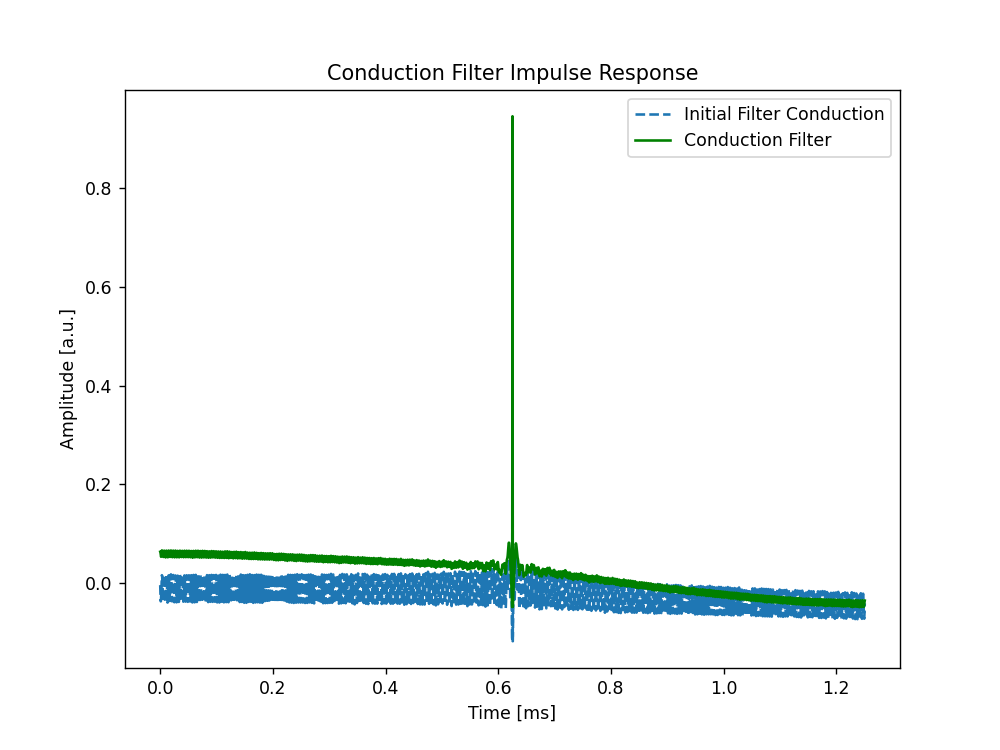

<IPython.core.display.Javascript object>


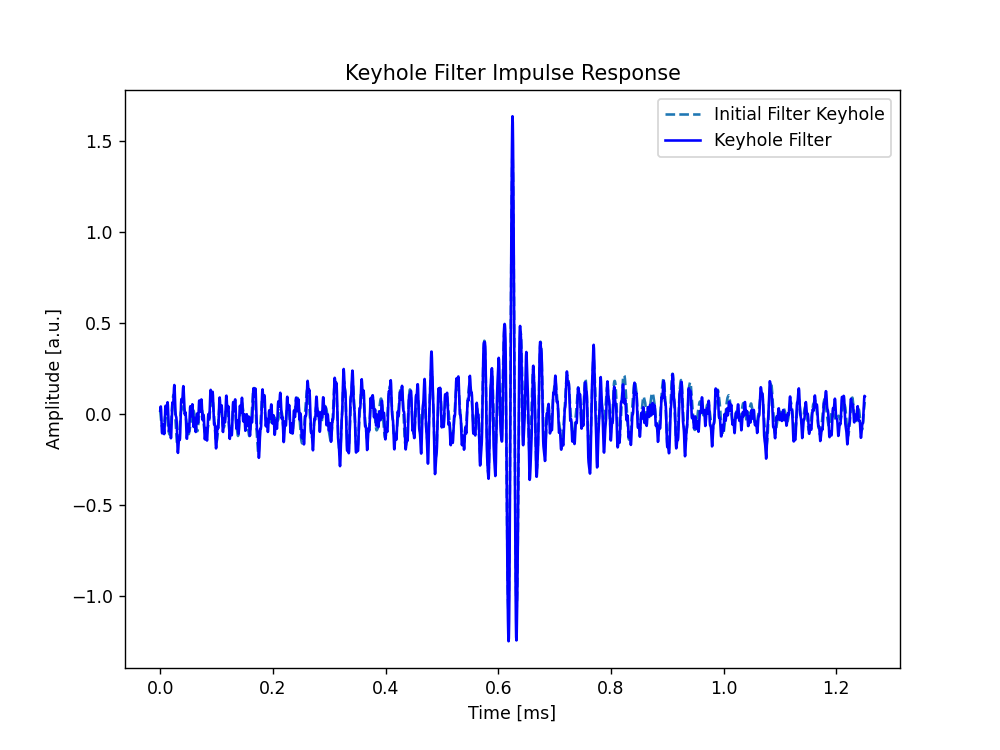

<IPython.core.display.Javascript object>


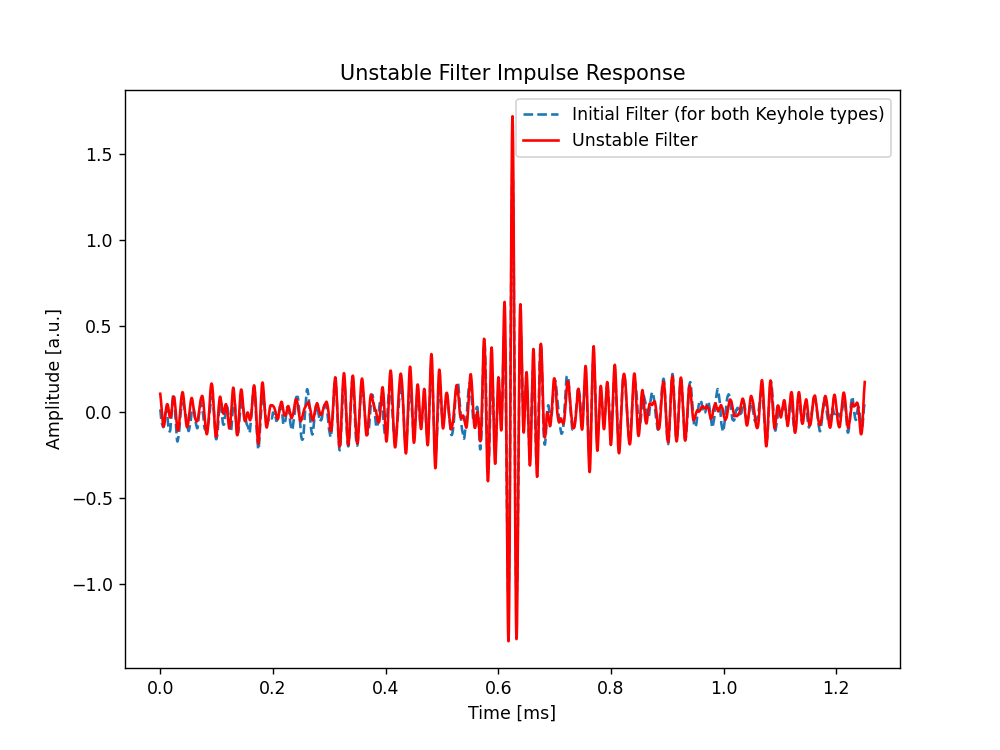

In [17]:
# Compute time array
num_samples = len(weigths_init)
time_array = np.linspace(0, num_samples / Fs, num_samples) * 1000  # in milliseconds

# Retrieve filter weights (impulse response) for the three models
weights_cond = prediction.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + prediction.smooth_filtKH.bias.cpu().detach().numpy()
weights_kh = predictionKH.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionKH.smooth_filtKH.bias.cpu().detach().numpy()
weights_unst = predictionUnst.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionUnst.smooth_filtKH.bias.cpu().detach().numpy()

# Plot for Conduction filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init_cond, label='Initial Filter Conduction', linestyle='--')
plt.plot(time_array, weights_cond, label='Conduction Filter', color='green')
plt.legend()
plt.title('Conduction Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()

# Plot for Stable Keyhole filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init, label='Initial Filter Keyhole', linestyle='--')
plt.plot(time_array, weights_kh, label='Keyhole Filter', color='blue')
plt.legend()
plt.title('Keyhole Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()

# Plot for Unstable Keyhole filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init, label='Initial Filter (for both Keyhole types)', linestyle='--')
plt.plot(time_array, weights_unst, label='Unstable Filter', color='red')
plt.legend()
plt.title('Unstable Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()


### Frequency Response Visualization for Different Filters

In this section, we delve into the frequency response characteristics of our filters:

1. **Conduction Filter:** A side-by-side comparison of the initial and trained Conduction filter's frequency response, highlighting the spectral modifications that have taken place during the training phase.
2. **Keyhole Filters (Stable and Unstable):** The frequency responses of both the trained Stable and Unstable Keyhole filters are displayed. For reference, the initial frequency response, which is shared by both types of Keyhole filters, is also plotted.

The frequency response plots serve as a spectral analysis tool, elucidating how each filter processes different frequency components before and after training.


<IPython.core.display.Javascript object>


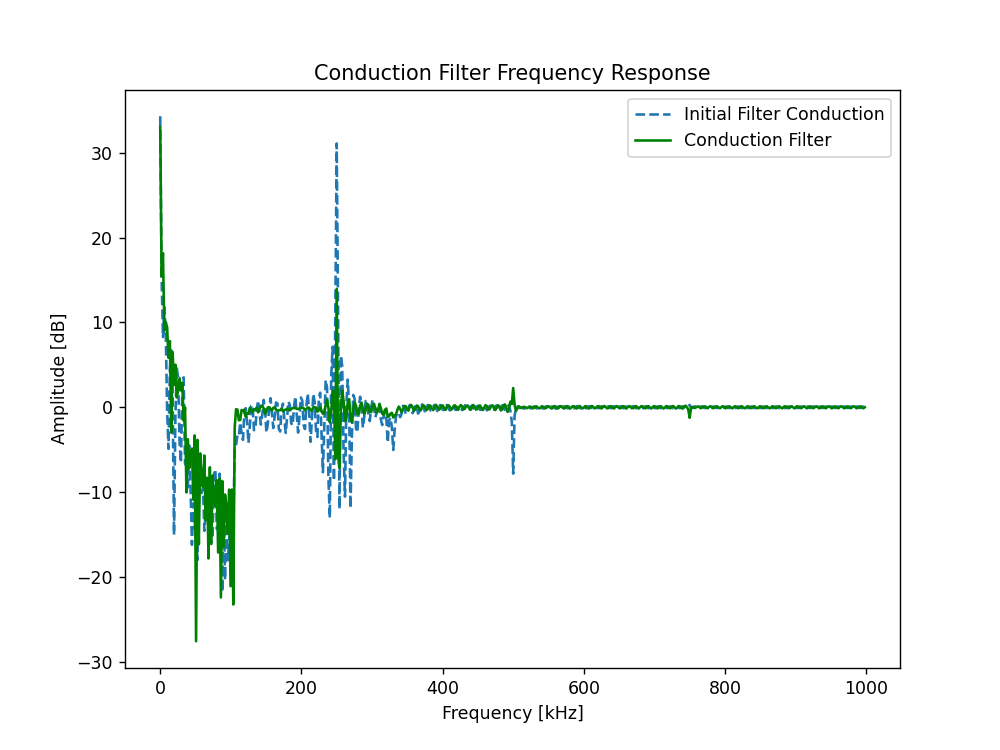

<IPython.core.display.Javascript object>


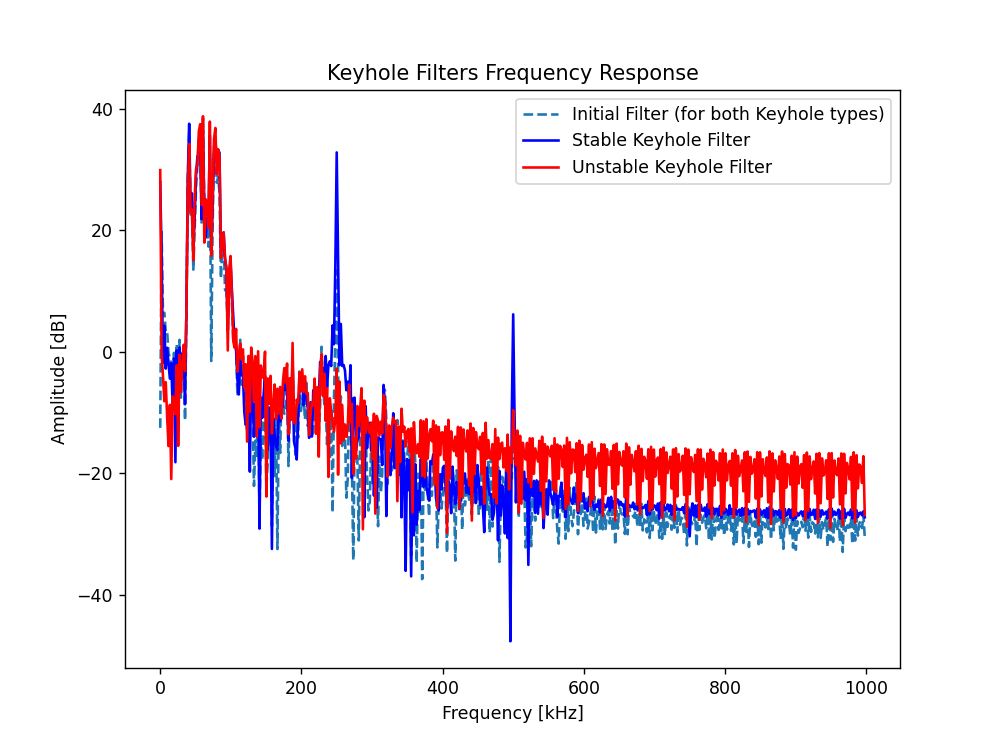

In [18]:
# Compute time array
num_samples = len(weigths_init)
time_array = np.linspace(0, num_samples / Fs, num_samples) * 1000  # in milliseconds

# Retrieve filter weights (impulse response) for the three models
weights_cond = prediction.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + prediction.smooth_filtKH.bias.cpu().detach().numpy()
weights_kh = predictionKH.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionKH.smooth_filtKH.bias.cpu().detach().numpy()
weights_unst = predictionUnst.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionUnst.smooth_filtKH.bias.cpu().detach().numpy()

# Compute frequency response for all filters
w_init_cond, h_init_cond = scipy.signal.freqz(weigths_init_cond, fs=Fs)
w_cond, h_cond = scipy.signal.freqz(weights_cond, fs=Fs)

w_init, h_init = scipy.signal.freqz(weigths_init, fs=Fs)
w_kh, h_kh = scipy.signal.freqz(weights_kh, fs=Fs)
w_unst, h_unst = scipy.signal.freqz(weights_unst, fs=Fs)

# Plot for Conduction filter's frequency response
plt.figure(figsize=(8, 6))
plt.plot(w_init_cond/1e3, 20 * np.log10(abs(h_init_cond)), label='Initial Filter Conduction', linestyle='--')
plt.plot(w_cond/1e3, 20 * np.log10(abs(h_cond)), label='Conduction Filter', color='green')
plt.legend()
plt.title('Conduction Filter Frequency Response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.show()

# Plot for Keyhole filters' frequency response
plt.figure(figsize=(8, 6))
plt.plot(w_init/1e3, 20 * np.log10(abs(h_init)), label='Initial Filter (for both Keyhole types)', linestyle='--')
plt.plot(w_kh/1e3, 20 * np.log10(abs(h_kh)), label='Stable Keyhole Filter', color='blue')
plt.plot(w_unst/1e3, 20 * np.log10(abs(h_unst)), label='Unstable Keyhole Filter', color='red')
plt.legend()
plt.title('Keyhole Filters Frequency Response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.show()


### Frequency Response Visualization for Multiple Models using LOOCV

In this section, we're visualizing the frequency responses of the Stable Keyhole filters obtained from various models trained using the Leave-One-Out Cross-Validation (LOOCV) approach. Due to the LOOCV method, we end up with as many trained models as there are signals in our dataset. Each iteration of LOOCV retains a single data sample as the validation set while training on the rest, resulting in a distinct model for each signal. 

The plotted frequency responses allow us to inspect the spectral characteristics of the Keyhole filters for each of these models. By analyzing these plots, we can gain insights into the consistency and variability of the filter behavior across different LOOCV iterations.


<IPython.core.display.Javascript object>


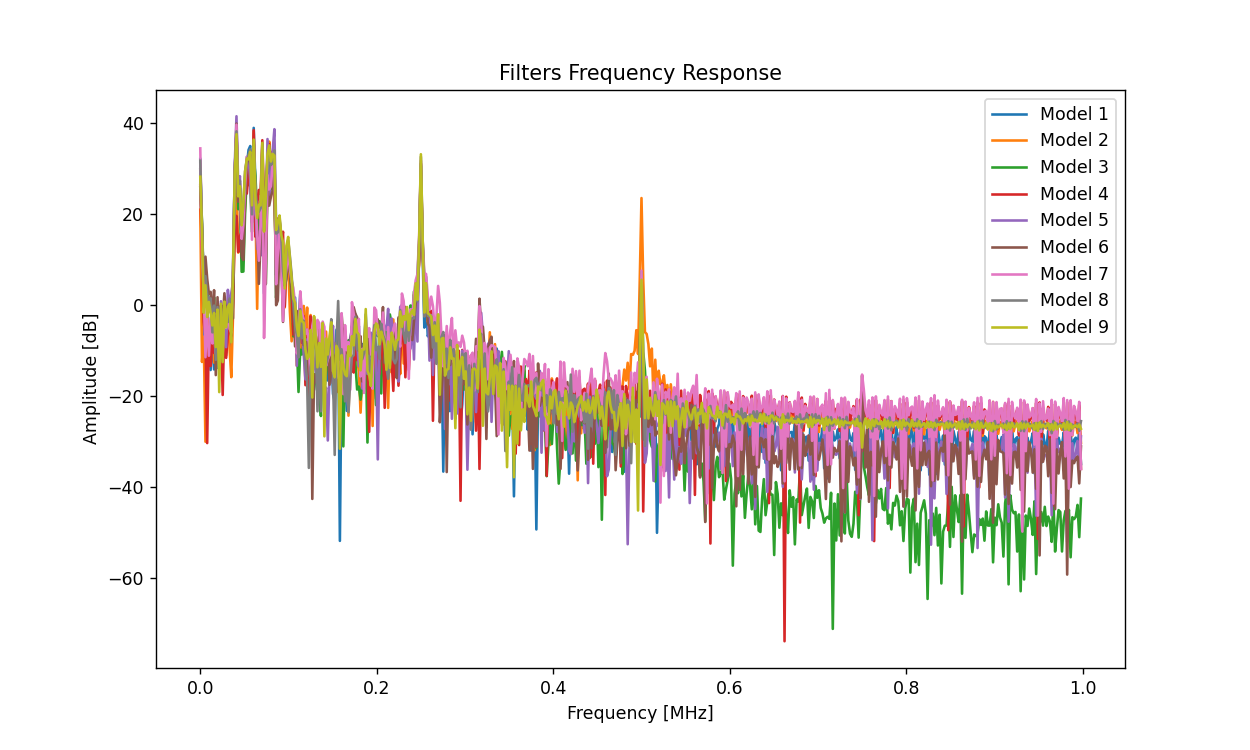

In [19]:
# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over all models in models_KH
for i in range(len(xs)):
    # Extract filter from the model
    predictionKH = models_KH[i]
    weights_starKH = predictionKH.smooth_filtKH.weight.view(-1).to('cpu').detach().numpy() + predictionKH.smooth_filtKH.bias.view(-1).to('cpu').detach().numpy()
    
    # Compute frequency response for the Stable Keyhole filter
    w_KH, h_KH = scipy.signal.freqz(weights_starKH, fs=Fs)

    # Plotting
    plt.title(f'Filters Frequency Response')
    plt.plot(w_KH / 1e6, 20 * np.log10(np.abs(h_KH)), label=f'Model {i+1}')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [dB]')
    plt.legend()
    plt.show()


### Model Evaluation and Visualization for Three Regimes Using LOOCV

In this evaluation, we leverage the Leave-One-Out Cross-Validation (LOOCV) method to assess the model's performance on each available signal in the dataset. The methodology involves:

1. **Data Preparation and Signal Processing:** For every signal in the dataset, the corresponding predictions from the trained models for the three regimes — Conduction, Stable Keyhole, and Unstable Keyhole — are extracted. Each signal is passed through every model, and the outputs are aggregated.
2. **Visualization:** The processed signals are graphically represented, juxtaposing the model's predictions against the ground truth. This visualization facilitates a visual assessment of the model's accuracy and highlights potential discrepancies.
3. **Metric Calculation:** For every signal, key performance metrics — F1-score, Precision, and Recall — are determined for each regime, providing a quantitative measure of the model's performance.
4. **Overall Evaluation:** Upon processing all signals, a comprehensive performance metric is derived, offering a holistic overview of the model's performance across the entire dataset.

Thanks to the LOOCV strategy, we ensure that each signal is treated as unseen data at least once, providing a robust evaluation of our model's generalization capabilities across the entire dataset.


<IPython.core.display.Javascript object>


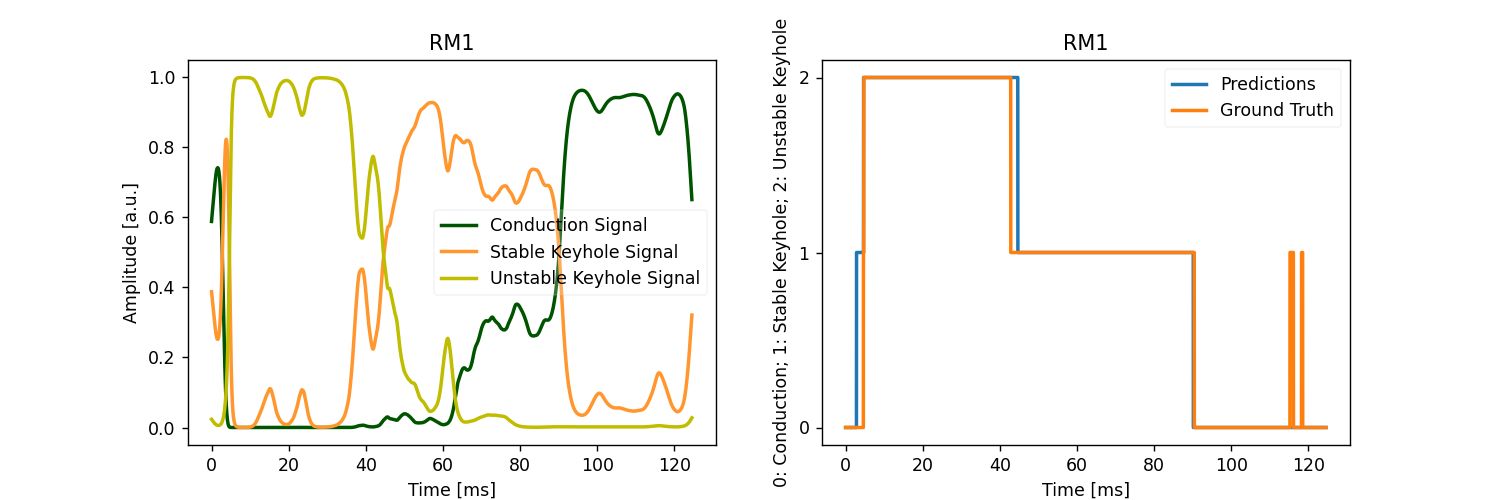

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


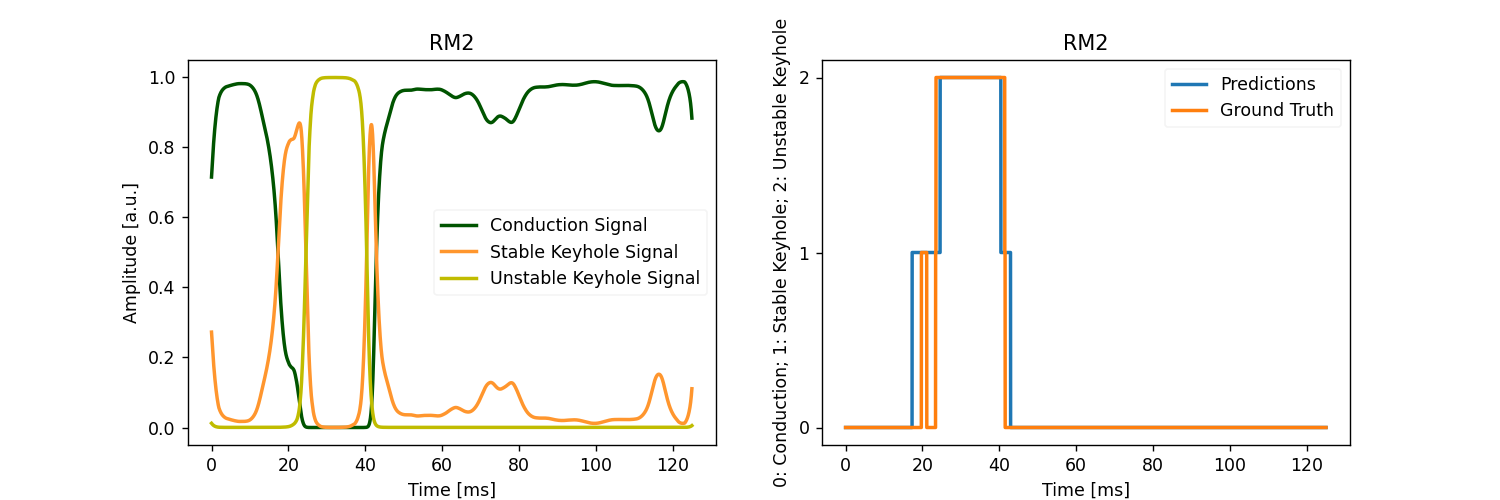

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


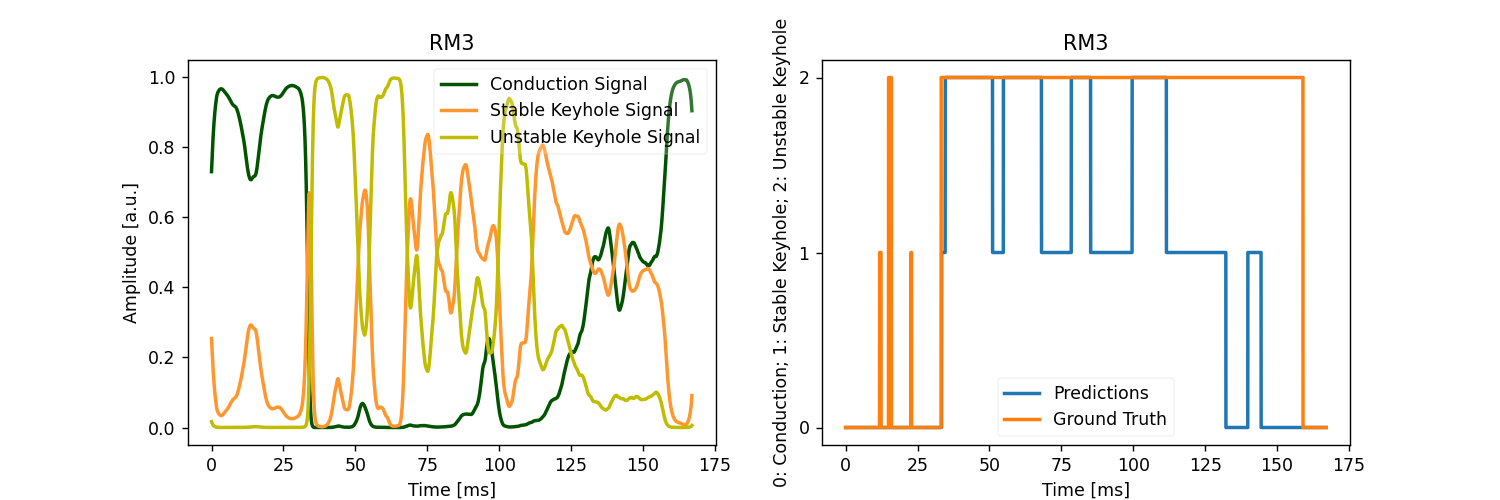

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


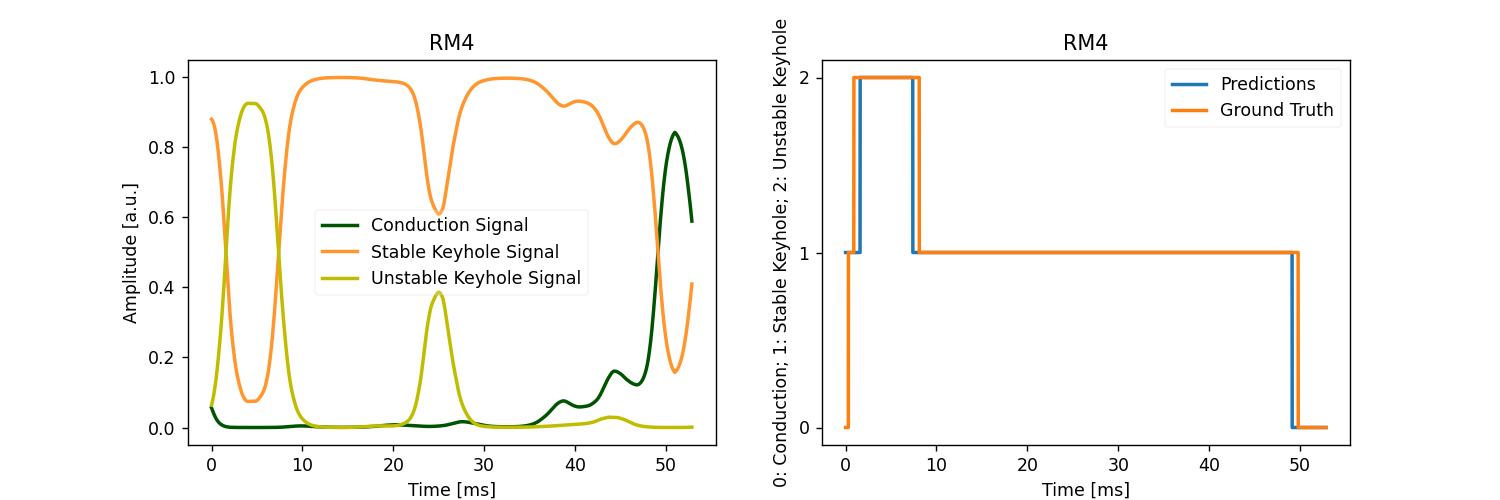

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


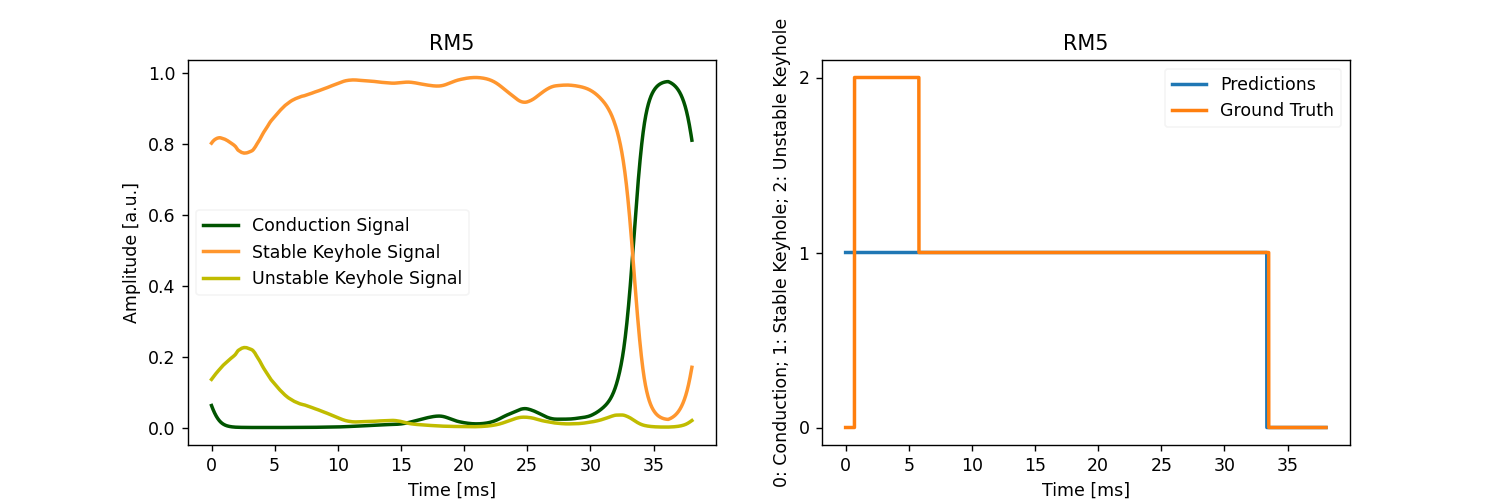

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


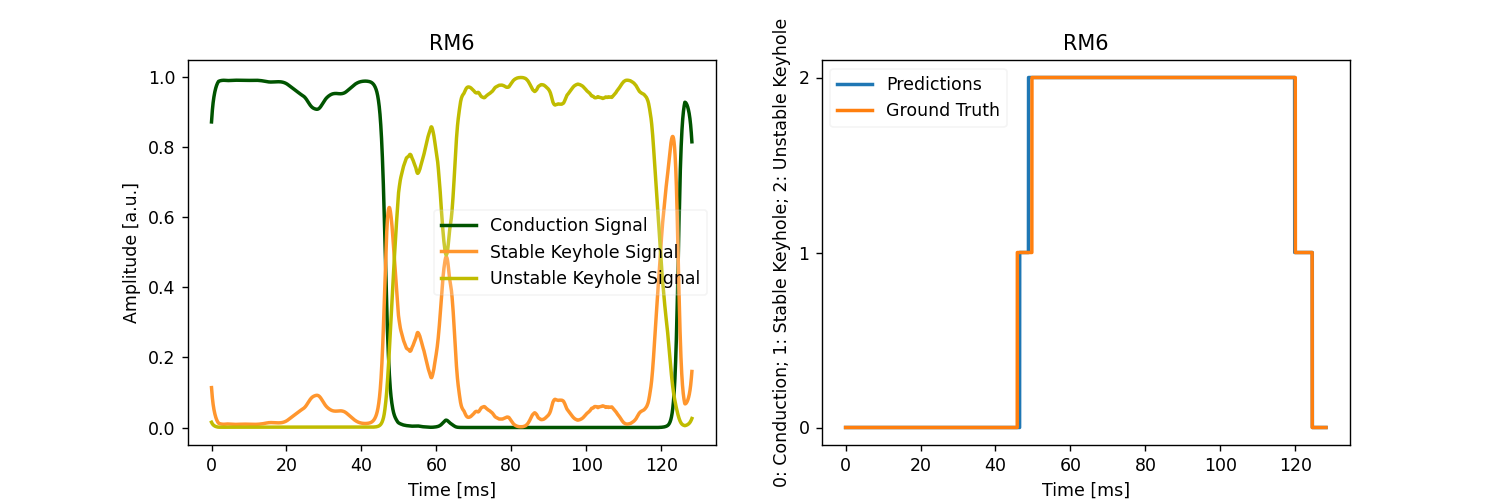

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


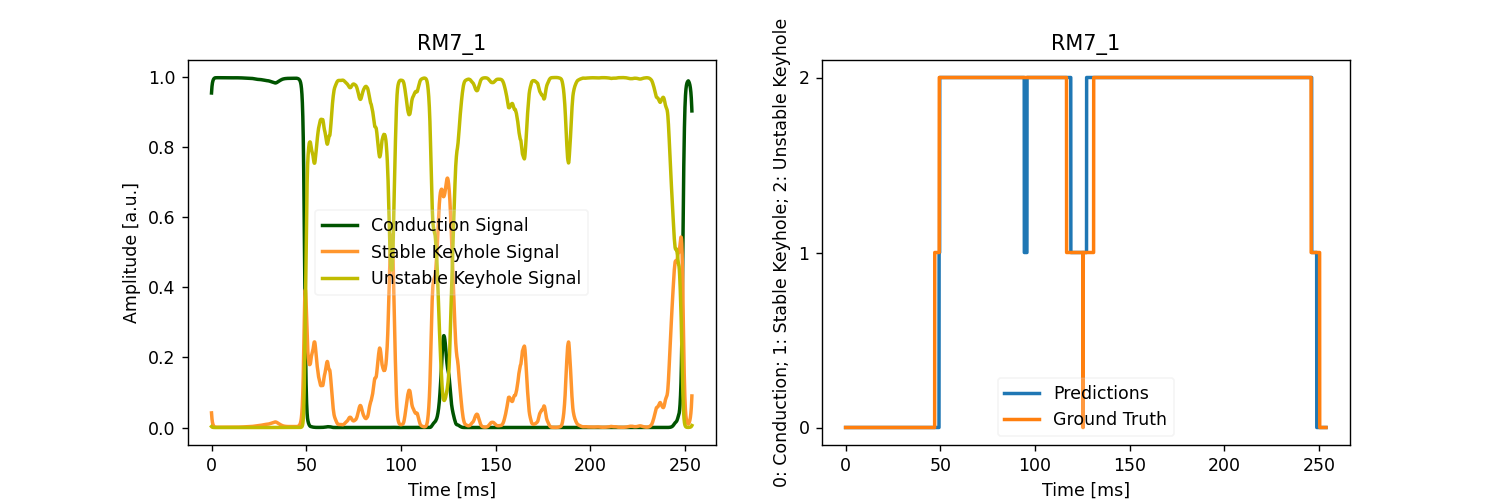

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


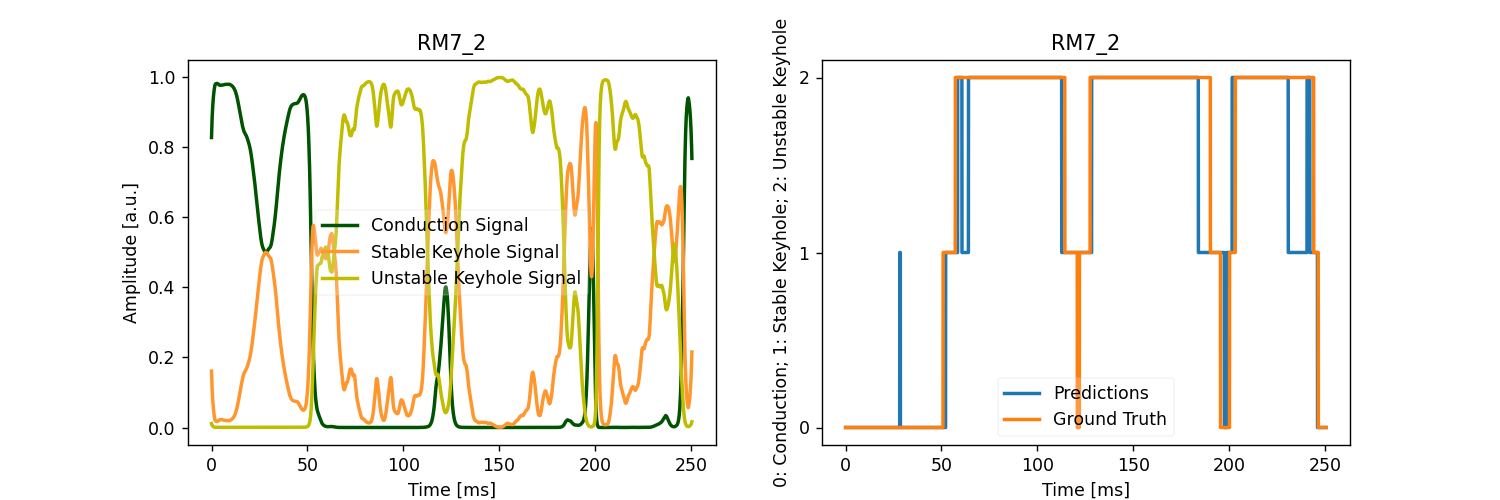

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


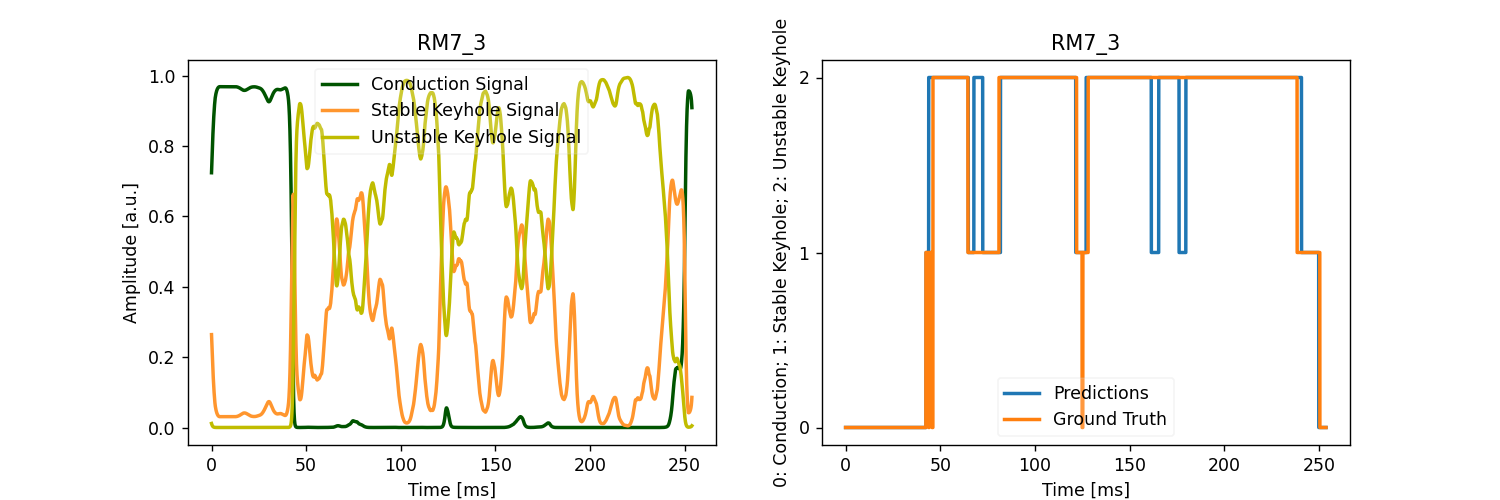

----------------------------------------------------------------------------------------------------


In [20]:
m = nn.Softmax(dim=1)
precision_calc = Precision(task='Multiclass', average='none', num_classes=3)
recall_calc = Recall(task='Multiclass', average='none', num_classes=3)

def process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, models_Unst, device, Fs):
    with torch.no_grad():
        name = names[outer]
        GT = GTs[outer].to(device)
        signal = xs[outer].to(device)
        
        time = np.linspace(start=0, stop=len(signal) * 1/Fs, num=len(signal)) * 1000
        prediction = models_Cond[i]
        predictionKH = models_KH[i]
        predictionUnst = models_Unst[i]
        
        x_Cond = prediction(signal)
        x_KH = predictionKH(signal)
        x_Unst = predictionUnst(signal)

        myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
        output = m(myPreds)
        _, ind = torch.max(myPreds, 1)

        visualize_signal(time, output, ind, GT, name)
        
        score = F1(ind.long(), GT.view(-1).long()).cpu().detach().numpy()
        precision = precision_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()
        recall = recall_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()

        return name, score, precision, recall, GT.view(-1).long(), ind.long()

def visualize_signal(time, output, ind, GT, name):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time, output[:, 0].cpu(), label='Conduction Signal', linewidth=2, color=(0, 84/255, 0))
    axs[0].plot(time, output[:, 1].cpu(), label='Stable Keyhole Signal', linewidth=2, color=(1,150/255,46/255))
    axs[0].plot(time, output[:, 2].cpu(), label='Unstable Keyhole Signal', linewidth=2, color=(192/255, 188/255, 0))
    axs[1].plot(time, ind.cpu(), label='Predictions', linewidth=2)
    axs[1].plot(time, GT.cpu(), label='Ground Truth', linewidth=2)
    
    for ax, title in zip(axs, [name, name]):
        ax.set_title(title)
        ax.set_xlabel('Time [ms]')
        ax.legend(framealpha=0.2)
    axs[0].set_ylabel('Amplitude [a.u.]')
    axs[1].set_ylabel('0: Conduction; 1: Stable Keyhole; 2: Unstable Keyhole')
    axs[1].set_yticks([0, 1, 2])

    fig.set_size_inches(12, 4)
    plt.show()

overall_results = []
overall_preds = []
overall_GTs = []

for i, outer in enumerate(range(len(names))):
    name, scores, precisions, recalls, GT, preds = process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, models_Unst, device, Fs)
    overall_preds.append(preds)
    overall_GTs.append(GT)
    
    signal_metrics = {
        'Signal Name': name,
        'F1 Conduction': scores[0],
        'F1 Stable Keyhole': scores[1],
        'F1 Unstable Keyhole': scores[2],
        'Precision Conduction': precisions[0],
        'Precision Stable Keyhole': precisions[1],
        'Precision Unstable Keyhole': precisions[2],
        'Recall Conduction': recalls[0],
        'Recall Stable Keyhole': recalls[1],
        'Recall Unstable Keyhole': recalls[2]
    }

    # Print metrics for the current signal
    df_signal = pd.DataFrame([signal_metrics])
    display(df_signal.style.hide(axis='index'))
    print('-' * 100)

# Overall F1 score, precision, and recall across all signals
overall_score = F1(torch.cat(overall_preds), torch.cat(overall_GTs)).cpu().detach().numpy()
overall_prec = precision_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()
overall_rec = recall_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()

for j, regime in enumerate(['Conduction', 'Stable Keyhole', 'Unstable Keyhole']):
    overall_results.append({
        'Regime': regime,
        'Overall F1-score': overall_score[j],
        'Overall Precision': overall_prec[j],
        'Overall Recall': overall_rec[j]
    })

# Display the overall results table
df_overall = pd.DataFrame(overall_results)

### Overall Performance Metrics for Each Regime

Below, we present a summary table showcasing the model's overall performance across the entire dataset for each of the three regimes: Conduction, Stable Keyhole, and Unstable Keyhole. This table aggregates the results obtained using the LOOCV method and provides key metrics — F1-score, Precision, and Recall — for a holistic evaluation. This consolidated view enables us to assess the model's efficacy and reliability in differentiating between the three regimes.


In [21]:
display(df_overall.style.hide(axis='index'))

### Confusion Matrix Visualization 

In this section, we visualize the confusion matrix for our segmentation predictions in terms of percentages. This normalized representation provides a clearer insight into the model's performance relative to the number of instances for each class. It indicates the percentage of times each class was correctly predicted and the percentage of times misclassifications occurred.


<IPython.core.display.Javascript object>


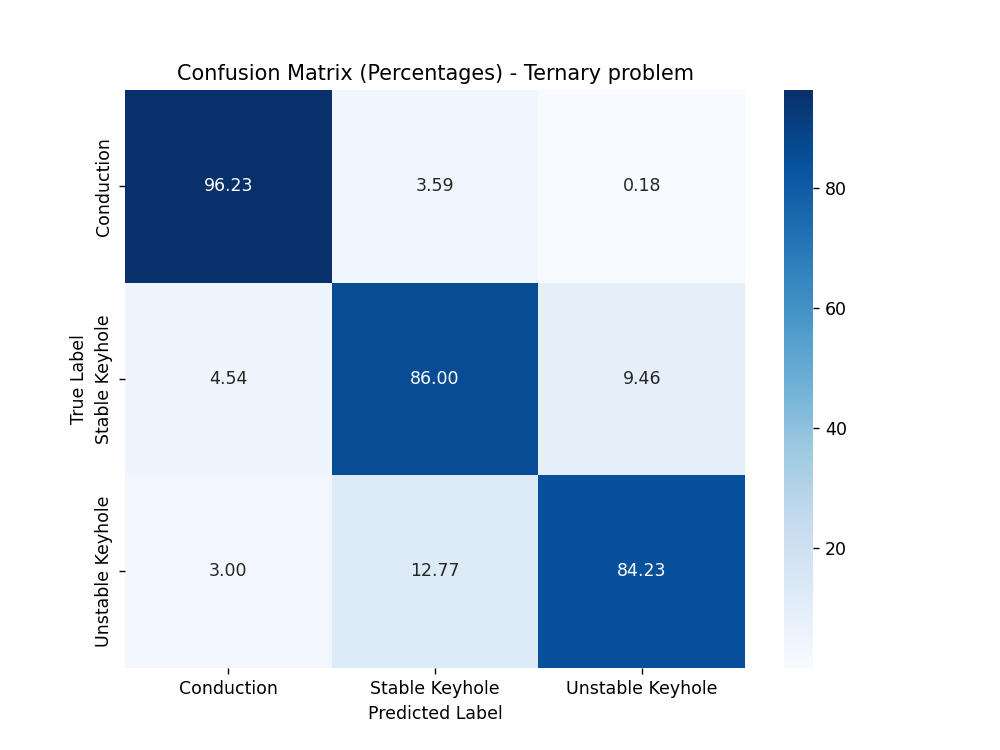

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(torch.cat(overall_GTs).cpu(), torch.cat(overall_preds).cpu())

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Conduction', 'Stable Keyhole', 'Unstable Keyhole'], yticklabels=['Conduction', 'Stable Keyhole', 'Unstable Keyhole'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Percentages) - Ternary problem')
plt.show()

---
**Disclaimer and Credits**

**Disclaimer**: This code is shared to promote transparency and further research. While every effort has been exerted to ensure its accuracy, we provide it "as-is" without warranties. Users are advised to utilize, adapt, and modify the code at their discretion and risk. The authors disclaim any liability arising from its use, including, but not limited to, errors or unintended outcomes.

**Credits**: The conceptualization and execution of this code are credited to Giulio Masinelli. Released under the CC0 license in accordance with Nature Communication's recommendations. Refer to the paper, "Harmonizing Sound and Light: X-Ray Imaging Unveils Acoustic Signatures of Stochastic Inter-Regime Instabilities during Laser Melting," for a comprehensive understanding.

---